# Modelling Compressed Air Energy Storage at Steady and Transient Operation

### Sunshine Tanphiphat
M Sc. Energy System,
Department of Engineering Science,
University of Oxford,

Supervisor: 
Prof. Budimir Rosic (Oxford Thermofluids Institute),
Prof. Aidong Yang (Oxford Agile Initiative)

2025

# Environment

## Clearing

In [1]:
%reset -f
from IPython.display import clear_output; clear_output(wait=True)
import matplotlib.pyplot as plt; plt.close('all')

## Simulation timer

In [2]:
import time              
_start_time = time.time() 

## Function Imports

In [3]:
from pathlib import Path
import time
from openpyxl import load_workbook

In [4]:
import os
import math
import pandas as pd
import numpy as np
import sympy as sp
import sys 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [5]:
from evalwitherrfun import eval_with_err
from addfun import add_fun
from subtractfun import subtract_fun
from multiplyfun import multiply_fun
from dividefun import divide_fun
from powerfun import power_fun

In [6]:
from getvaluefun import get_value
from getremainingthermovarsfun import get_remaining_thermo_vars
from gethfrometafun import get_h_from_eta
from getsolvedstatefun import get_solved_state

In [7]:
from getdepthfromTfun import get_depth_from_T
from callgetvaluefun import call_get_value
from getTfromdepthfun import get_T_from_depth

In [8]:
from getDutyfun import get_Duty
from getToutfun import get_Tout
from getToutstr2fun import get_Tout_str2
from Wfun import W_fun
from Qfun import Q_fun

In [9]:
from selectvaluecolumnsfun import select_value_columns
from quantvisfun import quant_vis
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator

In [10]:
from findPbottomsecantfun import find_P_bottom_secant
from findpipediameterfun import find_pipe_diameter
from batchoptpipediameterfun import batch_opt_pipe_diameter

In [11]:
from getvisfun import get_vis
from secantsolvecompressibilityfun import secant_solve_compressibility_implicit
from operategeobatteryfun import operate_geobattery

In [12]:
from bartoMPafun import bar_to_MPa

In [13]:
from pathlib import Path
project_root = Path.cwd().parent     
input_dir    = project_root / 'Input_Spreadsheets'    
model_dir = project_root / 'Model_Files' 

# Inputs

## Global Inputs

### Simulation Round

In [14]:
simulation_name = 'CAESUK'

### CGES Type

In [15]:
Working_fluid = 'Air'
Cycle = 'CAES'

### Toggles

In [16]:
# Allowable frictional loss MPa/m
gradP = 0.0001*2

In [17]:
# Storage Depths 
z_HS = 200; # HS C.O.M. depth
z_LS = 0; # LS C.O.M. depth (zero - atmosphere)

In [18]:
min_HS_reg = gradP * 2 * z_HS; min_LS_reg = gradP * 2 * z_LS;
print(f'Minimum HS pressure regulation = {min_HS_reg} MPa, LS pressure regulation = {min_LS_reg} MPa')

Minimum HS pressure regulation = 0.08 MPa, LS pressure regulation = 0.0 MPa


In [19]:
HS_thrtl_deliberate = (bar_to_MPa(82.05) - bar_to_MPa(64))  # Deliberate turbine inlet pressure regulation
LS_thrtl_deliberate = 0 # Deliberate compressor inlet pressure regulation (zero - atmosphere)

In [20]:
HS_reg = min_HS_reg + HS_thrtl_deliberate; LS_reg = min_LS_reg + LS_thrtl_deliberate; 
print(f'Pressure regulation: HS {HS_reg} ΔMPa, LS {LS_reg} ΔMPa')

Pressure regulation: HS 1.8849999999999998 ΔMPa, LS 0.0 ΔMPa


In [21]:
# Compression Train
P_0, P_0err = bar_to_MPa(1.01325), 0 #MPa Compressor train inlet P (atmospheric = 0.101325 MPa)
T_0, T_0err = (273 + 10), 0 #K Compressor train inlet T (ambient = 293.15 K)
P_max_c = bar_to_MPa(82.05) #Compressor train outlet P (40-70 bar)
num_C = 4 #num Compressors in train
P_lift_total = P_max_c - P_0; Plift1 = bar_to_MPa(3.04) - bar_to_MPa(1.01); Plift2 = bar_to_MPa(9.12) - bar_to_MPa(3.04); Plift3 = bar_to_MPa(27.35) - bar_to_MPa(9.12); Plift4 = bar_to_MPa(82.05) - bar_to_MPa(27.35)
P_lift1ratio = Plift1/P_lift_total; P_lift2ratio = Plift2/P_lift_total; P_lift3ratio = Plift3/P_lift_total; P_lift4ratio = Plift4/P_lift_total

In [22]:
# Expansion Distribution
num_T = 3 #num Turbines in train
P_drop_total = bar_to_MPa(64) - bar_to_MPa(1.02); Pdrop1 = bar_to_MPa(64) - bar_to_MPa(25.60); Pdrop2 = bar_to_MPa(25.60) - bar_to_MPa(5.12); Pdrop3 = bar_to_MPa(5.12) - bar_to_MPa(1.02)
P_drop1ratio = Pdrop1/P_drop_total; P_drop2ratio = Pdrop2/P_drop_total; P_drop3ratio = Pdrop3/P_drop_total;

In [23]:
# Reheating
T_max = 580 + 273

In [24]:
# Nameplate capacity of wind farm kW
Nameplate_capacity = 100 * 1000 

# Power spot prices
elexon_df = pd.read_excel(input_dir/'ELEXON_SystemPrices_Jul_7_2019.xlsx'); SystemPrices_arr = elexon_df['System_price'].to_numpy(); assert SystemPrices_arr.shape[0] == 48, "Expected 48 half‐hourly prices"

# Wind generation
rn_df = pd.read_excel(input_dir/'RenewablesNinja_WindGeneration_Jul_7_2019.xlsx'); hourly_cf = rn_df['Capacity_factor'].to_numpy(); assert hourly_cf.shape[0] == 24, "Expected 24 hourly capacity factors"
CF_avg = hourly_cf.mean()

## Internal Parameters

### Geography

In [25]:
Patm = 0.101325 #MPa
Vrock_LS, Vrock_HS = 1e5, 1e5 #aquifer rock volume
z_S, z_Serr = 0, 0 #m
G, G_err = 0.025, 0 #K/m Geologic T gradient
Ts, Ts_err = 283, 0 #K Surface temperature
beta_p, beta_perr = 4.5*1e-10, 0 #Pa-1 Pore compressibility 
beta_w, beta_werr = 3.5*1e-10, 0 #Pa-1 Brine compressibility
p_w, p_werr = 1025, 0 # Surface brine density kg/m3
g, gerr = 9.81, 0 # Gravitational acceleration
por = 0.275 # Porosity
tol_P_storage = 0.025 #qausi-steady-state pressure deviation allowance frac

### Compression train

In [26]:
T_w, T_werr = 313, 0; #compressor inlet T
eta_C = 0.85 #frac Compressor isentropic efficiency
eta_grid_avg = 0.50 #frac baseload power plant efficiency

### Expansion train

In [27]:
eta_T1 = 0.87; eta_T2 = 0.87; eta_T3 = 0.87 #frac Turbine isentropic efficiency
eta_gen_avg = 0.476 #frac standalone generator efficiency
eta_burner_Gulen = 0.6815 #gas burner efficiency
eta_burner_Wenyi = 0.80
T_exhaust = 100 + 273 #exhaust air temperature

### Transport 

In [28]:
m_CO2info=[1, 0]; m_CO2 = m_CO2info[0]; m_CO2err = m_CO2info[1] #Mass basis
r= 0.000045 #Conduit roughness m

### Thermodynamic Data

In [29]:
Thermodata_filename = f'../Input_Spreadsheets/Thermodata_{Working_fluid}'; df0 = pd.read_excel(f'{Thermodata_filename}.xlsx')

# Simulation

## Derived P

In [30]:
HS_fric = z_HS * gradP; HS_thrtl = HS_reg - 2*HS_fric; 
if HS_thrtl < 0: 
    print('HS Regulation Spares Insufficiently for Frictional Losses'); raise KeyboardInterrupt("Stopping execution")

In [31]:
P_lift = P_max_c - P_0; P_lift1 = P_lift1ratio*P_lift; P_lift2 = P_lift2ratio*P_lift; P_lift3 = P_lift3ratio*P_lift; P_lift4 = P_lift4ratio*P_lift; 

In [32]:
P_inlet_t = P_max_c - HS_reg;
P_min_t = P_0 + LS_reg; 
P_drop = P_inlet_t - P_min_t; P_drop1 = P_drop1ratio*P_drop; P_drop2 = P_drop2ratio*P_drop; P_drop3 = P_drop3ratio*P_drop

In [33]:
P1_d = P_0 
P2_d = P1_d + P_lift1 #out of C1
P3_d = P2_d #out of ICL
P4_d = P3_d + P_lift2 #out of C2
P5_d = P4_d #out of ICL
P6_d = P5_d + P_lift3 #out of C3
P7_d = P6_d #out of ICL
P8_d = P7_d + P_lift4 #out of C4
P9_d = P8_d #out of ICL
P10_d = P9_d - HS_reg #out of reg
P11_d = P10_d #out of HEX
P12_d = P11_d #out of HE
P13_d = P12_d - P_drop1 #out of T1
P14_d = P13_d #out of HE
P15_d = P14_d - P_drop2 #out of T2
P16_d = P15_d #out of HE
P17_d = P16_d - P_drop3 #out of T3
P18_d = P17_d #out of HEX

if P8_d == P_max_c:
    print('Compression pressure achieved')
else: 
    print('No')
if P12_d == P_0 + LS_reg:
    print('Cycle pressure calibrated')
else:
    print('No')

No
No


## Defining Stream State

In [34]:
df = pd.read_excel(input_dir/f'{Cycle}_Inputs.xlsx'); dfc = pd.read_excel(input_dir/f'Cycledata_{Cycle}.xlsx');

In [35]:
# Stream 1
stream_num = 1; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','T']
df.loc[idx, ['P','Perr','T','Terr']] = [P1_d, 0, T_0, 0]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

P exact: 0.101
interp T@0.101: 201.942±0.000
P exact: 0.101
interp T@0.101: 283.142±0.000
P exact: 0.101
interp T@0.101: 6.806±0.000
P exact: 0.101
interp T@0.101: 337.370±0.000
P exact: 0.101
interp T@0.101: 1.248±0.000
P exact: 0.101
interp T@0.101: 0.717±0.000
P exact: 0.101
interp T@0.101: 1.006±0.000


P interp bounds: 0.200,0.500
interp s@0.304: 344.121±0.000
interp s@0.304: 457.216±0.000
→ 383.450±0.000
Compressor: h_in=283.142±0.000, h_iso=383.450±0.000, eta=0.850 → h_out=401.151±0.000


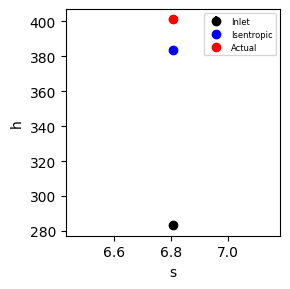

P interp bounds: 0.200,0.500
interp h@0.304: 400.042±0.000
interp h@0.304: 400.383±0.000
→ 400.160±0.000
P interp bounds: 0.200,0.500
interp h@0.304: 286.258±0.000
interp h@0.304: 286.100±0.000
→ 286.203±0.000
P interp bounds: 0.200,0.500
interp h@0.304: 6.960±0.000
interp h@0.304: 6.695±0.000
→ 6.868±0.000
P interp bounds: 0.200,0.500
interp h@0.304: 400.720±0.000
interp h@0.304: 401.491±0.000
→ 400.988±0.000
P interp bounds: 0.200,0.500
interp h@0.304: 1.741±0.000
interp h@0.304: 4.376±0.000
→ 2.657±0.000
P interp bounds: 0.200,0.500
interp h@0.304: 0.726±0.000
interp h@0.304: 0.727±0.000
→ 0.727±0.000
P interp bounds: 0.200,0.500
interp h@0.304: 1.015±0.000
interp h@0.304: 1.018±0.000
→ 1.016±0.000


In [36]:
# Stream 2
stream_num = 2; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','h']
P1, P1err, h1, h1err, s1, s1err = df.loc[idx-1, ['P', 'Perr','h','herr','s', 'serr']]; 
P2, P2err = P2_d, 0; h2,h2err=get_h_from_eta([P2, P2err],[h1,h1err],[s1, s1err],eta_C,'Compressor',Thermodata_filename);  
df.loc[idx, ['P','Perr','h','herr']] = [P2, P2err, h2, h2err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

In [37]:
# Stream 3
stream_num = 3; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','T']
P3, P3err = P3_d, 0; T3,T3err=[T_w,T_werr]
df.loc[idx, ['P','Perr','T','Terr']] = [P3, P3err, T3, T3err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

P interp bounds: 0.200,0.500
interp T@0.304: 223.316±0.000
interp T@0.304: 222.750±0.000
→ 223.119±0.000
P interp bounds: 0.200,0.500
interp T@0.304: 313.127±0.000
interp T@0.304: 312.511±0.000
→ 312.913±0.000
P interp bounds: 0.200,0.500
interp T@0.304: 6.712±0.000
interp T@0.304: 6.447±0.000
→ 6.620±0.000
P interp bounds: 0.200,0.500
interp T@0.304: 354.880±0.000
interp T@0.304: 355.310±0.000
→ 355.030±0.000
P interp bounds: 0.200,0.500
interp T@0.304: 2.227±0.000
interp T@0.304: 5.572±0.000
→ 3.390±0.000
P interp bounds: 0.200,0.500
interp T@0.304: 0.719±0.000
interp T@0.304: 0.720±0.000
→ 0.719±0.000
P interp bounds: 0.200,0.500
interp T@0.304: 1.008±0.000
interp T@0.304: 1.013±0.000
→ 1.010±0.000


P interp bounds: 0.500,1.000
interp s@0.912: 371.457±0.000
interp s@0.912: 453.210±0.000
→ 438.875±0.000
Compressor: h_in=312.913±0.000, h_iso=438.875±0.000, eta=0.850 → h_out=461.104±0.000


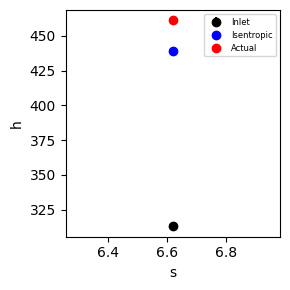

P interp bounds: 0.500,1.000
interp h@0.912: 459.140±0.000
interp h@0.912: 459.441±0.000
→ 459.388±0.000
P interp bounds: 0.500,1.000
interp h@0.912: 329.077±0.000
interp h@0.912: 328.835±0.000
→ 328.878±0.000
P interp bounds: 0.500,1.000
interp h@0.912: 6.799±0.000
interp h@0.912: 6.636±0.000
→ 6.665±0.000
P interp bounds: 0.500,1.000
interp h@0.912: 429.378±0.000
interp h@0.912: 430.411±0.000
→ 430.230±0.000
P interp bounds: 0.500,1.000
interp h@0.912: 4.428±0.000
interp h@0.912: 7.573±0.000
→ 7.022±0.000
P interp bounds: 0.500,1.000
interp h@0.912: 0.736±0.000
interp h@0.912: 0.736±0.000
→ 0.736±0.000
P interp bounds: 0.500,1.000
interp h@0.912: 1.026±0.000
interp h@0.912: 1.028±0.000
→ 1.027±0.000


In [38]:
# Stream 4
stream_num = 4; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','h']
P3, P3err, h3, h3err, s3, s3err = df.loc[idx-1, ['P', 'Perr','h','herr','s', 'serr']]; 
P4, P4err = P4_d, 0; h4,h4err=get_h_from_eta([P4, P4err],[h3,h3err],[s3, s3err],eta_C,'Compressor',Thermodata_filename);  
df.loc[idx, ['P','Perr','h','herr']] = [P4, P4err, h4, h4err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

In [39]:
# Stream 5
stream_num = 5; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','T']
P5, P5err = P5_d, 0; T5,T5err=[T_w,T_werr]
df.loc[idx, ['P','Perr','T','Terr']] = [P5, P5err, T5, T5err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

P interp bounds: 0.500,1.000
interp T@0.912: 222.750±0.000
interp T@0.912: 221.806±0.000
→ 221.972±0.000
P interp bounds: 0.500,1.000
interp T@0.912: 312.511±0.000
interp T@0.912: 311.490±0.000
→ 311.669±0.000
P interp bounds: 0.500,1.000
interp T@0.912: 6.447±0.000
interp T@0.912: 6.245±0.000
→ 6.281±0.000
P interp bounds: 0.500,1.000
interp T@0.912: 355.310±0.000
interp T@0.912: 356.010±0.000
→ 355.887±0.000
P interp bounds: 0.500,1.000
interp T@0.912: 5.572±0.000
interp T@0.912: 11.152±0.000
→ 10.174±0.000
P interp bounds: 0.500,1.000
interp T@0.912: 0.720±0.000
interp T@0.912: 0.721±0.000
→ 0.720±0.000
P interp bounds: 0.500,1.000
interp T@0.912: 1.013±0.000
interp T@0.912: 1.020±0.000
→ 1.019±0.000


P interp bounds: 2.000,5.000
interp s@2.735: 394.162±0.000
interp s@2.735: 514.664±0.000
→ 423.698±0.000
Compressor: h_in=311.669±0.000, h_iso=423.698±0.000, eta=0.850 → h_out=443.468±0.000


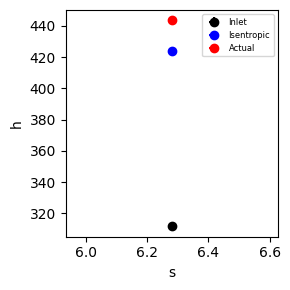

P interp bounds: 2.000,5.000
interp h@2.735: 443.032±0.000
interp h@2.735: 445.099±0.000
→ 443.538±0.000
P interp bounds: 2.000,5.000
interp h@2.735: 315.566±0.000
interp h@2.735: 313.697±0.000
→ 315.108±0.000
P interp bounds: 2.000,5.000
interp h@2.735: 6.397±0.000
interp h@2.735: 6.132±0.000
→ 6.332±0.000
P interp bounds: 2.000,5.000
interp h@2.735: 425.155±0.000
interp h@2.735: 433.528±0.000
→ 427.207±0.000
P interp bounds: 2.000,5.000
interp h@2.735: 15.664±0.000
interp h@2.735: 38.577±0.000
→ 21.280±0.000
P interp bounds: 2.000,5.000
interp h@2.735: 0.734±0.000
interp h@2.735: 0.738±0.000
→ 0.735±0.000
P interp bounds: 2.000,5.000
interp h@2.735: 1.032±0.000
interp h@2.735: 1.050±0.000
→ 1.037±0.000


In [40]:
# Stream 6
stream_num = 6; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','h']
P5, P5err, h5, h5err, s5, s5err = df.loc[idx-1, ['P', 'Perr','h','herr','s', 'serr']]; 
P6, P6err = P6_d, 0; h6,h6err=get_h_from_eta([P6, P6err],[h5,h5err],[s5, s5err],eta_C,'Compressor',Thermodata_filename);  
df.loc[idx, ['P','Perr','h','herr']] = [P6, P6err, h6, h6err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

In [41]:
# Stream 7
stream_num = 7; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','T']
P7, P7err = P7_d, 0; T7,T7err=[T_w,T_werr]
df.loc[idx, ['P','Perr','T','Terr']] = [P7, P7err, T7, T7err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

P interp bounds: 2.000,5.000
interp T@2.735: 219.919±0.000
interp T@2.735: 214.304±0.000
→ 218.543±0.000
P interp bounds: 2.000,5.000
interp T@2.735: 309.484±0.000
interp T@2.735: 303.739±0.000
→ 308.076±0.000
P interp bounds: 2.000,5.000
interp T@2.735: 6.040±0.000
interp T@2.735: 5.760±0.000
→ 5.972±0.000
P interp bounds: 2.000,5.000
interp T@2.735: 357.640±0.000
interp T@2.735: 363.630±0.000
→ 359.108±0.000
P interp bounds: 2.000,5.000
interp T@2.735: 22.335±0.000
interp T@2.735: 55.919±0.000
→ 30.567±0.000
P interp bounds: 2.000,5.000
interp T@2.735: 0.723±0.000
interp T@2.735: 0.729±0.000
→ 0.724±0.000
P interp bounds: 2.000,5.000
interp T@2.735: 1.034±0.000
interp T@2.735: 1.077±0.000
→ 1.045±0.000


P interp bounds: 5.000,10.000
interp s@8.205: 376.978±0.000
interp s@8.205: 463.592±0.000
→ 432.503±0.000
Compressor: h_in=308.076±0.000, h_iso=432.503±0.000, eta=0.850 → h_out=454.461±0.000


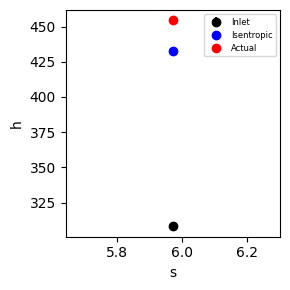

P interp bounds: 5.000,10.000
interp h@8.205: 455.563±0.000
interp h@8.205: 458.044±0.000
→ 457.153±0.000
P interp bounds: 5.000,10.000
interp h@8.205: 321.565±0.000
interp h@8.205: 318.208±0.000
→ 319.413±0.000
P interp bounds: 5.000,10.000
interp h@8.205: 6.157±0.000
interp h@8.205: 5.952±0.000
→ 6.026±0.000
P interp bounds: 5.000,10.000
interp h@8.205: 438.392±0.000
interp h@8.205: 453.172±0.000
→ 447.867±0.000
P interp bounds: 5.000,10.000
interp h@8.205: 37.663±0.000
interp h@8.205: 73.505±0.000
→ 60.640±0.000
P interp bounds: 5.000,10.000
interp h@8.205: 0.739±0.000
interp h@8.205: 0.744±0.000
→ 0.742±0.000
P interp bounds: 5.000,10.000
interp h@8.205: 1.050±0.000
interp h@8.205: 1.076±0.000
→ 1.067±0.000


In [42]:
# Stream 8
stream_num = 8; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','h']
P7, P7err, h7, h7err, s7, s7err = df.loc[idx-1, ['P', 'Perr','h','herr','s', 'serr']]; 
P8, P8err = P8_d, 0; h8,h8err=get_h_from_eta([P8, P8err],[h7,h7err],[s7, s7err],eta_C,'Compressor',Thermodata_filename);  
df.loc[idx, ['P','Perr','h','herr']] = [P8, P8err, h8, h8err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

In [43]:
# Stream 9
stream_num = 9; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','T']
P9, P9err = P9_d, 0; T9,T9err=[T_w,T_werr]
df.loc[idx, ['P','Perr','T','Terr']] = [P9, P9err, T9, T9err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

P interp bounds: 5.000,10.000
interp T@8.205: 214.304±0.000
interp T@8.205: 205.175±0.000
→ 208.451±0.000
P interp bounds: 5.000,10.000
interp T@8.205: 303.739±0.000
interp T@8.205: 295.126±0.000
→ 298.217±0.000
P interp bounds: 5.000,10.000
interp T@8.205: 5.760±0.000
interp T@8.205: 5.534±0.000
→ 5.615±0.000
P interp bounds: 5.000,10.000
interp T@8.205: 363.630±0.000
interp T@8.205: 377.530±0.000
→ 372.541±0.000
P interp bounds: 5.000,10.000
interp T@8.205: 55.919±0.000
interp T@8.205: 111.205±0.000
→ 91.361±0.000
P interp bounds: 5.000,10.000
interp T@8.205: 0.729±0.000
interp T@8.205: 0.739±0.000
→ 0.735±0.000
P interp bounds: 5.000,10.000
interp T@8.205: 1.077±0.000
interp T@8.205: 1.146±0.000
→ 1.121±0.000


In [44]:
# Stream 10
stream_num = 10; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','h']
P10, P10err = P10_d, 0; h10, h10err = df.loc[idx-1, ['h','herr']]
df.loc[idx, ['P','Perr','h','herr']] = [P10, P10err, h10, h10err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

P interp bounds: 5.000,10.000
interp h@6.320: 307.880±0.000
interp h@6.320: 315.705±0.000
→ 309.946±0.000
P interp bounds: 5.000,10.000
interp h@6.320: 210.399±0.000
interp h@6.320: 207.354±0.000
→ 209.595±0.000
P interp bounds: 5.000,10.000
interp h@6.320: 5.742±0.000
interp h@6.320: 5.544±0.000
→ 5.690±0.000
P interp bounds: 5.000,10.000
interp h@6.320: 360.486±0.000
interp h@6.320: 379.180±0.000
→ 365.422±0.000
P interp bounds: 5.000,10.000
interp h@6.320: 56.947±0.000
interp h@6.320: 110.093±0.000
→ 70.981±0.000
P interp bounds: 5.000,10.000
interp h@6.320: 0.729±0.000
interp h@6.320: 0.739±0.000
→ 0.732±0.000
P interp bounds: 5.000,10.000
interp h@6.320: 1.080±0.000
interp h@6.320: 1.142±0.000
→ 1.096±0.000


In [45]:
# Stream 12
stream_num = 12; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','T']
P12, P12err, T12, T12err = P12_d, 0, T_max, 0 
df.loc[idx, ['P','Perr','T','Terr']] = [P12, P12err, T12, T12err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

P interp bounds: 5.000,10.000
interp T@6.320: 634.163±0.000
interp T@6.320: 632.123±0.000
→ 633.624±0.000
P interp bounds: 5.000,10.000
interp T@6.320: 883.248±0.000
interp T@6.320: 885.596±0.000
→ 883.868±0.000
P interp bounds: 5.000,10.000
interp T@6.320: 6.830±0.000
interp T@6.320: 6.628±0.000
→ 6.777±0.000
P interp bounds: 5.000,10.000
interp T@6.320: 585.589±0.000
interp T@6.320: 597.124±0.000
→ 588.635±0.000
P interp bounds: 5.000,10.000
interp T@6.320: 20.141±0.000
interp T@6.320: 39.582±0.000
→ 25.274±0.000
P interp bounds: 5.000,10.000
interp T@6.320: 0.825±0.000
interp T@6.320: 0.827±0.000
→ 0.826±0.000
P interp bounds: 5.000,10.000
interp T@6.320: 1.117±0.000
interp T@6.320: 1.123±0.000
→ 1.119±0.000


P interp bounds: 2.000,5.000
interp s@2.529: 646.030±0.000
interp s@2.529: 838.137±0.000
→ 679.885±0.000
Turbine: h_in=883.868±0.000, h_iso=679.885±0.000, eta=0.870 → h_out=706.403±0.000


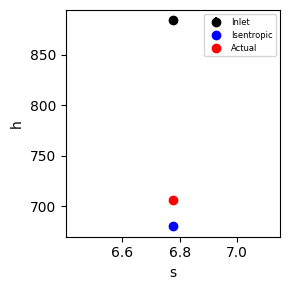

P interp bounds: 2.000,5.000
interp h@2.529: 692.950±0.000
interp h@2.529: 692.484±0.000
→ 692.868±0.000
P interp bounds: 2.000,5.000
interp h@2.529: 505.989±0.000
interp h@2.529: 503.866±0.000
→ 505.615±0.000
P interp bounds: 2.000,5.000
interp h@2.529: 6.868±0.000
interp h@2.529: 6.602±0.000
→ 6.821±0.000
P interp bounds: 2.000,5.000
interp h@2.529: 525.762±0.000
interp h@2.529: 532.724±0.000
→ 526.989±0.000
P interp bounds: 2.000,5.000
interp h@2.529: 9.987±0.000
interp h@2.529: 24.705±0.000
→ 12.581±0.000
P interp bounds: 2.000,5.000
interp h@2.529: 0.787±0.000
interp h@2.529: 0.788±0.000
→ 0.787±0.000
P interp bounds: 2.000,5.000
interp h@2.529: 1.078±0.000
interp h@2.529: 1.084±0.000
→ 1.079±0.000


In [46]:
# Stream 13
stream_num = 13; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','h']; 
P13,P13err= P13_d,0; h12, h12err = df.loc[idx-1, ['h','herr']]; s12, s12err = df.loc[idx-1, ['s','serr']]; h13,h13err=get_h_from_eta([P13, P13err],[h12,h12err],[s12, s12err],eta_T1,'Turbine',Thermodata_filename);  
df.loc[idx, ['P','Perr','h','herr']] = [P13, P13err, h13, h13err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

In [47]:
# Stream 14
stream_num = 14; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','T']
P14, P14err, T14, T14err = P14_d, 0, T_max, 0 
df.loc[idx, ['P','Perr','T','Terr']] = [P14, P14err, T14, T14err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

P interp bounds: 2.000,5.000
interp T@2.529: 635.435±0.000
interp T@2.529: 634.163±0.000
→ 635.210±0.000
P interp bounds: 2.000,5.000
interp T@2.529: 881.977±0.000
interp T@2.529: 883.248±0.000
→ 882.201±0.000
P interp bounds: 2.000,5.000
interp T@2.529: 7.094±0.000
interp T@2.529: 6.830±0.000
→ 7.048±0.000
P interp bounds: 2.000,5.000
interp T@2.529: 578.848±0.000
interp T@2.529: 585.589±0.000
→ 580.036±0.000
P interp bounds: 2.000,5.000
interp T@2.529: 8.141±0.000
interp T@2.529: 20.141±0.000
→ 10.255±0.000
P interp bounds: 2.000,5.000
interp T@2.529: 0.824±0.000
interp T@2.529: 0.825±0.000
→ 0.824±0.000
P interp bounds: 2.000,5.000
interp T@2.529: 1.113±0.000
interp T@2.529: 1.117±0.000
→ 1.114±0.000


P interp bounds: 0.500,1.000
interp s@0.506: 624.481±0.000
interp s@0.506: 692.587±0.000
→ 625.365±0.000
Turbine: h_in=882.201±0.000, h_iso=625.365±0.000, eta=0.870 → h_out=658.753±0.000


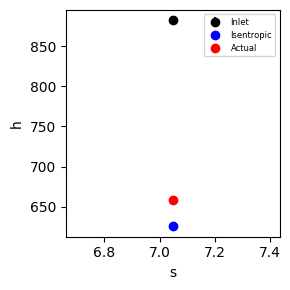

P interp bounds: 0.500,1.000
interp h@0.506: 648.616±0.000
interp h@0.506: 648.586±0.000
→ 648.615±0.000
P interp bounds: 0.500,1.000
interp h@0.506: 472.234±0.000
interp h@0.506: 471.864±0.000
→ 472.229±0.000
P interp bounds: 0.500,1.000
interp h@0.506: 7.197±0.000
interp h@0.506: 6.997±0.000
→ 7.194±0.000
P interp bounds: 0.500,1.000
interp h@0.506: 506.280±0.000
interp h@0.506: 507.468±0.000
→ 506.295±0.000
P interp bounds: 0.500,1.000
interp h@0.506: 2.681±0.000
interp h@0.506: 5.352±0.000
→ 2.716±0.000
P interp bounds: 0.500,1.000
interp h@0.506: 0.775±0.000
interp h@0.506: 0.776±0.000
→ 0.775±0.000
P interp bounds: 0.500,1.000
interp h@0.506: 1.064±0.000
interp h@0.506: 1.065±0.000
→ 1.064±0.000


In [48]:
# Stream 15
stream_num = 15; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','h']; 
P15,P15err= P15_d,0; h14, h14err = df.loc[idx-1, ['h','herr']]; s14, s14err = df.loc[idx-1, ['s','serr']]; h15,h15err=get_h_from_eta([P15, P15err],[h14,h14err],[s14, s14err],eta_T2,'Turbine',Thermodata_filename);  
df.loc[idx, ['P','Perr','h','herr']] = [P15, P15err, h15, h15err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

In [49]:
# Stream 16
stream_num = 16; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','T']
P16, P16err, T16, T16err = P16_d, 0, T_max, 0 
df.loc[idx, ['P','Perr','T','Terr']] = [P16, P16err, T16, T16err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

P interp bounds: 0.500,1.000
interp T@0.506: 636.086±0.000
interp T@0.506: 635.863±0.000
→ 636.083±0.000
P interp bounds: 0.500,1.000
interp T@0.506: 881.349±0.000
interp T@0.506: 881.558±0.000
→ 881.352±0.000
P interp bounds: 0.500,1.000
interp T@0.506: 7.493±0.000
interp T@0.506: 7.294±0.000
→ 7.490±0.000
P interp bounds: 0.500,1.000
interp T@0.506: 575.554±0.000
interp T@0.506: 576.648±0.000
→ 575.568±0.000
P interp bounds: 0.500,1.000
interp T@0.506: 2.046±0.000
interp T@0.506: 4.084±0.000
→ 2.072±0.000
P interp bounds: 0.500,1.000
interp T@0.506: 0.823±0.000
interp T@0.506: 0.824±0.000
→ 0.823±0.000
P interp bounds: 0.500,1.000
interp T@0.506: 1.111±0.000
interp T@0.506: 1.112±0.000
→ 1.111±0.000


P interp bounds: 0.101,0.200
interp s@0.102: 559.918±0.000
interp s@0.102: 679.141±0.000
→ 560.310±0.000
Turbine: h_in=881.352±0.000, h_iso=560.310±0.000, eta=0.870 → h_out=602.046±0.000


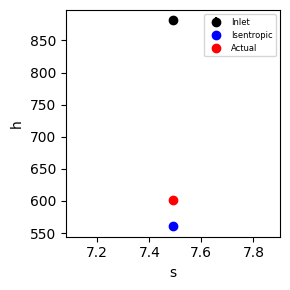

P interp bounds: 0.101,0.200
interp h@0.102: 594.917±0.000
interp h@0.102: 594.920±0.000
→ 594.917±0.000
P interp bounds: 0.101,0.200
interp h@0.102: 431.224±0.000
interp h@0.102: 431.157±0.000
→ 431.223±0.000
P interp bounds: 0.101,0.200
interp h@0.102: 7.564±0.000
interp h@0.102: 7.368±0.000
→ 7.563±0.000
P interp bounds: 0.101,0.200
interp h@0.102: 485.087±0.000
interp h@0.102: 485.288±0.000
→ 485.088±0.000
P interp bounds: 0.101,0.200
interp h@0.102: 0.593±0.000
interp h@0.102: 1.171±0.000
→ 0.595±0.000
P interp bounds: 0.101,0.200
interp h@0.102: 0.763±0.000
interp h@0.102: 0.763±0.000
→ 0.763±0.000
P interp bounds: 0.101,0.200
interp h@0.102: 1.050±0.000
interp h@0.102: 1.051±0.000
→ 1.050±0.000


In [50]:
# Stream 17
stream_num = 17; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','h']; 
P17,P17err= P17_d,0; h16, h16err = df.loc[idx-1, ['h','herr']]; s16, s16err = df.loc[idx-1, ['s','serr']]; h17,h17err=get_h_from_eta([P17, P17err],[h16,h16err],[s16, s16err],eta_T3,'Turbine',Thermodata_filename);  
df.loc[idx, ['P','Perr','h','herr']] = [P17, P17err, h17, h17err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

In [51]:
# Stream 18
stream_num = 18; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','T']; 
P18, P18err, T18, T18err = P18_d, 0, T_exhaust, 0 
df.loc[idx, ['P','Perr','T','Terr']] = [P18, P18err, T18, T18err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

P interp bounds: 0.101,0.200
interp T@0.102: 266.780±0.000
interp T@0.102: 266.634±0.000
→ 266.780±0.000
P interp bounds: 0.101,0.200
interp T@0.102: 373.865±0.000
interp T@0.102: 373.727±0.000
→ 373.865±0.000
P interp bounds: 0.101,0.200
interp T@0.102: 7.085±0.000
interp T@0.102: 6.889±0.000
→ 7.084±0.000
P interp bounds: 0.101,0.200
interp T@0.102: 386.930±0.000
interp T@0.102: 387.130±0.000
→ 386.931±0.000
P interp bounds: 0.101,0.200
interp T@0.102: 0.946±0.000
interp T@0.102: 1.868±0.000
→ 0.949±0.000
P interp bounds: 0.101,0.200
interp T@0.102: 0.723±0.000
interp T@0.102: 0.724±0.000
→ 0.723±0.000
P interp bounds: 0.101,0.200
interp T@0.102: 1.011±0.000
interp T@0.102: 1.012±0.000
→ 1.011±0.000


Final T=373.000±0.000
Total Q=-228.208708 ± 0.000000


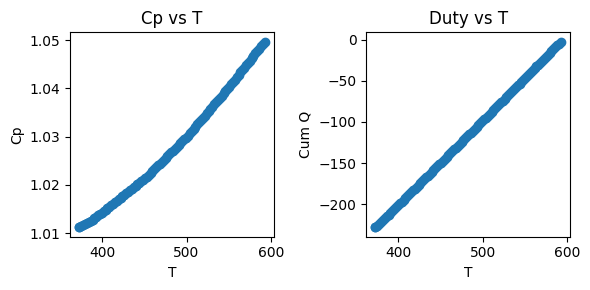

P interp bounds: 5.000,10.000
interp T@6.320: 1.079±0.000
interp T@6.320: 1.149±0.000
→ 1.097±0.000
P interp bounds: 5.000,10.000
interp T@6.320: 1.078±0.000
interp T@6.320: 1.148±0.000
→ 1.097±0.000
P interp bounds: 5.000,10.000
interp T@6.320: 1.078±0.000
interp T@6.320: 1.148±0.000
→ 1.097±0.000
P interp bounds: 5.000,10.000
interp T@6.320: 1.078±0.000
interp T@6.320: 1.148±0.000
→ 1.097±0.000
P interp bounds: 5.000,10.000
interp T@6.320: 1.078±0.000
interp T@6.320: 1.147±0.000
→ 1.096±0.000
P interp bounds: 5.000,10.000
interp T@6.320: 1.078±0.000
interp T@6.320: 1.147±0.000
→ 1.096±0.000
P interp bounds: 5.000,10.000
interp T@6.320: 1.078±0.000
interp T@6.320: 1.147±0.000
→ 1.096±0.000
P interp bounds: 5.000,10.000
interp T@6.320: 1.077±0.000
interp T@6.320: 1.146±0.000
→ 1.095±0.000
P interp bounds: 5.000,10.000
interp T@6.320: 1.077±0.000
interp T@6.320: 1.146±0.000
→ 1.095±0.000
P interp bounds: 5.000,10.000
interp T@6.320: 1.077±0.000
interp T@6.320: 1.146±0.000
→ 1.095±0.000


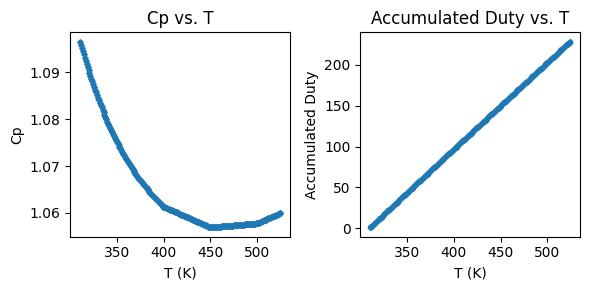

P interp bounds: 5.000,10.000
interp T@6.320: 373.380±0.000
interp T@6.320: 369.071±0.000
→ 372.242±0.000
P interp bounds: 5.000,10.000
interp T@6.320: 526.619±0.000
interp T@6.320: 525.430±0.000
→ 526.305±0.000
P interp bounds: 5.000,10.000
interp T@6.320: 6.303±0.000
interp T@6.320: 6.097±0.000
→ 6.249±0.000
P interp bounds: 5.000,10.000
interp T@6.320: 468.386±0.000
interp T@6.320: 481.789±0.000
→ 471.925±0.000
P interp bounds: 5.000,10.000
interp T@6.320: 32.705±0.000
interp T@6.320: 64.099±0.000
→ 40.995±0.000
P interp bounds: 5.000,10.000
interp T@6.320: 0.751±0.000
interp T@6.320: 0.755±0.000
→ 0.752±0.000
P interp bounds: 5.000,10.000
interp T@6.320: 1.055±0.000
interp T@6.320: 1.074±0.000
→ 1.060±0.000


In [52]:
# Stream 11
stream_num = 11; idx = stream_num - 1 
df.loc[idx,['Definer_1','Definer_2']] = ['P','T']; 
P11, P11err = P11_d, 0;
P17, P17err, T17, T17err = df.loc[17-1,['P', 'Perr','T','Terr']]; T18, T18err = df.loc[18-1,['T','Terr']]; HEX_Duty, HEX_Dutyerr = get_Duty([P17, P17err], [T17, T17err], [T18, T18err], m_CO2info,Thermodata_filename); Q_recuped = HEX_Duty;
P10, P10err, T10, T10err = df.loc[10-1,['P','Perr','T','Terr']];T11, T11err = get_Tout([P10, P10err], [T10, T10err], [-1*HEX_Duty, HEX_Dutyerr],  m_CO2info,Thermodata_filename)
df.loc[idx, ['P','Perr','T','Terr']] = [P11, P11err, T11, T11err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

## Exergy Analysis

### Stream Exergy

In [53]:
df['ex'] = df['h'] - Ts * df['s']; df['exerr'] = np.sqrt(df['herr']**2 + (Ts * df['serr'])**2)
for idx, row in dfc.iterrows():
    start_val = row['Start_stream']; end_val   = row['End_stream']
    start_ex,     start_ex_err = get_solved_state(start_val, df, 'ex'); end_ex,       end_ex_err   = get_solved_state(end_val,   df, 'ex')
    change_ex, change_ex_err = subtract_fun(end_ex, end_ex_err, start_ex, start_ex_err)
    dfc.loc[idx, ['Start_ex', 'Start_ex_err','End_ex','End_ex_err','Change_ex','Change_ex_err']] = (start_ex, start_ex_err, end_ex, end_ex_err,change_ex, change_ex_err)

### Component Exergy Changes

Final T=853.000±0.000
Total Q=357.367178 ± 0.000000


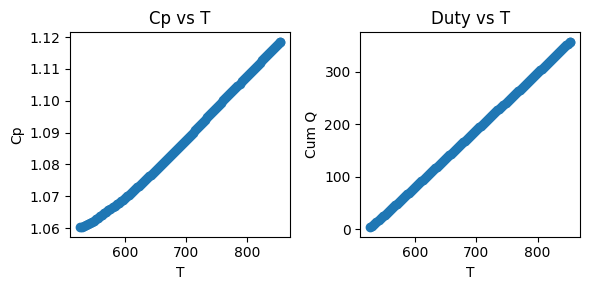

Final T=853.000±0.000
Total Q=175.560292 ± 0.000000


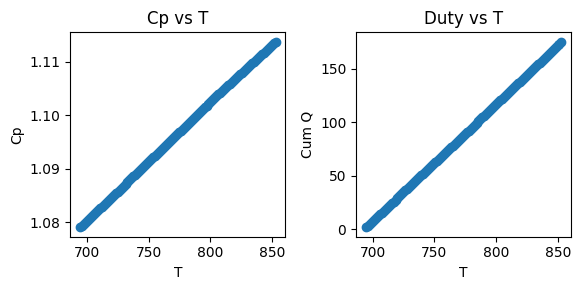

Final T=853.000±0.000
Total Q=222.313628 ± 0.000000


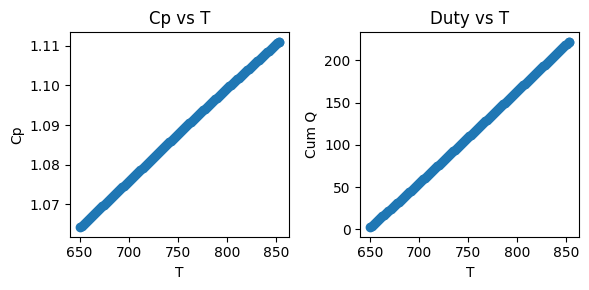

In [54]:
for idx, row in dfc.iterrows():
    start = row['Start_stream']; end = row['End_stream']
    for src_col, tgt_col, tgt_err_col in [('Fuel_exergy',    'EX_F',   'EX_F_err'),('Product_exergy', 'EX_P',   'EX_P_err')]:
        ex_type = str(row[src_col]).lower() 
        if ex_type == 'w':
            w, werr = W_fun(df, start, end); dfc.at[idx, tgt_col], dfc.at[idx, tgt_err_col] = w, werr
        elif ex_type == 'q':
            q, qerr = Q_fun(df, start, end, m_CO2info, Thermodata_filename); dfc.at[idx, tgt_col], dfc.at[idx, tgt_err_col] = q, qerr
        elif ex_type == 'start_ex':
            dfc.at[idx, tgt_col], dfc.at[idx, tgt_err_col] = row['Start_ex'], row['Start_ex_err']
        elif ex_type == 'end_ex':
            dfc.at[idx, tgt_col], dfc.at[idx, tgt_err_col] = row['End_ex'], row['End_ex_err']
        elif ex_type == 'change_ex':
            dfc.at[idx, tgt_col], dfc.at[idx, tgt_err_col] = row['Change_ex'], row['Change_ex_err']
        else:
            dfc.at[idx, tgt_col], dfc.at[idx, tgt_err_col] = np.nan, np.nan
cold_tube_num = dfc.index[dfc['Component'] == 'TUBE_T'][0]; hot_tube_num  = dfc.index[dfc['Component'] == 'TUBE_LS'][0]; hex_num = dfc.index[dfc['Component'] == 'HEX'][0]
hot_ex     = dfc.at[hot_tube_num, 'Change_ex']; hot_ex_err = dfc.at[hot_tube_num, 'Change_ex_err']; cold_ex    = dfc.at[cold_tube_num, 'Change_ex']; cold_ex_err= dfc.at[cold_tube_num, 'Change_ex_err']
dfc.loc[hex_num, ['EX_F','EX_F_err','EX_P','EX_P_err']] = [-hot_ex,-hot_ex_err, cold_ex, cold_ex_err]

In [55]:
for idx, row in dfc.iterrows():
    ex_d, ex_d_err = subtract_fun(abs(row['EX_F']), abs(row['EX_F_err']), abs(row['EX_P']), abs(row['EX_P_err']))
    if ex_d < 0:
        ex_d, ex_d_err = 0.0, ex_d_err
    dfc.loc[idx, ['EX_D', 'EX_D_err']] = (ex_d, ex_d_err)

mask_P = dfc['EX_P'].notna(); EX_P_T = abs(dfc.loc[mask_P, 'EX_P']).sum(); EX_P_T_err = np.sqrt((dfc.loc[mask_P, 'EX_P_err']**2).sum())

mask_F = dfc['EX_F'].notna(); EX_F_T = abs(dfc.loc[mask_F, 'EX_F']).sum(); EX_F_T_err = np.sqrt((dfc.loc[mask_F, 'EX_F_err']**2).sum())

mask_D = dfc['EX_D'].notna(); EX_D_T = abs(dfc.loc[mask_D, 'EX_D']).sum(); EX_D_T_err = np.sqrt((dfc.loc[mask_D, 'EX_D_err']**2).sum())

dfc.loc[mask_D, ['EX_D_ratio', 'EX_D_ratio_err']] = [divide_fun(d, de, EX_D_T, EX_D_T_err) for d, de in zip(dfc.loc[mask_D, 'EX_D'], dfc.loc[mask_D, 'EX_D_err'])]

In [56]:
W_C1   = abs(dfc.loc[dfc['Component']=='C1',  'EX_F'].iloc[0])
W_C2   = abs(dfc.loc[dfc['Component']=='C2',  'EX_F'].iloc[0])
W_C3   = abs(dfc.loc[dfc['Component']=='C3',  'EX_F'].iloc[0])
W_C4   = abs(dfc.loc[dfc['Component']=='C4',  'EX_F'].iloc[0])
W_C    = W_C1 + W_C2 + W_C3 + W_C4

In [57]:
W_T1   = abs(dfc.loc[dfc['Component']=='T1',  'EX_P'].iloc[0])
W_T2   = abs(dfc.loc[dfc['Component']=='T2',  'EX_P'].iloc[0])
W_T3   = abs(dfc.loc[dfc['Component']=='T3',  'EX_P'].iloc[0])
W_T    = W_T1 + W_T2 + W_T3

In [58]:
Q_HE   = dfc.loc[dfc['Component'] == 'HE', 'EX_F'].abs().sum()
Q_F = Q_HE/eta_burner_Gulen

In [59]:
Q_ICL1 = abs(dfc.loc[dfc['Component']=='ICL1',  'Change_ex'].iloc[0])
Q_ICL2 = abs(dfc.loc[dfc['Component']=='ICL2',  'Change_ex'].iloc[0])
Q_ICL3 = abs(dfc.loc[dfc['Component']=='ICL3',  'Change_ex'].iloc[0])
Q_ICL4 = abs(dfc.loc[dfc['Component']=='ICL4',  'Change_ex'].iloc[0])
Q_ICL = Q_ICL1 + Q_ICL2 + Q_ICL3 + Q_ICL4

In [60]:
RTE_Liu = W_T/(W_C + eta_gen_avg*Q_HE)
RTE_Gulen = W_T/(W_C + eta_gen_avg*Q_F)
RTE_alt_F = (W_T-eta_gen_avg*Q_F)/W_C
RTE_alt_HE = (W_T-eta_gen_avg*Q_HE)/W_C

In [61]:
PEE = W_T/((W_C/eta_grid_avg) + Q_F)
ER = W_C/W_T
HR = W_T/Q_F

In [62]:
EXD_C    = dfc.loc[dfc['Component'].isin(['C1','C2','C3', 'C4']), 'EX_D'].sum();   EXDR_C  = EXD_C/EX_D_T
EXD_T    = dfc.loc[dfc['Component'].isin(['T1','T2', 'T3']),   'EX_D'].sum();   EXDR_T  = EXD_T/EX_D_T
EXD_HS   = dfc.loc[dfc['Component'].isin(['HS']),  'EX_D'].sum();   EXDR_HS = EXD_HS/EX_D_T
EXD_LS   = dfc.loc[dfc['Component'].isin(['LS']),  'EX_D'].sum();   EXDR_LS = EXD_LS/EX_D_T
EXD_HE   = dfc.loc[dfc['Component'].isin(['HE']),       'EX_D'].sum();   EXDR_HE = EXD_HE/EX_D_T
EXD_HEX  = dfc.loc[dfc['Component'].isin(['HEX']),      'EX_D'].sum();   EXDR_HEX= EXD_HEX/EX_D_T

In [63]:
EX_EFF = EX_P_T/EX_F_T

## Storage Analysis

### HS Storage

In [64]:
# HS wells indexing
HS_num = dfc.index[dfc['Component'] == 'HS'][0]; HS_start = dfc['Start_stream'][HS_num]; HS_end = dfc['End_stream'][HS_num];
HS_inj_well = df.loc[df['Stream_#'] == HS_start]; HS_prod_well = df.loc[df['Stream_#'] == HS_end];

Interpolated in P and T (Sheet: Sheet1)
  P bounds and viscosities at T bounds:
    P=7.5: T=300.0→19.91, T=350.0→21.97
    P=10.0: T=300.0→20.57, T=350.0→22.46
  Final interpolation at P=8.205325, T=313.0: 20.619335654
Temperature = 288.000 +/- 0.000 K at depth 200.0 +/- 0.0 m
P exact: 5.000
interp T@5.000: 61.382±0.000
P interp bounds: 5.000,10.000
interp T@7.000: 61.382±0.000
interp T@7.000: 122.962±0.000
→ 86.014±0.000
P interp bounds: 5.000,10.000
interp T@8.396: 61.382±0.000
interp T@8.396: 122.962±0.000
→ 103.207±0.000
P interp bounds: 5.000,10.000
interp T@8.396: 61.382±0.000
interp T@8.396: 122.962±0.000
→ 103.207±0.000
Final iteration results:
  P_guess     = 8.395996 MPa
  P_calc      = 8.395996 MPa
  Error       = -1.78e-15 MPa
  rho_bottom  = 103.206761 kg/m³
  rho_avg     = 97.283898 kg/m³


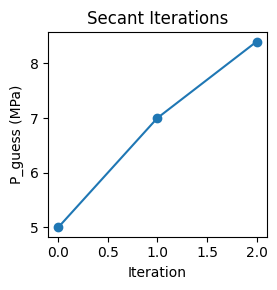

Interpolated in P and T (Sheet: Sheet1)
  P bounds and viscosities at T bounds:
    P=7.5: T=250.0→17.9, T=300.0→19.91
    P=10.0: T=250.0→18.88, T=300.0→20.57
  Final interpolation at P=8.395996008444776, T=288.0: 19.691667943608845
P interp bounds: 5.000,10.000
interp T@8.396: 195.141±0.000
interp T@8.396: 184.720±0.000
→ 188.063±0.000
P interp bounds: 5.000,10.000
interp T@8.396: 276.619±0.000
interp T@8.396: 266.071±0.000
→ 269.455±0.000
P interp bounds: 5.000,10.000
interp T@8.396: 5.670±0.000
interp T@8.396: 5.437±0.000
→ 5.512±0.000
P interp bounds: 5.000,10.000
interp T@8.396: 347.900±0.000
interp T@8.396: 361.780±0.000
→ 357.327±0.000
P interp bounds: 5.000,10.000
interp T@8.396: 61.382±0.000
interp T@8.396: 122.962±0.000
→ 103.207±0.000
P interp bounds: 5.000,10.000
interp T@8.396: 0.730±0.000
interp T@8.396: 0.742±0.000
→ 0.738±0.000
P interp bounds: 5.000,10.000
interp T@8.396: 1.094±0.000
interp T@8.396: 1.181±0.000
→ 1.153±0.000
Interpolated in P and T (Sheet: Sheet1)
  P

In [65]:
# HS injection well
P_HS_inj = HS_inj_well['P'].iloc[0]; T_HS_inj = HS_inj_well['T'].iloc[0];
p_HS_inj = HS_inj_well['p'].iloc[0]; vis_HS_inj = get_vis(P = P_HS_inj, T = T_HS_inj, near_critical_point = 'N', filename=f'../Input_Spreadsheets/Viscositydata_{Working_fluid}'); vis_HS_inj = vis_HS_inj*(1e-6)

# HS 
T_HS, T_HSerr = get_T_from_depth(z_HS, 0, Ts, G)
P_HS, pavg_HS_inj, p_HS = find_P_bottom_secant(T_aquifer=T_HS,z_aquifer=z_HS,Ptop=P_HS_inj,g=g,fric_rate=gradP, rho_top=p_HS_inj, thermo_file=Thermodata_filename, P0=5, P1=7, tol=1e-6,max_iter=500)
vis_HS = get_vis(P = P_HS, T = T_HS, near_critical_point = 'N',filename= f'../Input_Spreadsheets/Viscositydata_{Working_fluid}'); vis_HS = vis_HS*(1e-6); visavg_HS_inj = 0.5*(vis_HS_inj + vis_HS)
n_rows = df.shape[0];idx = n_rows; df.loc[idx,['Definer_1','Definer_2']] = ['P','T']; df.loc[idx, ['P','Perr','T','Terr']] = [P_HS, 0, T_HS, 0]; get_remaining_thermo_vars(idx, df, Thermodata_filename); 
df.loc[idx,['Stream_#','From_component', 'To_component']] = [HS_start+0.5, 'HS_inj_well', 'HS_prod_well'];

# HS production well
P_HS_prod = HS_prod_well['P'].iloc[0]; T_HS_prod = HS_prod_well['T'].iloc[0]; p_HS_prod = HS_prod_well['p'].iloc[0]; vis_HS_prod = get_vis(P = P_HS_prod, T = T_HS_prod, near_critical_point = 'N', filename=f'../Input_Spreadsheets/Viscositydata_{Working_fluid}'); vis_HS_prod = vis_HS_prod*(1e-6)
pavg_HS_prod = 0.5*(p_HS_prod + p_HS); visavg_HS_prod = 0.5*(vis_HS_prod + vis_HS)

## Frictional Analysis

### HS Injection Well

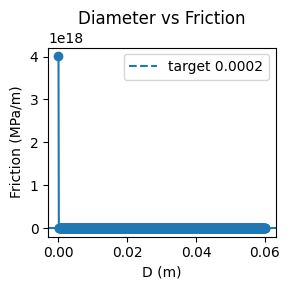

Final diameter: 0.060110 m
Final friction: 0.000198 MPa/m


In [66]:
D0_HS_inj_well = find_pipe_diameter(friction_rate=gradP,rho_avg=pavg_HS_inj,mass_rate=m_CO2,mu_avg=visavg_HS_inj,D_guess=1e-5,roughness=r, D_step=1e-4)
dfDm_HS_inj_well = batch_opt_pipe_diameter(friction_rate=gradP,rho_avg=pavg_HS_inj,mu_avg=visavg_HS_inj,D_start=1e-5,roughness=r, D_step=1e-4)

### HS Production Well

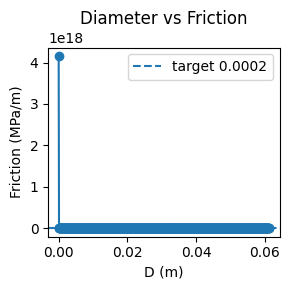

Final diameter: 0.061310 m
Final friction: 0.000200 MPa/m


In [67]:
D0_HS_prod_well = find_pipe_diameter(friction_rate=gradP,rho_avg=pavg_HS_prod,mass_rate=m_CO2,mu_avg=visavg_HS_prod,D_guess=1e-5,roughness=r, D_step=1e-4)
dfDm_HS_prod_well = batch_opt_pipe_diameter(friction_rate=gradP,rho_avg=pavg_HS_prod,mu_avg=visavg_HS_prod,D_start=1e-5,roughness=r, D_step=1e-4)

## Quasi-Steady-State Analysis

In [68]:
# Steady state parameters
P_HS_ss = P_HS; p_HS_ss = p_HS; 

In [69]:
#Dispatch parameters
PPA = Nameplate_capacity*CF_avg; #PPA derated by mean capacity factor of wind farm
beta_w_MPa = beta_w*(1e6); beta_p_MPa = beta_p*(1e6) #Pa-1 to MPa-1
SystemPrices_arr = SystemPrices_arr*0.001; #£/MWh to £/kWh
CapacityFactors_arr = np.repeat(hourly_cf, 2); assert CapacityFactors_arr.shape[0] == 48, "Expected 48 half‐hourly capacity factors"; #Capacity factor per settlement period
Generation_arr = Nameplate_capacity*CapacityFactors_arr #Generation per settlement period kW

In [70]:
# Full-cycle pressure swing 
M = PPA/min(W_T,W_C)
deltaP_HS_full_cycle = tol_P_storage*P_HS_ss*(1e6); V_HS = M/(deltaP_HS_full_cycle * p_HS_ss * (beta_p + beta_w)); V_HS_ss = V_HS;
E_V =W_T*(beta_p + beta_w)*(p_HS_ss*deltaP_HS_full_cycle)

In [71]:
from operategeobatteryairfun import operate_geobattery_air
initialconditions, timeseries = operate_geobattery_air(
    Vrock_HS                = Vrock_HS,                  # m³ rock in HS
    phi                     = por,                   # porosity (−)
    b_pore                  = beta_p_MPa,                   # rock compressibility (1/MPa)
    b_brine                 = beta_w_MPa,                  # brine compressibility (1/MPa)
    z_HS                    = z_HS,                 # m depth of HS
    P_HS_ss                 = P_HS_ss,                   # MPa steady HS pressure
    rho_air_HS_ss           = p_HS_ss,                  # kg/m³ CO₂ @ 40 MPa
    rho_brine_0             = p_w,                 # kg/m³ surface brine density
    T_HS                    = T_HS,                 # K reservoir temperature HS
    thermo_file             = Thermodata_filename,         # path to EOS file
    stable_power_requirement= PPA,                  # kW constant load
    W_turbine_T             = W_T,                    # kWh per kg CO₂ through turbine
    W_compressor_T          = W_C,                    # kWh per kg CO₂ through compressor
    power_rating            = PPA,                 # kW max charge/discharge
    dt                      = 1.0,                    # hr per timestep
    price                   = SystemPrices_arr,    # $/kWh
    generation              = Generation_arr,# kW available
    pressure_tolerance      = tol_P_storage,                  # ±1.5% allowable swing
    pressure_buffer_fraction= 0.25                    # buffer fraction
)

dfQSS = pd.DataFrame(timeseries)
dfQSS0 = pd.DataFrame(initialconditions)

In [72]:
dfQSS.columns

Index(['mode', 'residual', 'charge', 'charge_mass_air',
       'pressure_constraint_mass_air', 'power_constraint', 'deltaM_air_HS',
       'M_air_HS', 'M_br_HS', 'pore_gain_HS', 'extra_cap_HS',
       'brine_shrink_HS', 'Vp_HS', 'V_HS_air', 'Vbr_HS', 'volfrac_HS_air',
       'volfrac_HS_br', 'massfrac_HS_air', 'massfrac_HS_br', 'deltaV_HS_br',
       'P_HS', 'diffP_HS', 'QSS_P_drift_HS', 'errorP_HS', 'purchase', 'sale',
       'revenue', 'expense', 'cashflow', 'balance', 'generation', 'demand',
       'price', 'rho_air_HS', 'rho_br_HS', 'b_eff', 'residual_mass',
       'constraint'],
      dtype='object')

# Outputs

In [73]:
from pathlib import Path
project_root = Path.cwd().parent  
base_dir  = project_root / simulation_name
data_dir  = base_dir / f"{simulation_name}_data"
fig_dir   = base_dir / f"{simulation_name}_figures"
for d in (base_dir, data_dir, fig_dir):
    d.mkdir(parents=True, exist_ok=True)
print(f"Results folders for simulation created: {base_dir}")

Results folders for simulation created: C:\Users\Sunshine Tanphiphat\OneDrive\Desktop\Sunshine-Academics\Sunshine-Oxford\Oxford-EnergySystems-Dissertation\OXF-Dissertation-Simulation-CAES - Copy\CAESUK


## Spreadsheet Writing

In [74]:
data_dir.mkdir(parents=True, exist_ok=True)

### KPIs

In [75]:
metrics = {'W_C1':    W_C1,   'W_C2':    W_C2,   'W_C3':    W_C3,  'W_C4': W_C4, 'W_C':    W_C,
           'W_T1':    W_T1,   'W_T2':    W_T2,   'W_T3': W_T3, 'W_T':     W_T,
           'Q_HE':    Q_HE, 'Q_F': Q_F,
           'Q_ICL1': Q_ICL1, 'Q_ICL2': Q_ICL2, 'Q_ICL3':Q_ICL3, 'Q_ICL': Q_ICL,
           'RTE_Liu':     RTE_Liu,    'RTE_Gulen': RTE_Gulen, 'RTE_alt_F': RTE_alt_F, 'RTE_alt_HE': RTE_alt_HE,
           'PEE': PEE, 
           'ER': ER, 'HR': HR,
           'EXDR_C':  EXDR_C, 'EXDR_T':  EXDR_T, 'EXDR_HS': EXDR_HS,  'EXDR_LS': EXDR_LS, 'EXDR_HE': EXDR_HE,'EXDR_HEX': EXDR_HEX,
           'EX_F_T': EX_F_T, 'EX_P_T': EX_P_T, 'EX_D_T': EX_D_T, 'EX_EFF': EX_EFF,
           
           'P_HS_ss': P_HS_ss, 'T_HS' : T_HS, 'p_HS_ss': p_HS_ss,'V_HS_ss': V_HS,
           'deltaP_HS_fullcycle': deltaP_HS_full_cycle, 'E_V': E_V,
           
           'p_HS_inj_avg': pavg_HS_inj, 'vis_HS_inj_avg': visavg_HS_inj, 'HS_inj_drop': gradP*z_HS, 'HS_inj_D0': D0_HS_inj_well,

           'max_purchase': dfQSS['purchase'].max(), 'max_purchase_hr': dfQSS['purchase'].idxmax(),
           'min_purchase': dfQSS['purchase'].min(), 'min_purchase_hr': dfQSS['purchase'].idxmin(),
           'max_cashflow': dfQSS['cashflow'].max(), 'max_cashflow_hr': dfQSS['cashflow'].idxmax(),
           'min_cashflow': dfQSS['cashflow'].min(), 'min_cashflow_hr': dfQSS['cashflow'].idxmin(),
           'max_balance': dfQSS['balance'].max(), 'max_balance_hr': dfQSS['balance'].idxmax(),
           'min_balance': dfQSS['balance'].min(), 'min_balance_hr': dfQSS['balance'].idxmin(),
           'max_charge': dfQSS['charge'].max(), 'max_charge_hr': dfQSS['charge'].idxmax(),
           'max_discharge': abs(dfQSS['charge'].min()), 'max_discharge_hr': dfQSS['charge'].idxmin(),
           'max_charge_mass_air': dfQSS['charge_mass_air'].max(), 'max_charge_hr': dfQSS['charge_mass_air'].idxmax(),
           'max_discharge_mass_air': abs(dfQSS['charge_mass_air'].min()), 'max_discharge_hr': dfQSS['charge_mass_air'].idxmin(),
           'max_P_HS_deviation': dfQSS['diffP_HS'].max(), 'max_P_HS_deviation_hr': dfQSS['diffP_HS'].idxmax(),
           'most_frequent_constraint':dfQSS['constraint'].value_counts().idxmax(),
           'max_HS_brine_content': dfQSS['Vbr_HS'].max(), 'max_HS_brine_content_hr': dfQSS['Vbr_HS'].idxmax(),
}
dfKPI = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value']); dfKPI.index.name = 'Metric'
dfKPI.to_excel(data_dir / f"{simulation_name}_dfKPI.xlsx", index=True )

### Streams

In [76]:
df = select_value_columns(df)
df.to_excel(   data_dir / f"{simulation_name}_df.xlsx",     index=False )

### Components

In [77]:
dfc = select_value_columns(dfc)
dfc.to_excel(  data_dir / f"{simulation_name}_dfc.xlsx",    index=False )

### Wells

In [78]:
dfDm_HS_inj_well = select_value_columns(dfDm_HS_inj_well); dfDm_HS_inj_well.to_excel(data_dir/f"{simulation_name}_wells.xlsx",index=False, sheet_name = "HS_inj")
dfDm_HS_prod_well = select_value_columns(dfDm_HS_prod_well); dfDm_HS_prod_well.to_excel(data_dir/f"{simulation_name}_wells.xlsx",index=False, sheet_name = "HS_prod")

### Dispatch

In [79]:
dftransient = select_value_columns(dfQSS)
dftransient.to_excel(  data_dir / f"{simulation_name}_dfQSS.xlsx", index=False )

## Data Display

In [80]:
print(f"df, dfc, and dfKPI, data saved to: {data_dir}")

df, dfc, and dfKPI, data saved to: C:\Users\Sunshine Tanphiphat\OneDrive\Desktop\Sunshine-Academics\Sunshine-Oxford\Oxford-EnergySystems-Dissertation\OXF-Dissertation-Simulation-CAES - Copy\CAESUK\CAESUK_data


In [81]:
display(select_value_columns(dfKPI))

Value
Metric                                
W_C1                        118.009424
W_C2                        148.190747
W_C3                        131.798925
W_C4                        146.385096
W_C                         544.384192
...                                ...
max_P_HS_deviation            0.016456
max_P_HS_deviation_hr               42
most_frequent_constraint      residual
max_HS_brine_content      27380.500439
max_HS_brine_content_hr             39

[65 rows x 1 columns]

In [82]:
display(select_value_columns(df))

Stream_# Orientation From_component  To_component Definer_1 Definer_2  \
0        1.0  Horizontal             LS            C1         P         T   
1        2.0  Horizontal             C1          ICL1         P         h   
2        3.0  Horizontal           ICL1            C2         P         T   
3        4.0  Horizontal             C2          ICL2         P         h   
4        5.0  Horizontal           ICL2            C3         P         T   
5        6.0  Horizontal             C3          ICL3         P         h   
6        7.0  Horizontal           ICL3            C4         P         T   
7        8.0  Horizontal             C4          ICL5         P         h   
8        9.0    Vertical           ICL5            HS         P         T   
9       10.0    Vertical             HS           HEX         P         h   
10      11.0  Horizontal            HEX            HE         P         T   
11      12.0  Horizontal             HE            T1         P         T   
12      13.0  Horizontal             T1            HE         P         h   
13      14.0  Horizontal            HE1            T2         P         T   
14      15.0  Horizontal             T2            HE         P         h   
15      16.0  Horizontal             HE            T3         P         T   
16      17.0  Horizontal             T3           HEX         P         h   
17      18.0  Horizontal            HEX            LS         P         T   
18       9.5         NaN    HS_inj_well  HS_prod_well         P         T   

           P           T           e           h         s           v  \
0   0.101325  283.000000  201.942364  283.141894  6.806423  337.370000   
1   0.304325  400.160325  286.203012  401.151317  6.867977  400.987840   
2   0.304325  313.000000  223.119189  312.912826  6.619842  355.029533   
3   0.912325  459.388418  328.877560  461.103573  6.665034  430.229609   
4   0.912325  313.000000  221.971712  311.669208  6.280569  355.887255   
5   2.735325  443.538361  315.107754  443.468132  6.332458  427.207410   
6   2.735325  313.000000  218.543024  308.076090  5.971586  359.108199   
7   8.205325  457.153468  319.413065  454.461186  6.025679  447.866717   
8   8.205325  313.000000  208.451432  298.217385  5.615065  372.540803   
9   6.320325  309.946108  209.594791  298.217385  5.689824  365.422027   
10  6.320325  524.128786  372.242039  526.305395  6.248766  471.925224   
11  6.320325  853.000000  633.624416  883.868262  6.776523  588.634990   
12  2.528691  692.868154  505.615249  706.403118  6.820890  526.989069   
13  2.528691  853.000000  635.210487  882.200767  7.047506  580.035968   
14  0.506486  648.615480  472.228866  658.753247  7.194168  506.294987   
15  0.506486  853.000000  636.083442  881.351735  7.490285  575.568191   
16  0.101650  594.916518  431.223471  602.045656  7.563101  485.087600   
17  0.101650  373.000000  266.779771  373.864974  7.083980  386.930659   
18  8.395996  288.000000  188.063074  269.454801  5.511778  357.327285   

             p        Cv        Cp           ex  
0     1.248292  0.717183  1.005810 -1643.075759  
1     2.657364  0.726665  1.015897 -1542.486250  
2     3.390296  0.719150  1.009752 -1560.502591  
3     7.021520  0.735978  1.027452 -1425.100982  
4    10.173872  0.720454  1.018505 -1465.731774  
5    21.280411  0.735308  1.036554 -1348.617377  
6    30.566757  0.724264  1.044683 -1381.882833  
7    60.639873  0.742427  1.066681 -1250.806044  
8    91.361036  0.735346  1.120956 -1290.845951  
9    70.980860  0.731705  1.096406 -1312.002905  
10   40.995171  0.752050  1.059923 -1242.095377  
11   25.274333  0.825565  1.118600 -1033.887824  
12   12.580565  0.787167  1.078691 -1223.908752  
13   10.255468  0.824261  1.113725 -1112.243363  
14    2.715706  0.775451  1.063747 -1377.196198  
15    2.072077  0.823393  1.110991 -1238.398882  
16    0.595333  0.762875  1.050158 -1538.311877  
17    0.949370  0.723261  1.011200 -1630.901391  
18  103.206761  0.738451  1.1532

In [83]:
display(select_value_columns(dfc))

Component       Equipment_Type Start_stream End_stream  \
0         C1           Compressor            1          2   
1       ICL1          Intercooler            2          3   
2         C2           Compressor            3          4   
3       ICL2          Intercooler            4          5   
4         C3           Compressor            5          6   
5       ICL3          Intercooler            6          7   
6         C4           Compressor            7          8   
7       ICL4          Intercooler            8          9   
8         HS           HS_Storage            9         10   
9     TUBE_T  Heat_exchanger_tube           10         11   
10        HE               Heater           11         12   
11        T1              Turbine           12         13   
12        HE               Heater           13         14   
13        T2              Turbine           14         15   
14        HE               Heater           15         16   
15        T3              Turbine           16         17   
16   TUBE_LS  Heat_exchanger_tube           17         18   
17        LS           LS_Storage           18          1   
18       HEX       Heat_exchanger        10,17      11,18   

             Fuel_exergy   Product_exergy         EX_F         EX_P  \
0                      W        Change_ex   118.009424   100.589509   
1                    NaN              NaN          NaN          NaN   
2                      W        Change_ex   148.190747   135.401608   
3                    NaN              NaN          NaN          NaN   
4                      W        Change_ex   131.798925   117.114397   
5                    NaN              NaN          NaN          NaN   
6                      W        Change_ex   146.385096   131.076789   
7                    NaN              NaN          NaN          NaN   
8               Start_ex           End_ex -1290.845951 -1312.002905   
9                    NaN              NaN          NaN          NaN   
10                     Q        Change_ex   357.367178   208.207553   
11             Change_ex                W  -190.020928  -177.465145   
12                     Q        Change_ex   175.560292   111.665389   
13             Change_ex                W  -264.952835  -223.447520   
14                     Q        Change_ex   222.313628   138.797316   
15             Change_ex                W  -299.912995  -279.306079   
16                   NaN              NaN          NaN          NaN   
17              Start_ex           End_ex -1630.901391 -1643.075759   
18  neg_Change_e_TUBE_LS  Change_e_TUBE_T    92.589513    69.907527   

          EX_D     Start_ex       End_ex   Change_ex  EX_D_ratio  
0    17.419915 -1643.075759 -1542.486250  100.589509    0.038359  
1          NaN -1542.486250 -1560.502591  -18.016341         NaN  
2    12.789139 -1560.502591 -1425.100982  135.401608    0.028162  
3          NaN -1425.100982 -1465.731774  -40.630792         NaN  
4    14.684528 -1465.731774 -1348.617377  117.114397    0.032336  
5          NaN -1348.617377 -1381.882833  -33.265456         NaN  
6    15.308308 -1381.882833 -1250.806044  131.076789    0.033710  
7          NaN -1250.806044 -1290.845951  -40.039907         NaN  
8     0.000000 -1290.845951 -1312.002905  -21.156954    0.000000  
9          NaN -1312.002905 -1242.095377   69.907527         NaN  
10  149.159624 -1242.095377 -1033.887824  208.207553    0.328457  
11   12.555783 -1033.887824 -1223.908752 -190.020928    0.027648  
12   63.894903 -1223.908752 -1112.243363  111.665389    0.140700  
13   41.505315 -1112.243363 -1377.196198 -264.952835    0.091397  
14   83.516312 -1377.196198 -1238.398882  138.797316    0.183907  
15   20.606916 -1238.398882 -1538.311877 -299.912995    0.045377  
16         NaN -1538.311877 -1630.901391  -92.589513         NaN  
17    0.000000 -1630.901391 -1643.075759  -12.174368    0.000000  
18   22.681986          NaN          NaN         NaN    0.049947

In [84]:
display(select_value_columns(dfQSS))

mode  residual   charge  charge_mass_air  \
0   discharge   -5075.0  -5075.0         7.460835   
1   discharge   -5075.0  -5075.0         7.460835   
2   discharge    -875.0   -875.0         1.286351   
3   discharge    -875.0   -875.0         1.286351   
4      charge    3125.0   3125.0         5.740431   
5      charge    3125.0   3125.0         5.740431   
6      charge    6625.0   6625.0        12.169714   
7      charge    6625.0   6625.0        12.169714   
8      charge    8125.0   8125.0        14.925121   
9      charge    8125.0   8125.0        14.925121   
10     charge    2625.0   2625.0         4.821962   
11     charge    2625.0   2625.0         4.821962   
12     charge     525.0    525.0         0.964392   
13     charge     525.0    525.0         0.964392   
14  discharge   -2175.0  -2175.0         3.197501   
15  discharge   -2175.0  -2175.0         3.197501   
16  discharge   -6275.0  -6275.0         9.224974   
17  discharge   -6275.0  -6275.0         9.224974   
18  discharge   -8375.0  -8375.0        12.312216   
19  discharge   -8375.0  -8375.0        12.312216   
20  discharge   -9575.0  -9575.0        14.076354   
21  discharge   -9575.0  -9575.0        14.076354   
22  discharge  -10175.0 -10175.0        14.958423   
23  discharge  -10175.0 -10175.0        14.958423   
24  discharge  -10375.0 -10375.0        15.252447   
25  discharge  -10375.0 -10375.0        15.252447   
26  discharge  -10575.0 -10575.0        15.546470   
27  discharge  -10575.0 -10575.0        15.546470   
28  discharge  -10775.0 -10775.0        15.840493   
29  discharge  -10775.0 -10775.0        15.840493   
30  discharge  -11375.0 -11375.0        16.722562   
31  discharge  -11375.0 -11375.0        16.722562   
32  discharge  -12575.0 -12575.0        18.486700   
33  discharge  -12575.0 -12575.0        18.486700   
34  discharge  -13475.0 -13475.0        19.809804   
35  discharge  -13475.0 -13475.0        19.809804   
36  discharge  -11375.0 -11375.0        16.722562   
37  discharge  -11375.0 -11375.0        16.722562   
38  discharge   -2075.0  -2075.0         3.050489   
39  discharge   -2075.0  -2075.0         3.050489   
40     charge   12925.0  12925.0        23.742423   
41     charge   12925.0  12925.0        23.742423   
42     charge   25325.0  20175.0        37.060224   
43     charge   25325.0  20175.0        37.060224   
44     charge   31425.0  20175.0        37.060224   
45     charge   31425.0  20175.0        37.060224   
46     charge   34425.0  20175.0        37.060224   
47     charge   34425.0  20175.0        37.060224   

    pressure_constraint_mass_air  power_constraint  deltaM_air_HS  \
0                     119.483816           20175.0      -7.460835   
1                     117.571363           20175.0      -7.460835   
2                     115.659627           20175.0      -1.286351   
3                     115.330144           20175.0      -1.286351   
4                     123.746222           20175.0       5.740431   
5                     122.348509           20175.0       5.740431   
6                     120.950350           20175.0      12.169714   
7                     117.985281           20175.0      12.169714   
8                     115.018212           20175.0      14.925121   
9                     111.376892           20175.0      14.925121   
10                    107.732577           20175.0       4.821962   
11                    106.554230           20175.0       4.821962   
12                    105.375572           20175.0       0.964392   
13                    105.139780           20175.0       0.964392   
14                    134.815551           20175.0      -3.197501   
15                    133.993487           20175.0      -3.197501   
16                    133.171553           20175.0      -9.224974   
17                    130.800585           20175.0      -9.224974   
18                    128.430703           20175.0     -12.312216   
19                    125.26915

## Visualizations

In [85]:
fig_dir.mkdir(parents=True, exist_ok=True);
figsize_std = (5, 5);
plt.rcParams['font.family']      = 'serif'; plt.rcParams['font.serif']       = ['Times New Roman']; 
plt.rcParams['mathtext.fontset'] = 'stix'; plt.rcParams['mathtext.rm']      = 'Times New Roman'; plt.rcParams['mathtext.bf']      = 'Times New Roman:bold'; plt.rcParams['mathtext.it']      = 'Times New Roman:italic'
plt.rcParams['axes.titlesize']   = 12; plt.rcParams['axes.titleweight'] = 'bold'; plt.rcParams['axes.labelsize']   = 11; plt.rcParams['xtick.labelsize']  = 10; plt.rcParams['ytick.labelsize']  = 10; plt.rcParams['legend.fontsize']  = 8

### KPI Visualizations

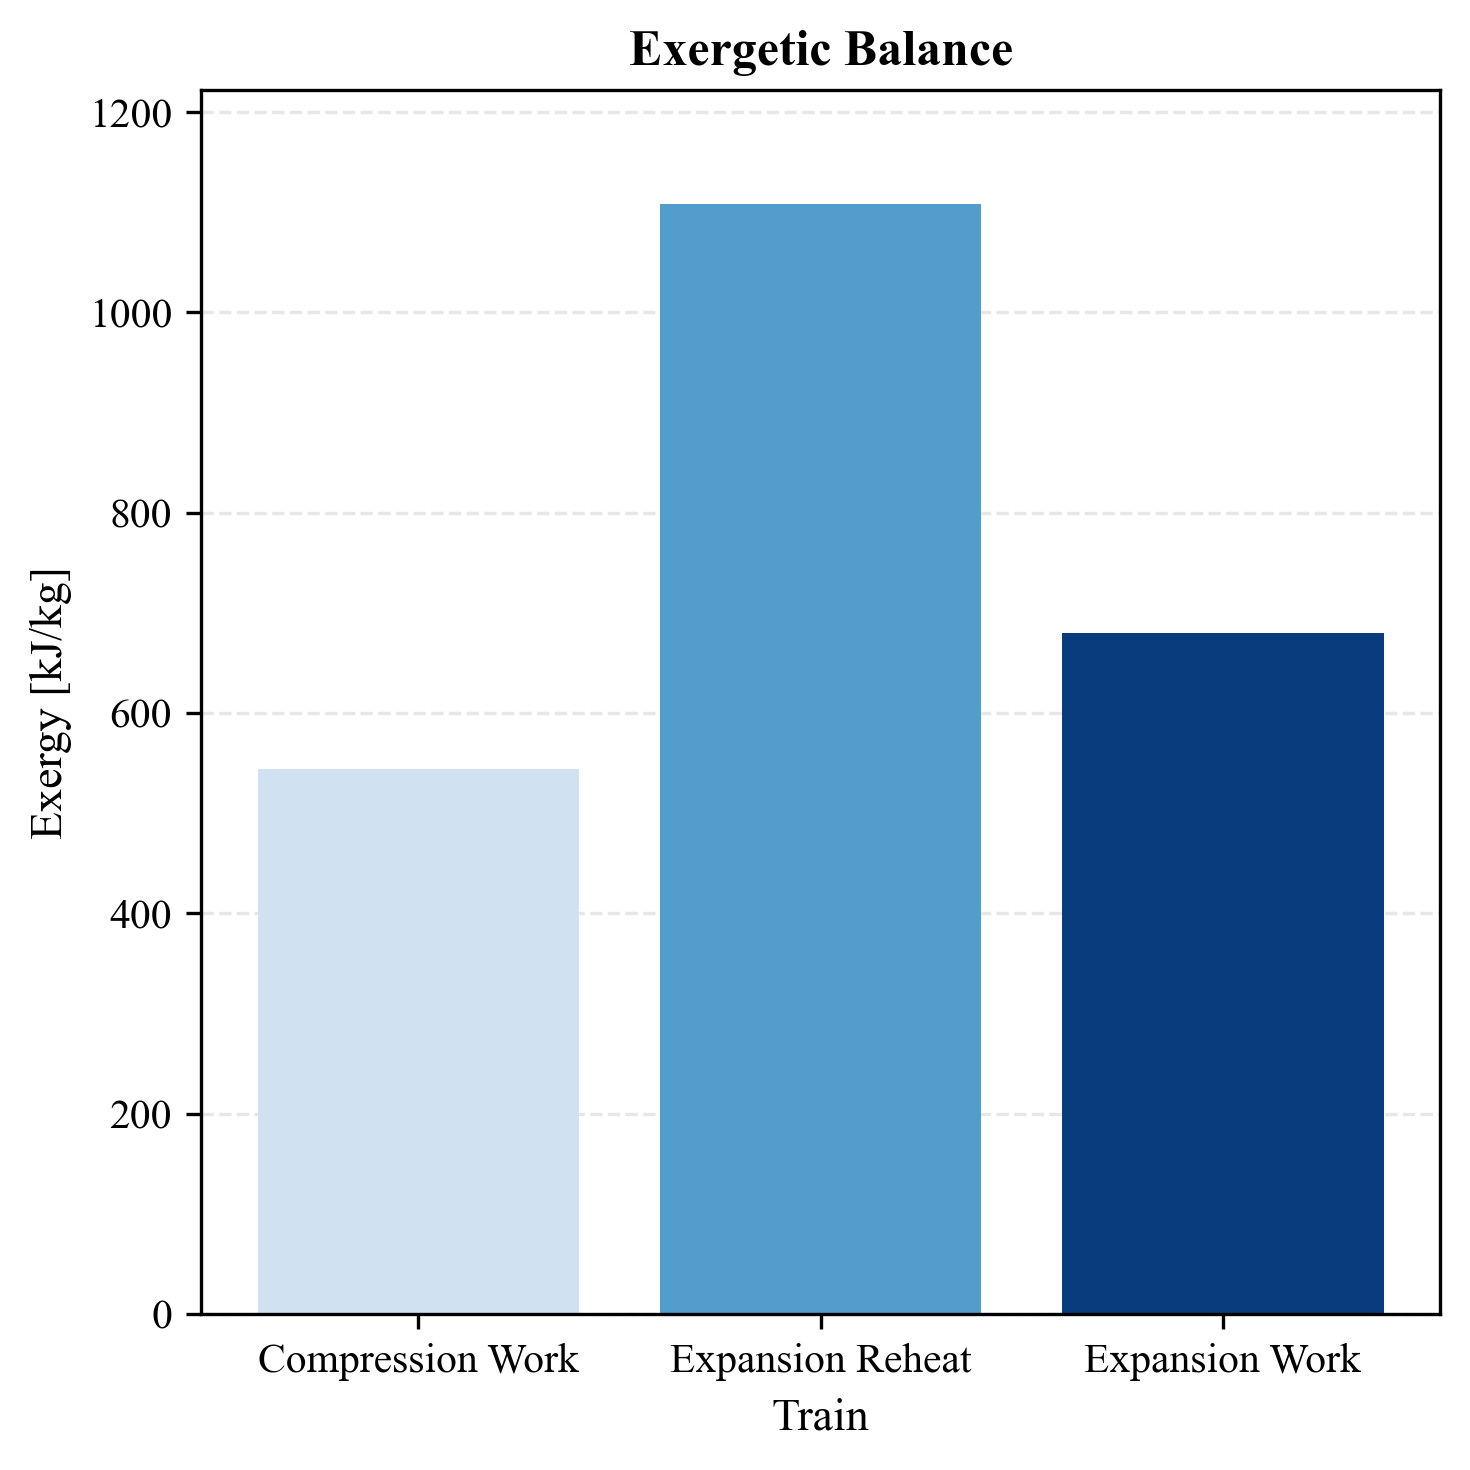

In [86]:
Figure_title = 'Exergetic Balance'

kpis = ['Compression Work', 'Expansion Reheat', 'Expansion Work']
y_data = [W_C, Q_F, W_T]

fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap = plt.get_cmap('Blues'); hues = np.linspace(0.2, 0.95, len(kpis)); colors = cmap(hues)
x = np.arange(len(kpis)); bars = ax.bar(x, y_data, color=colors, edgecolor='none')
ax.set_xticks(x); ax.set_xticklabels(kpis); 
ax.set_xlabel('Train'); ax.set_ylabel('Exergy [kJ/kg]'); ax.set_title(Figure_title)
plt.rcParams['font.family']   = 'serif'; plt.rcParams['font.serif']    = ['Times New Roman']; 
plt.rcParams['axes.titlesize'] = 12; plt.rcParams['axes.titleweight'] = 'bold'; plt.rcParams['axes.labelsize'] = 11; plt.rcParams['xtick.labelsize'] = 10; plt.rcParams['ytick.labelsize'] = 10; plt.rcParams['legend.fontsize'] = 8
ax.grid(axis='y', linestyle='--', alpha=0.3); ax.set_axisbelow(True); y0, y1 = ax.get_ylim(); dy = (y1 - y0) * 0.05; ax.set_ylim(y0, y1 + dy)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

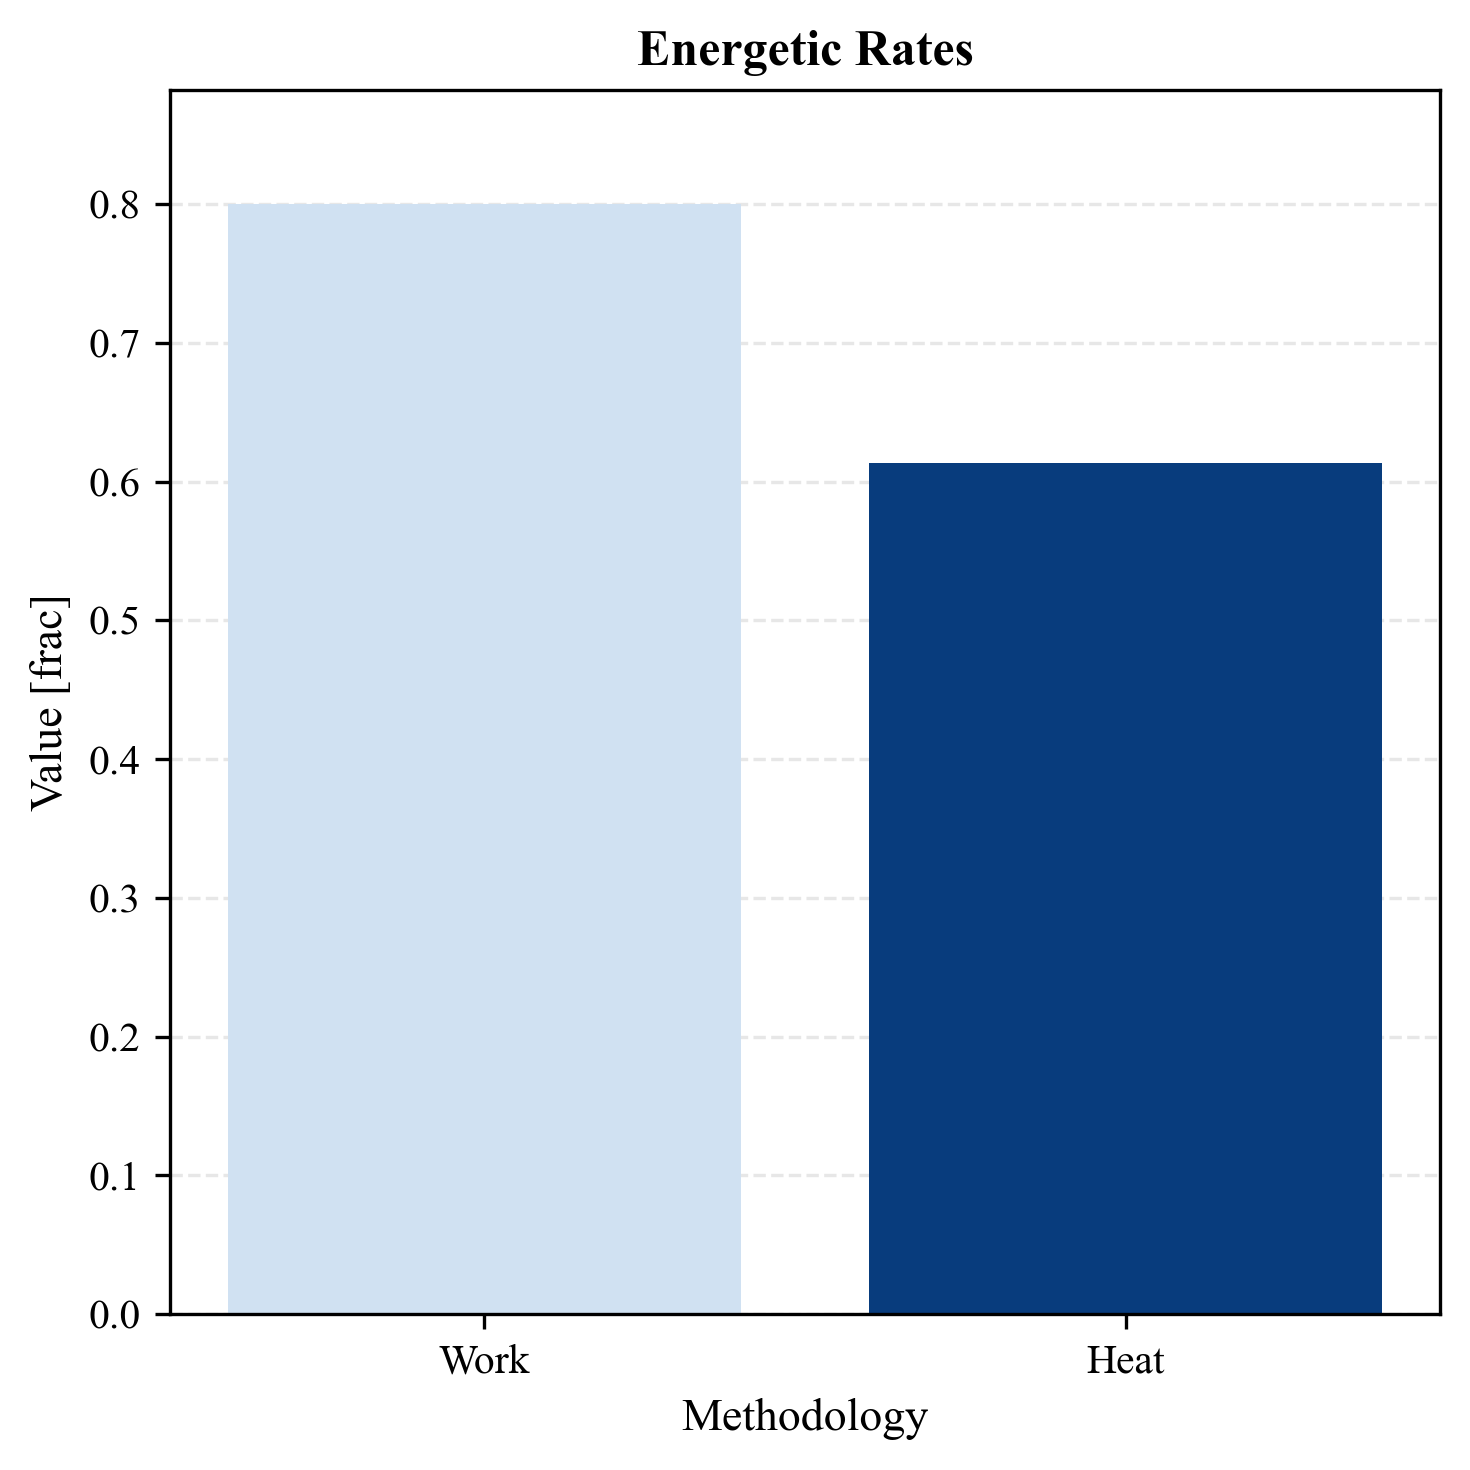

In [87]:
Figure_title = 'Energetic Rates'

kpis = ['Work', 'Heat']
y_data = [ER, HR]

fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap = plt.get_cmap('Blues'); hues = np.linspace(0.2, 0.95, len(kpis)); colors = cmap(hues)
x = np.arange(len(kpis)); bars = ax.bar(x, y_data, color=colors, edgecolor='none')
ax.set_xticks(x); ax.set_xticklabels(kpis); 
ax.set_xlabel('Methodology'); ax.set_ylabel('Value [frac]'); ax.set_title(Figure_title)
plt.rcParams['font.family']   = 'serif'; plt.rcParams['font.serif']    = ['Times New Roman']; 
plt.rcParams['axes.titlesize'] = 12; plt.rcParams['axes.titleweight'] = 'bold'; plt.rcParams['axes.labelsize'] = 11; plt.rcParams['xtick.labelsize'] = 10; plt.rcParams['ytick.labelsize'] = 10; plt.rcParams['legend.fontsize'] = 8
ax.grid(axis='y', linestyle='--', alpha=0.3); ax.set_axisbelow(True); y0, y1 = ax.get_ylim(); dy = (y1 - y0) * 0.05; ax.set_ylim(y0, y1 + dy)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

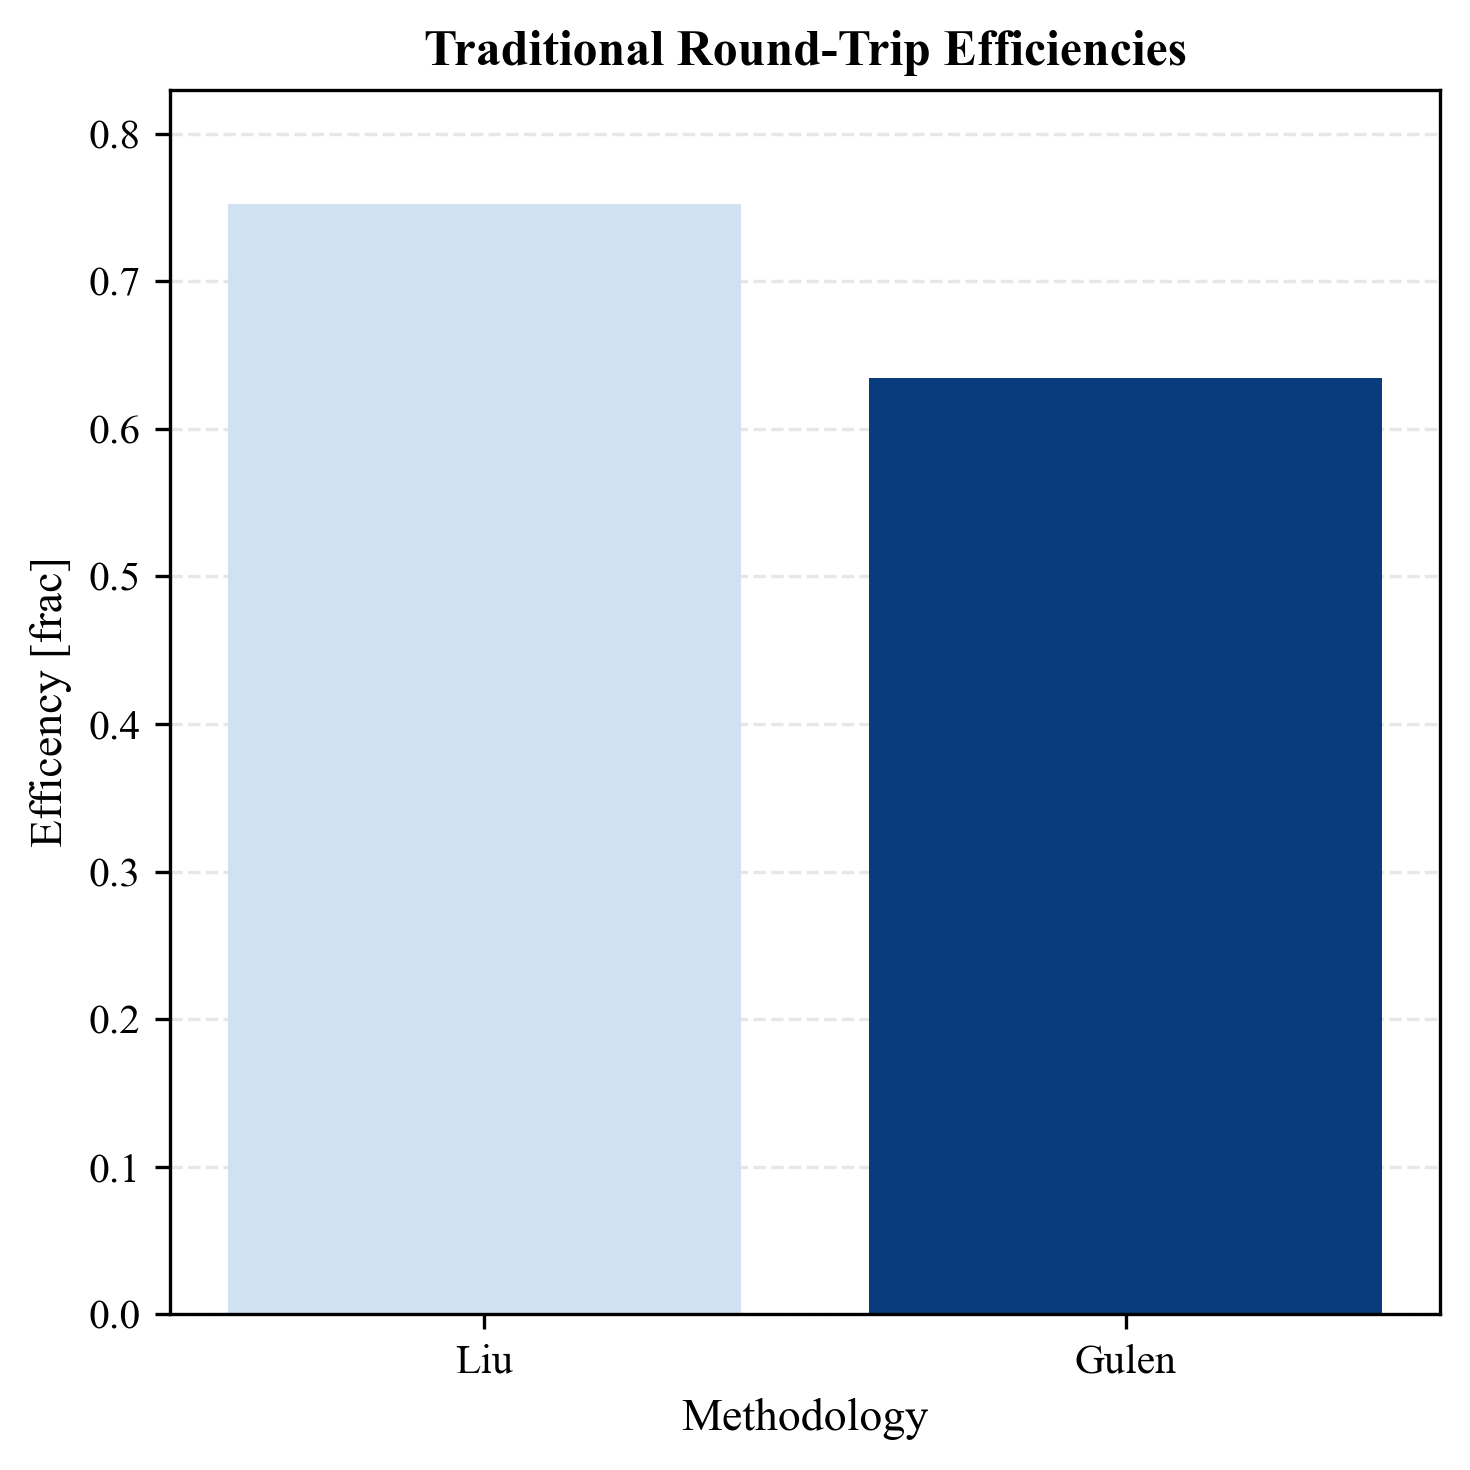

In [88]:
Figure_title = 'Traditional Round-Trip Efficiencies'

kpis = ['Liu', 'Gulen']
y_data = [RTE_Liu, RTE_Gulen]

fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap = plt.get_cmap('Blues'); hues = np.linspace(0.2, 0.95, len(kpis)); colors = cmap(hues)
x = np.arange(len(kpis)); bars = ax.bar(x, y_data, color=colors, edgecolor='none')
ax.set_xticks(x); ax.set_xticklabels(kpis); 
ax.set_xlabel('Methodology'); ax.set_ylabel('Efficency [frac]'); ax.set_title(Figure_title)
plt.rcParams['font.family']   = 'serif'; plt.rcParams['font.serif']    = ['Times New Roman']; 
plt.rcParams['axes.titlesize'] = 12; plt.rcParams['axes.titleweight'] = 'bold'; plt.rcParams['axes.labelsize'] = 11; plt.rcParams['xtick.labelsize'] = 10; plt.rcParams['ytick.labelsize'] = 10; plt.rcParams['legend.fontsize'] = 8
ax.grid(axis='y', linestyle='--', alpha=0.3); ax.set_axisbelow(True); y0, y1 = ax.get_ylim(); dy = (y1 - y0) * 0.05; ax.set_ylim(y0, y1 + dy)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

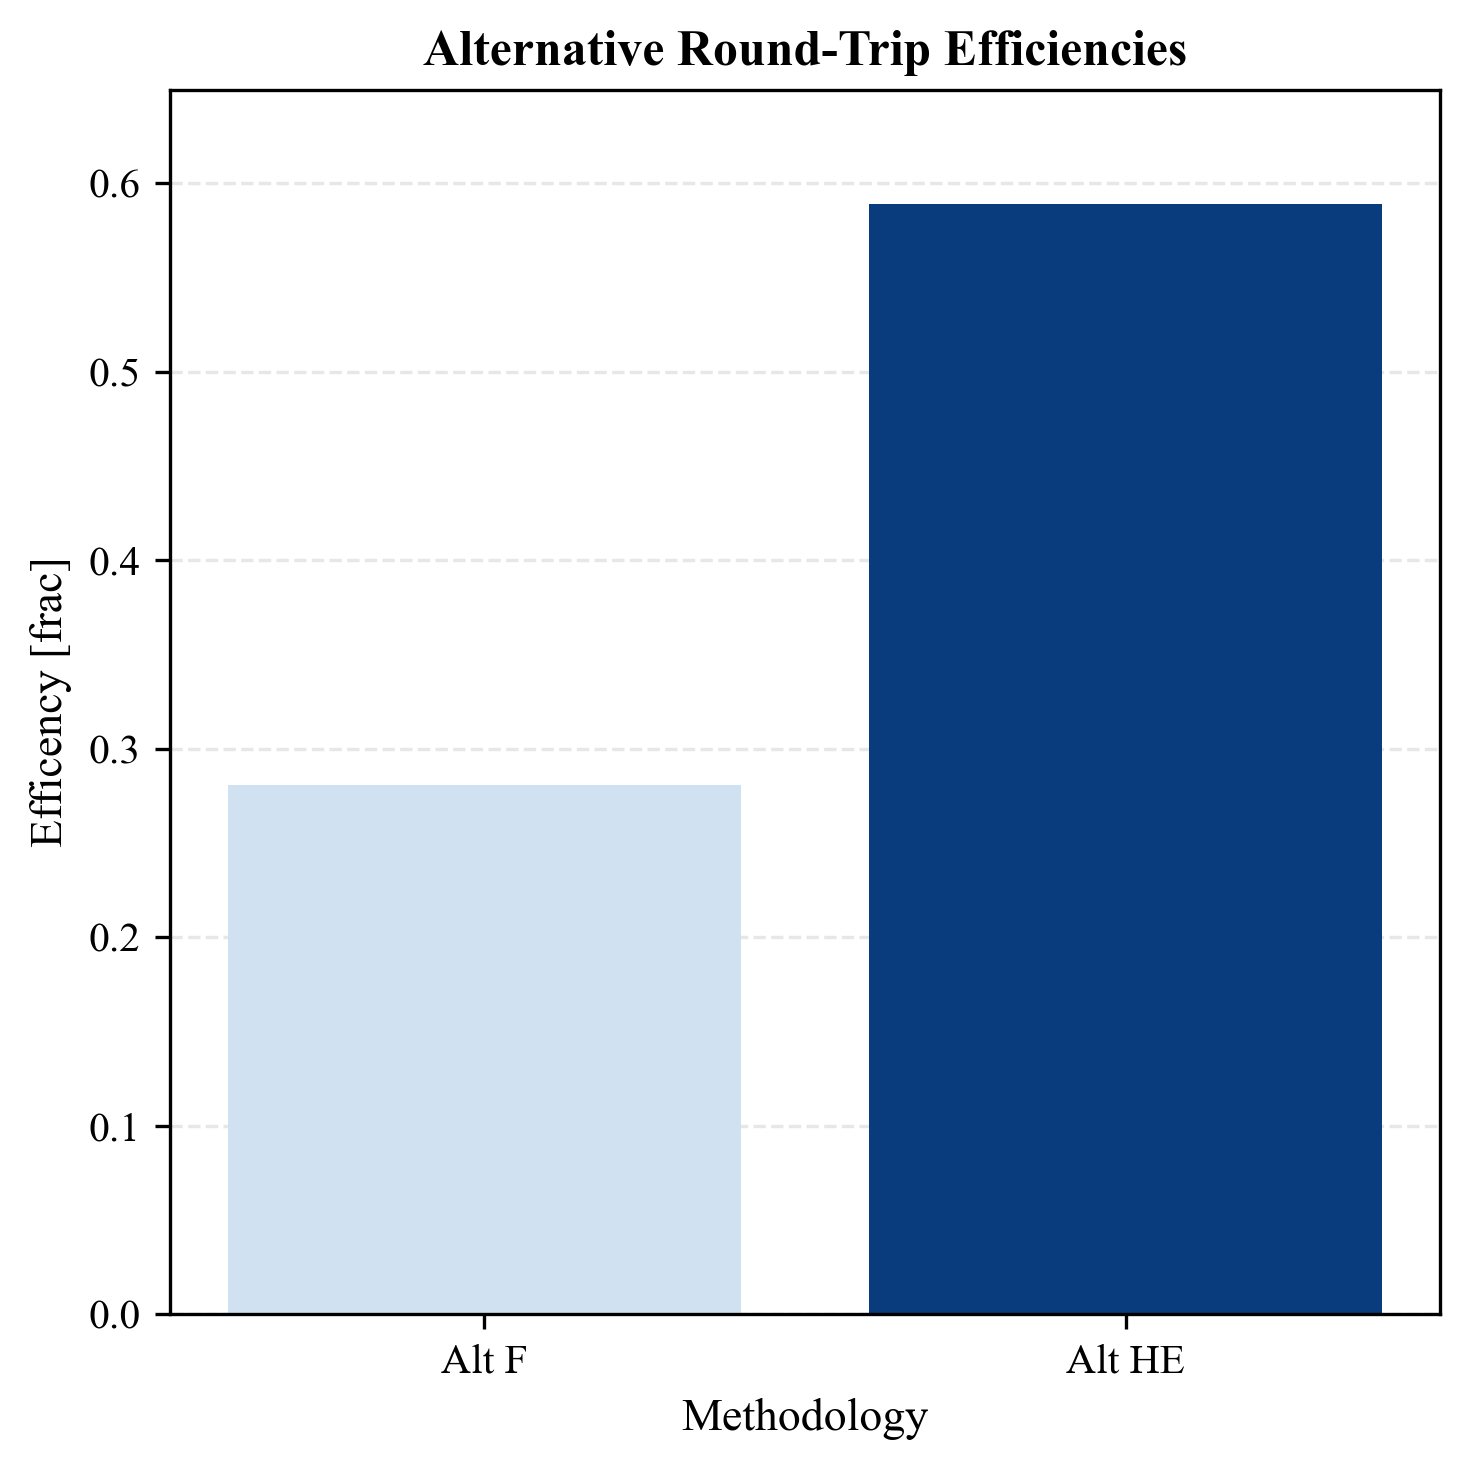

In [89]:
Figure_title = 'Alternative Round-Trip Efficiencies'

kpis = ['Alt F', 'Alt HE']
y_data = [RTE_alt_F, RTE_alt_HE]

fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap = plt.get_cmap('Blues'); hues = np.linspace(0.2, 0.95, len(kpis)); colors = cmap(hues)
x = np.arange(len(kpis)); bars = ax.bar(x, y_data, color=colors, edgecolor='none')
ax.set_xticks(x); ax.set_xticklabels(kpis); 
ax.set_xlabel('Methodology'); ax.set_ylabel('Efficency [frac]'); ax.set_title(Figure_title)
plt.rcParams['font.family']   = 'serif'; plt.rcParams['font.serif']    = ['Times New Roman']; 
plt.rcParams['axes.titlesize'] = 12; plt.rcParams['axes.titleweight'] = 'bold'; plt.rcParams['axes.labelsize'] = 11; plt.rcParams['xtick.labelsize'] = 10; plt.rcParams['ytick.labelsize'] = 10; plt.rcParams['legend.fontsize'] = 8
ax.grid(axis='y', linestyle='--', alpha=0.3); ax.set_axisbelow(True); y0, y1 = ax.get_ylim(); dy = (y1 - y0) * 0.05; ax.set_ylim(y0, y1 + dy)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

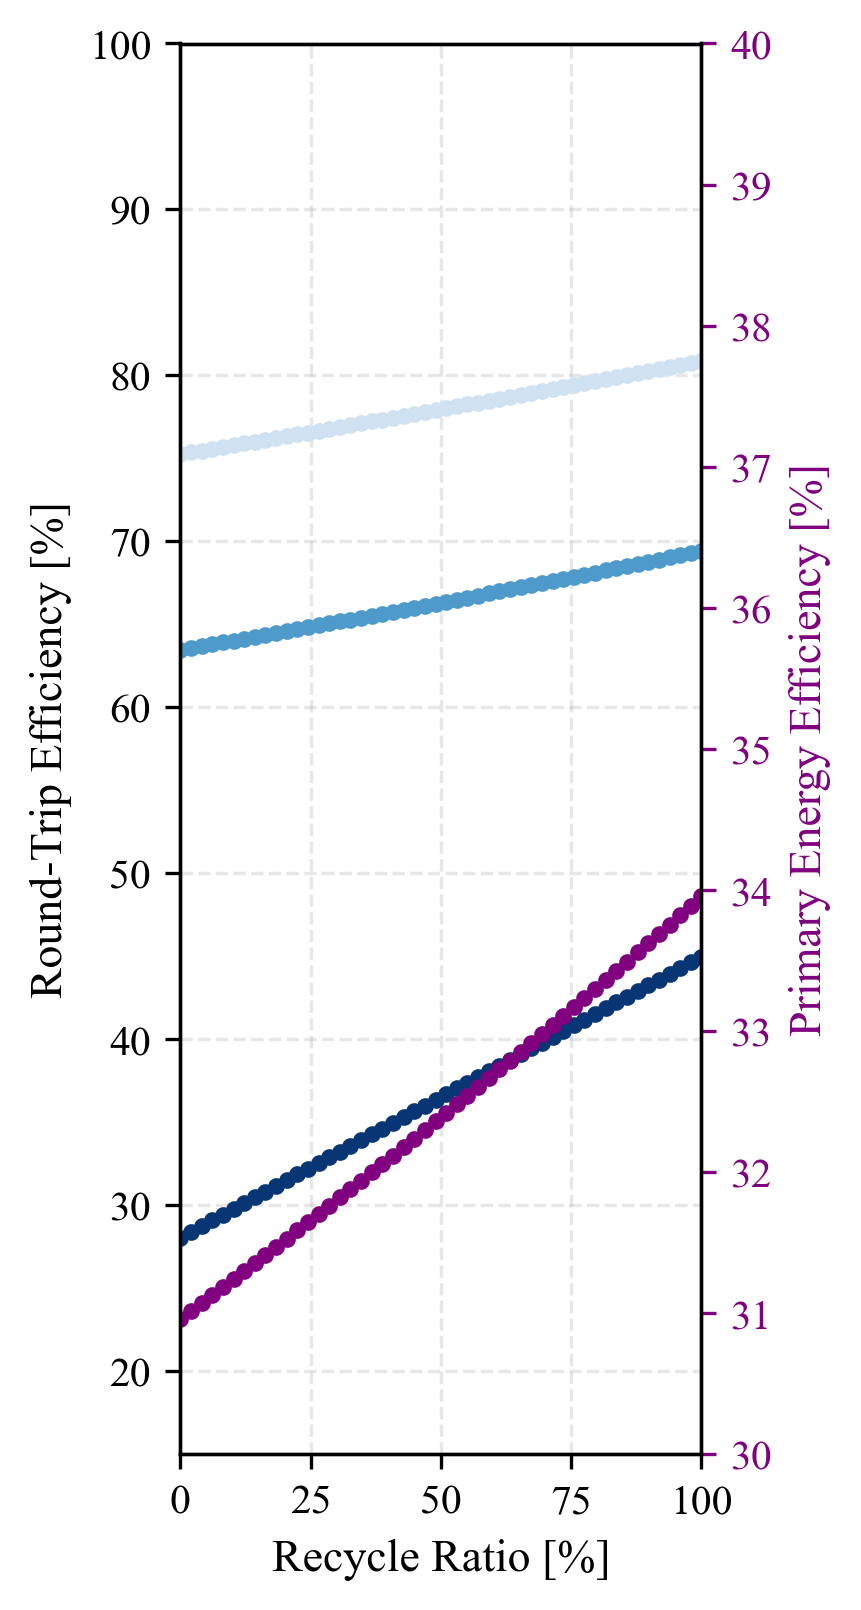

In [90]:
# Compute ratios in %
Q_rcyc_max    = Q_ICL
Q_rcyc_sample = np.linspace(0, Q_rcyc_max, 50)
Q_rcyc_ratio  = 100 * Q_rcyc_sample / Q_rcyc_max  

Q_HE_eff   = Q_HE - Q_rcyc_sample
Q_F_array  = Q_HE_eff / eta_burner_Gulen

RTE_Liu_array     = 100 * W_T / (W_C + eta_gen_avg * Q_HE_eff)
RTE_Gulen_array   = 100 * W_T / (W_C + eta_gen_avg * Q_F_array)
RTE_alt_F_array   = 100 * (W_T - eta_gen_avg * Q_F_array) / W_C
RTE_alt_HE_array  = 100 * (W_T - eta_gen_avg * Q_HE_eff) / W_C
PEE_array         = 100 * W_T / ((W_C / eta_grid_avg) + Q_F_array)

fig, ax1 = plt.subplots(figsize=(3, 5.5), dpi=300)

cmap   = plt.get_cmap('Blues')
colors = cmap(np.linspace(0.2, 0.975, 3))
labels = ['RTE Liu', 'RTE Gulen', 'RTE alt F', 'RTE alt HE']

for arr, col, lbl in zip([RTE_Liu_array, RTE_Gulen_array, RTE_alt_F_array, RTE_alt_HE_array], colors, labels):
    ax1.plot(Q_rcyc_ratio, arr, marker='o', markersize=3, linewidth=1, color=col)

ax1.set_xlabel('Recycle Ratio [%]')
ax1.set_ylabel('Round-Trip Efficiency [%]')
ax1.grid(True, which='both', linestyle='--', alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(Q_rcyc_ratio, PEE_array, marker='o', markersize=3, linewidth=1, color='purple')
ax2.set_ylabel('Primary Energy Efficiency [%]', color='purple')
ax2.tick_params(axis='y', colors='purple')

# Formatting
ax1.set_xlim(0, 100)
ax1.set_ylim(15, 100)   
ax2.set_ylim(30, 40)

# Increase number of ticks
ax1.yaxis.set_major_locator(plt.MaxNLocator(10))
ax2.yaxis.set_major_locator(plt.MaxNLocator(10))

ax1.legend([], [], frameon=False)
ax1.set_title("")

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 11
})

plt.tight_layout()

Figure_title = r'Recycled Dumped Heat Ratio & Cycle Efficiency KPIs'
out_path = fig_dir / f"{Figure_title}.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight')


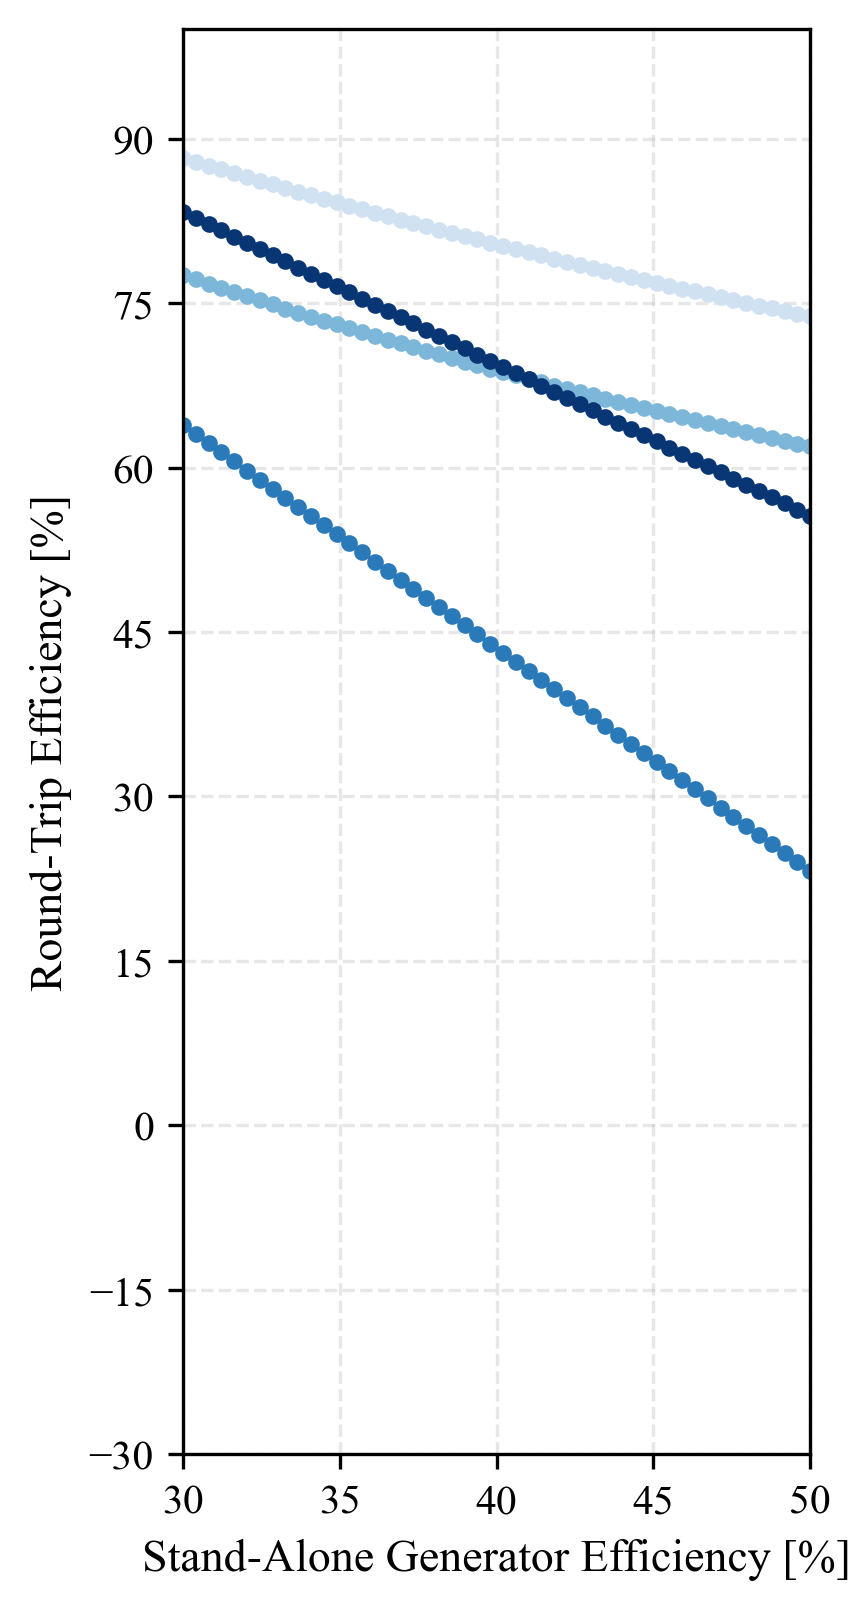

In [91]:
eta_gen_sample = np.linspace(0.3, 0.5, 50) * 100   # convert to %
RTE_Liu_array   = 100 * W_T / (W_C + (eta_gen_sample/100) * Q_HE)
RTE_Gulen_array = 100 * W_T / (W_C + (eta_gen_sample/100) * Q_F)
RTE_alt_F_array = 100 * (W_T - (eta_gen_sample/100) * Q_F) / W_C
RTE_alt_HE_array= 100 * (W_T - (eta_gen_sample/100) * Q_HE) / W_C

fig, ax1 = plt.subplots(figsize=(3, 5.5), dpi=300)

cmap   = plt.get_cmap('Blues')
colors = cmap(np.linspace(0.2, 0.975, 4))   

for arr, col in zip([RTE_Liu_array, RTE_Gulen_array, RTE_alt_F_array, RTE_alt_HE_array], colors):
    ax1.plot(eta_gen_sample, arr, marker='o', markersize=3, linewidth=1, color=col)

ax1.set_xlabel('Stand-Alone Generator Efficiency [%]')
ax1.set_ylabel('Round-Trip Efficiency [%]')
ax1.grid(True, which='both', linestyle='--', alpha=0.3)

ax1.set_xlim(30, 50)
ax1.set_ylim(-30, 100)  

ax1.yaxis.set_major_locator(plt.MaxNLocator(10))

ax1.legend([], [], frameon=False)
ax1.set_title("")

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 11
})

plt.tight_layout()

Figure_title = r'Stand-alone Generator Thermal Efficiency & Cycle Efficiency KPIs'
out_path = fig_dir / f"{Figure_title}.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight')

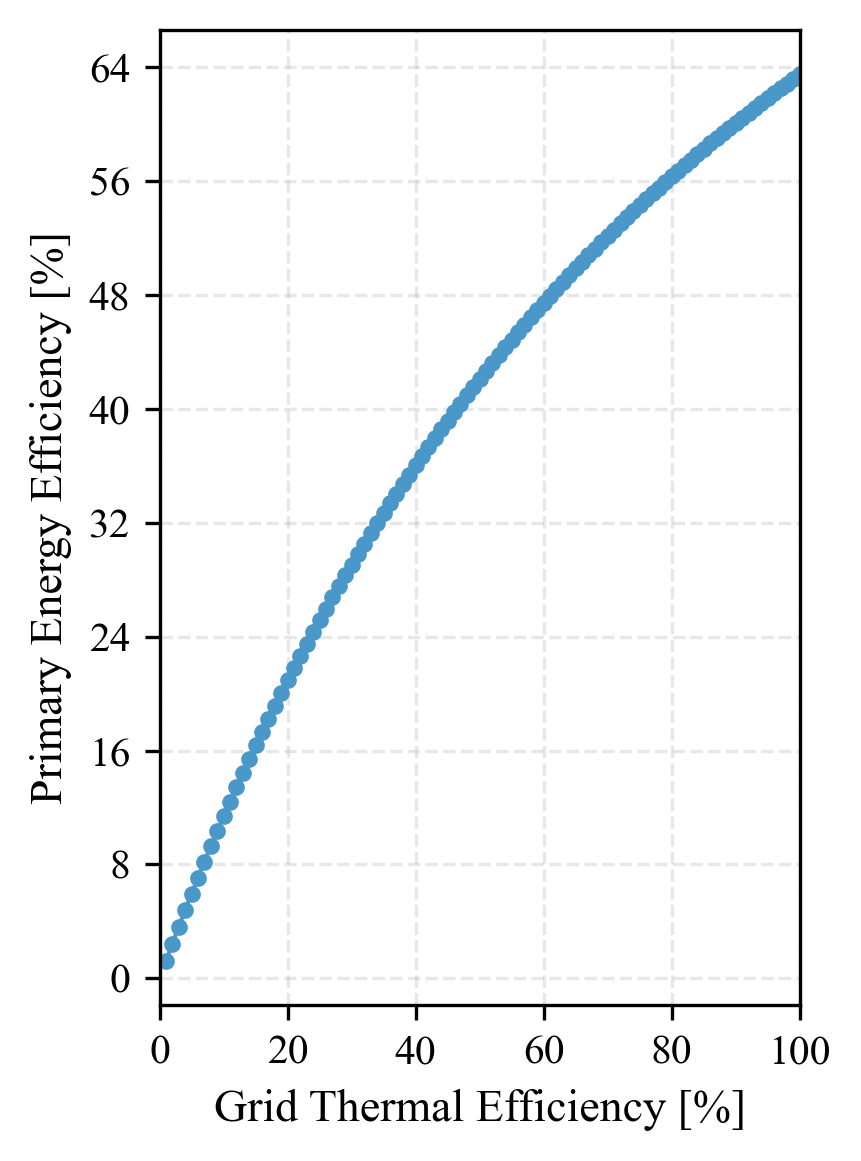

In [92]:
eta_grid_sample = np.linspace(0.01, 1, 100) * 100  
PEE_array_2     = 100 * W_T / ((W_C / (eta_grid_sample/100)) + eta_gen_avg*Q_F)

# Figure setup
fig, ax = plt.subplots(figsize=(3, 4), dpi=300)

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.bf': 'Times New Roman:bold',
    'mathtext.it': 'Times New Roman:italic',
    'font.size': 11
})

color = plt.get_cmap('Blues')(0.6)
ax.plot(eta_grid_sample, PEE_array_2, marker='o', markersize=3, linewidth=1, color=color)

ax.set_xlabel('Grid Thermal Efficiency [%]')
ax.set_ylabel('Primary Energy Efficiency [%]')

ax.set_title("")

ax.set_xlim(0, 100)

ax.yaxis.set_major_locator(plt.MaxNLocator(10))

ax.grid(True, which='both', linestyle='--', alpha=0.3)

plt.tight_layout()

Figure_title = 'Mean Grid Thermal Efficiency & PEE'
out_path = fig_dir / f"{Figure_title}.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight')


### Component Visualizations

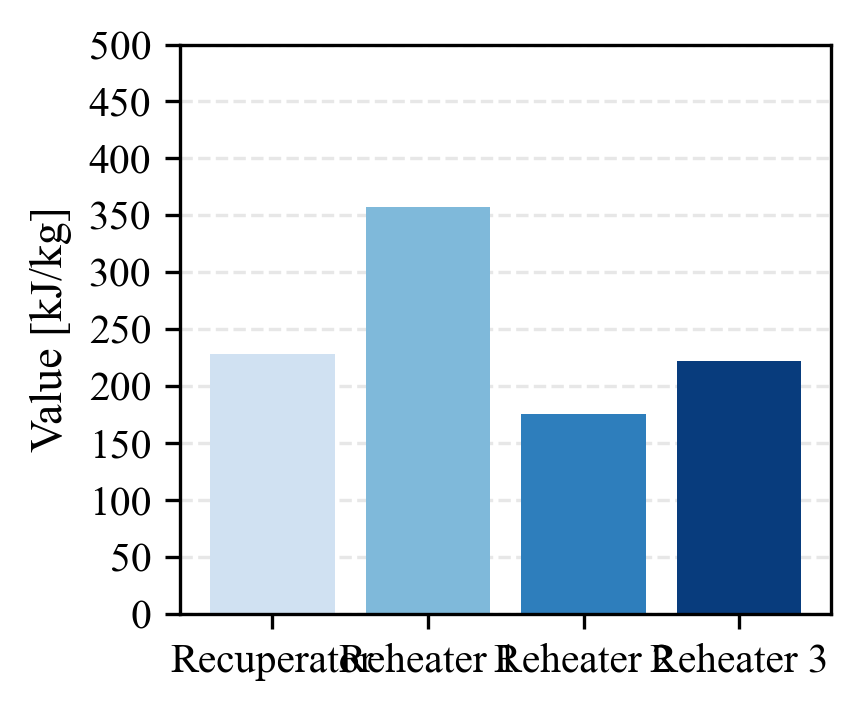

In [93]:
Figure_title = 'Expansion Heating Decomposition'

reheatQs = dfc.loc[dfc['Component'] == 'HE', 'EX_F'].reset_index(drop=True)
Q_reheat1, Q_reheat2, Q_reheat3 = reheatQs

kpis   = ['Recuperator', 'Reheater 1', 'Reheater 2', 'Reheater 3']
y_data = [-1*Q_recuped, Q_reheat1, Q_reheat2, Q_reheat3]

fig, ax = plt.subplots(figsize=(3, 2.5), dpi=300)

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 11
})

cmap  = plt.get_cmap('Blues')
hues  = np.linspace(0.2, 0.95, len(kpis))
colors = cmap(hues)

x = np.arange(len(kpis))
bars = ax.bar(x, y_data, color=colors, edgecolor='none')

ax.set_xticks(x)
ax.set_xticklabels(kpis)
ax.set_ylabel('Value [kJ/kg]')
ax.set_xlabel('')    
ax.set_title('')     

ax.set_ylim(0, 500)
ax.yaxis.set_major_locator(plt.MaxNLocator(10))

# Grid
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()

out_path = fig_dir / f"{Figure_title}.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight')


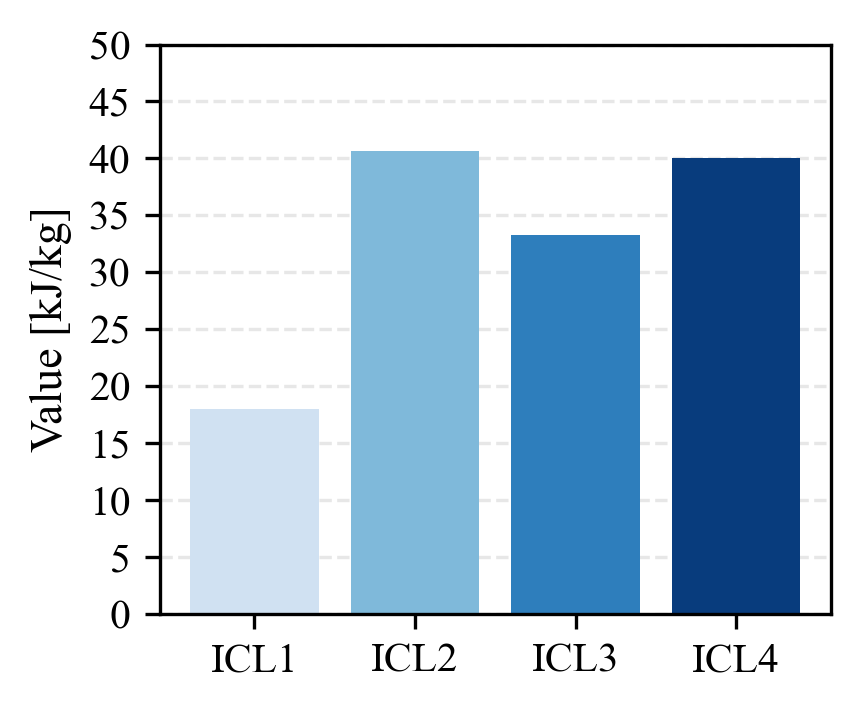

In [94]:
Figure_title = 'Intercooler Heat Dump Decomposition'

kpis   = ['ICL1', 'ICL2', 'ICL3', 'ICL4']
y_data = [Q_ICL1, Q_ICL2, Q_ICL3, Q_ICL4]

fig, ax = plt.subplots(figsize=(3, 2.5), dpi=300)

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 11
})

cmap  = plt.get_cmap('Blues')
hues  = np.linspace(0.2, 0.95, len(kpis))
colors = cmap(hues)

x = np.arange(len(kpis))
bars = ax.bar(x, y_data, color=colors, edgecolor='none')

ax.set_xticks(x)
ax.set_xticklabels(kpis)
ax.set_ylabel('Value [kJ/kg]')
ax.set_xlabel('')  
ax.set_title('') 

ax.set_ylim(0, 50)
ax.yaxis.set_major_locator(plt.MaxNLocator(10))

ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

ax.legend([], [], frameon=False)

plt.tight_layout()

out_path = fig_dir / f"{Figure_title}.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight')


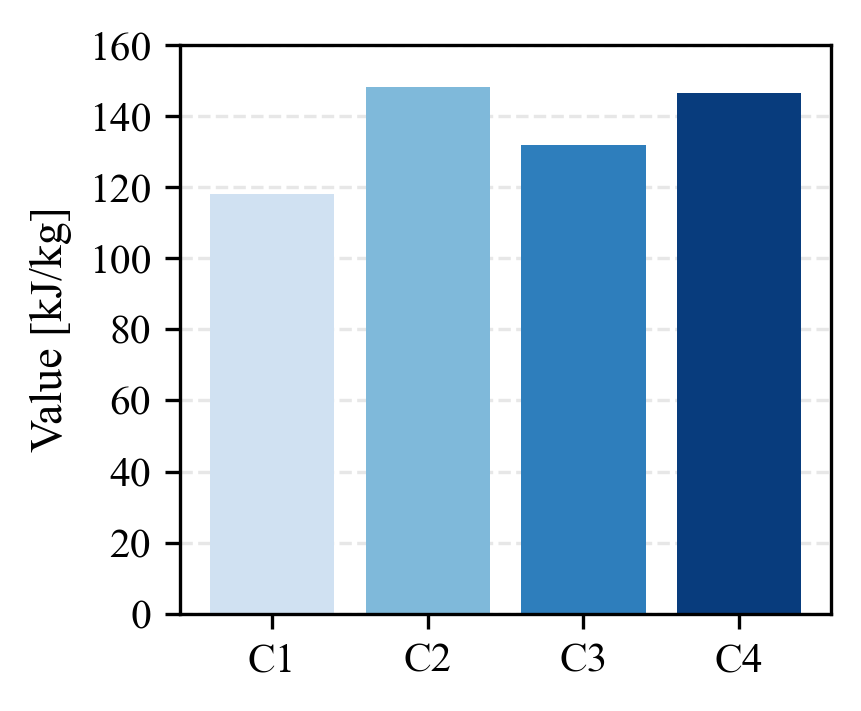

In [95]:
kpis = ['C1', 'C2', 'C3', 'C4']
y_data = [W_C1, W_C2, W_C3, W_C4]

fig, ax = plt.subplots(figsize=(3, 2.5), dpi=300)


plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 11
})


cmap = plt.get_cmap('Blues')
hues = np.linspace(0.2, 0.95, len(kpis))
colors = cmap(hues)


x = np.arange(len(kpis))
bars = ax.bar(x, y_data, color=colors, edgecolor='none')

# Axis labels
ax.set_xticks(x)
ax.set_xticklabels(kpis)
ax.set_ylabel('Value [kJ/kg]')
ax.set_xlabel("")   
ax.set_title("")  

ax.set_ylim(0, 160)
ax.yaxis.set_major_locator(plt.MaxNLocator(10))


ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()

Figure_title = 'Compression Train Decomposition'
out_path = fig_dir / f"{Figure_title}.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight')


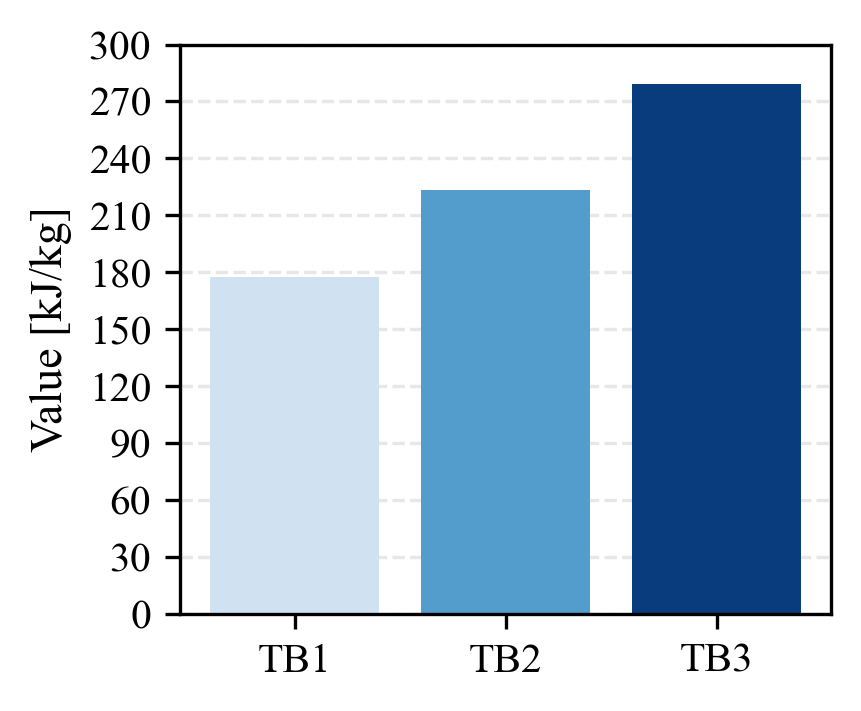

In [96]:
kpis = ['T1', 'T2', 'T3']
y_data = [W_T1, W_T2, W_T3]

fig, ax = plt.subplots(figsize=(3, 2.5), dpi=300)

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 11
})


cmap = plt.get_cmap('Blues')
hues = np.linspace(0.2, 0.95, len(kpis))
colors = cmap(hues)

x = np.arange(len(kpis))
bars = ax.bar(x, y_data, color=colors, edgecolor='none')

ax.set_xticks(x)
ax.set_xticklabels(['TB1', 'TB2', 'TB3'])
ax.set_ylabel('Value [kJ/kg]')
ax.set_xlabel("")  
ax.set_title("")   

ax.set_ylim(0, 300)
ax.yaxis.set_major_locator(plt.MaxNLocator(10))

ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()

Figure_title = 'Expansion Train Decomposition'
out_path = fig_dir / f"{Figure_title}.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight')


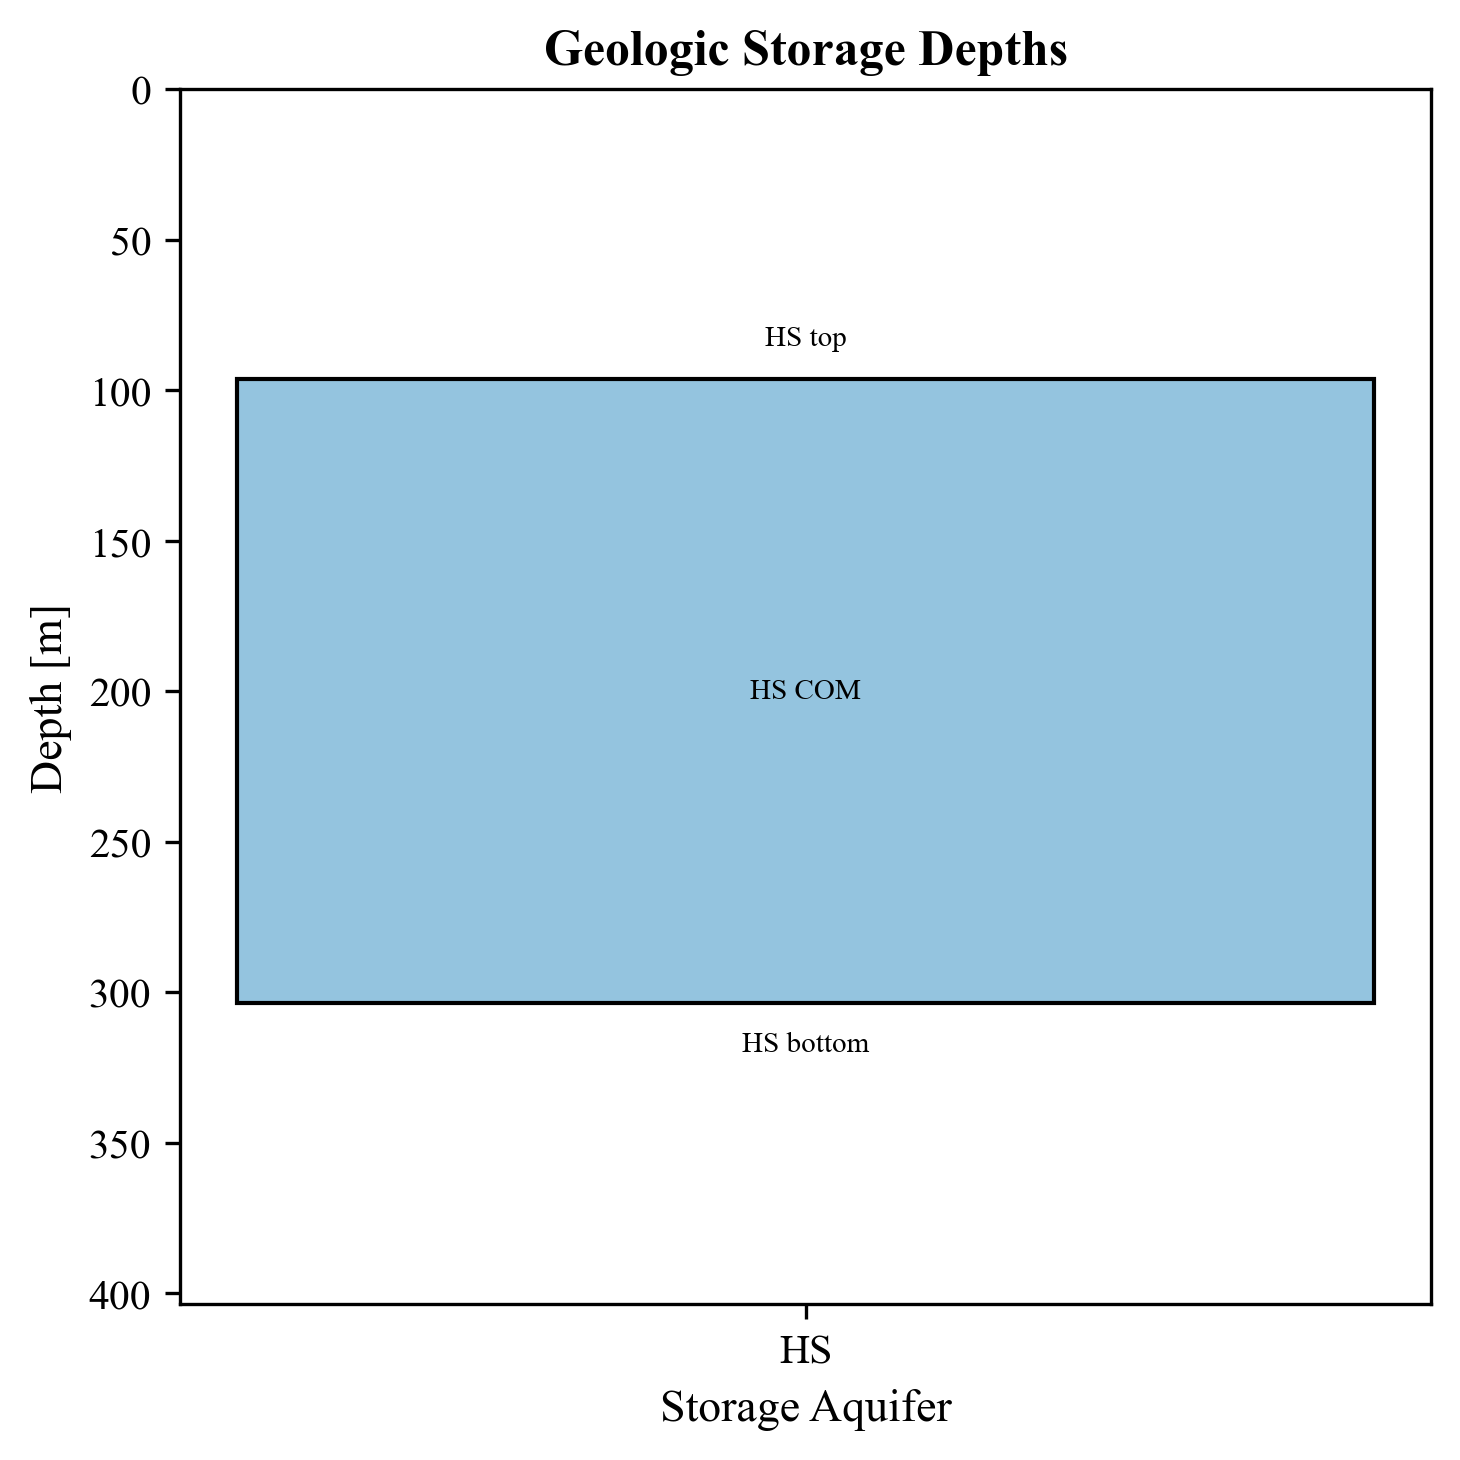

In [97]:
Figure_title = 'Geologic Storage Depths'
deltaz_HS = deltaP_HS_full_cycle/(p_HS_ss*g); 
z_HS_top = z_HS - (deltaz_HS/2); z_HS_bottom = z_HS + (deltaz_HS/2); z_HS_com = z_HS;
labels = ['HS']; top    = [z_HS_top]; bot    = [z_HS_bottom]; com    = [z_HS_com]
heights     = [t - b for t, b in zip(top, bot)]; max_height  = max(heights); offset      = max_height * 0.045


fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap   = plt.get_cmap('Blues'); colors = cmap(np.linspace(0.4, 0.8, len(labels)))
x = np.arange(len(labels))
ax.bar(x,heights,bottom=bot,width=0.6,color=colors,edgecolor='black')
for xi, t, m, b, lbl in zip(x, top, com, bot, labels):
    ax.text(xi,t + offset,f"{lbl} top",ha='center',va='bottom',fontsize=7)
    ax.text(xi,m,f"{lbl} COM",ha='center',va='center',fontsize=7,color='black')
    ax.text(xi,b - offset,f"{lbl} bottom",ha='center',va='top',fontsize=7)
ax.set_xticks(x); ax.set_xticklabels(labels, fontsize=10); ax.set_ylim(max(bot) + 100, 0);ax.set_xlabel('Storage Aquifer'); ax.set_ylabel('Depth [m]', fontsize=11);ax.set_title(Figure_title,fontsize=12,fontweight='bold')

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

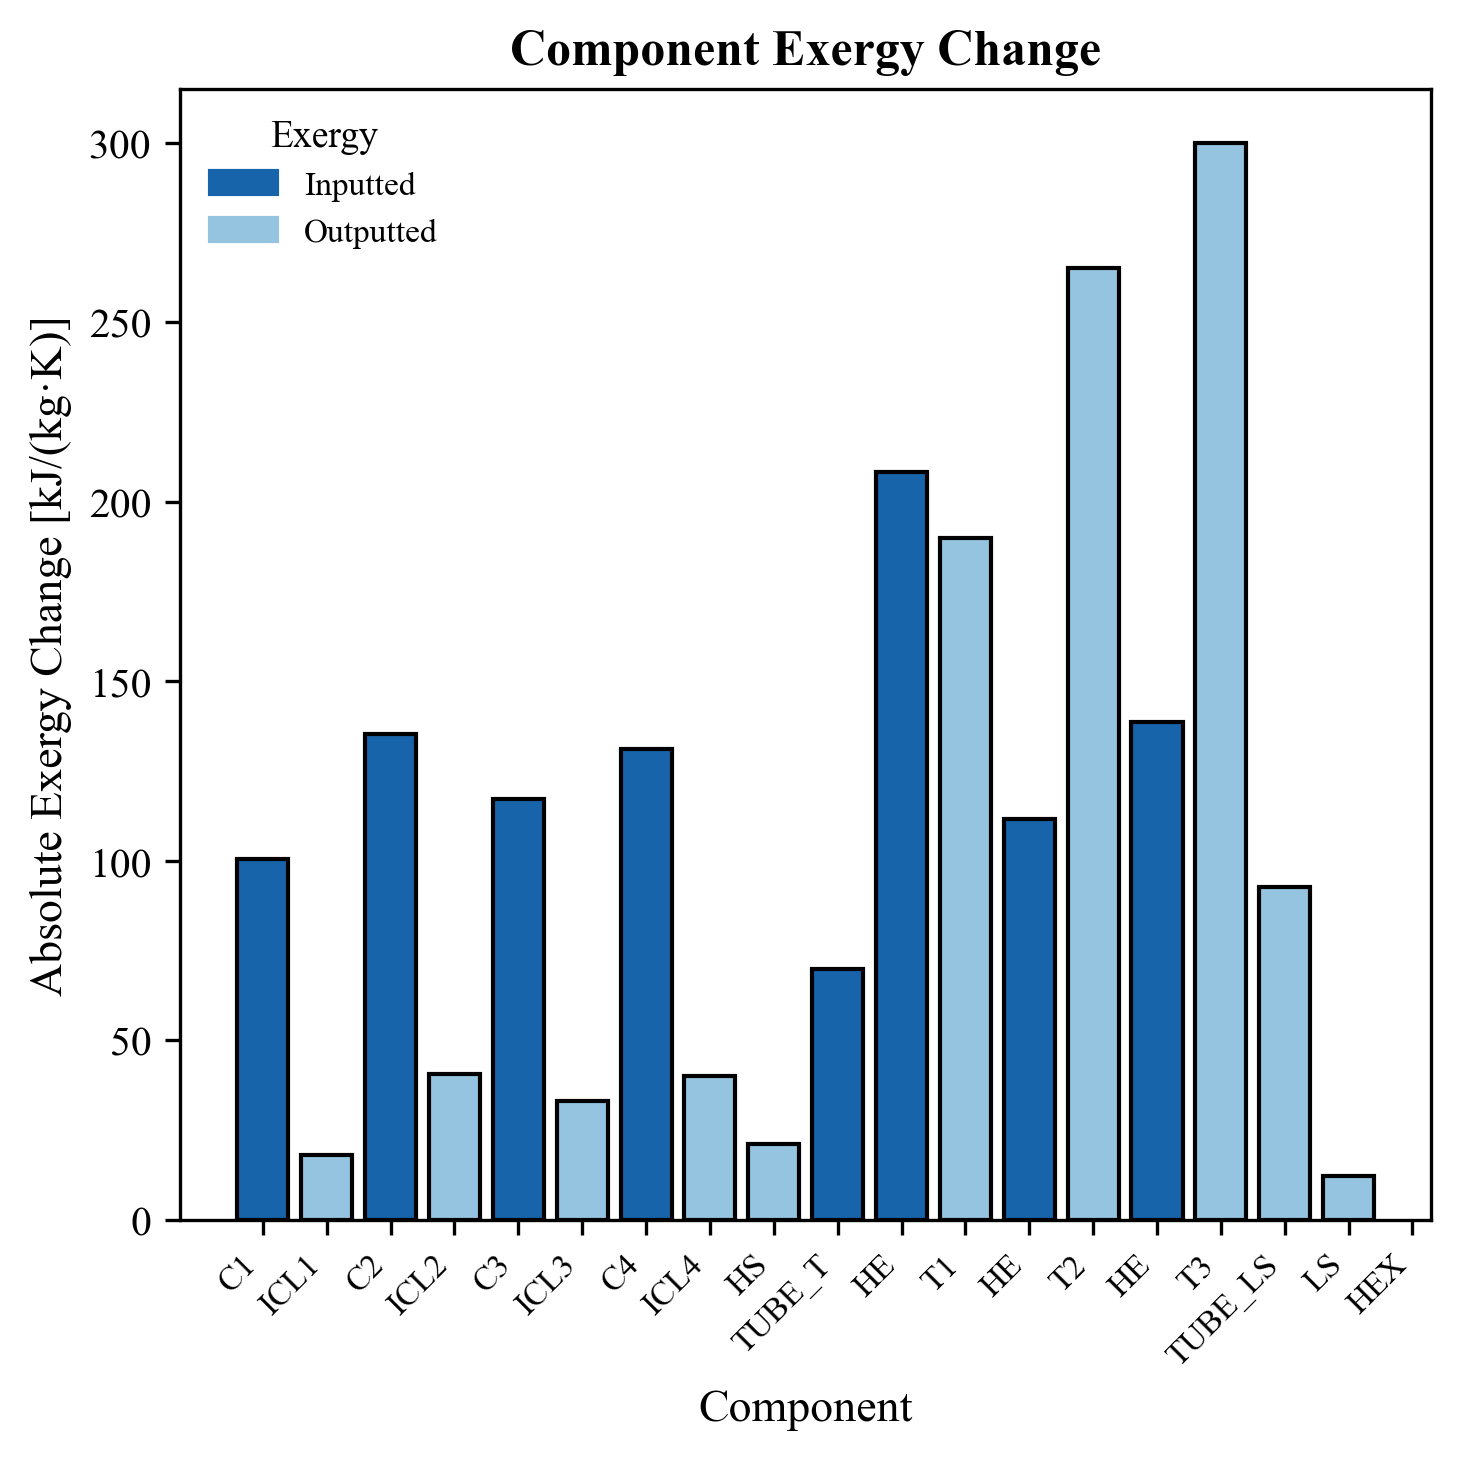

In [98]:
Figure_title = 'Component Exergy Change'

components = dfc['Component'].tolist(); start_ex   = dfc['Start_ex'].values; end_ex     = dfc['End_ex'].values; delta_ex   = end_ex - start_ex
heights = np.abs(delta_ex); x       = np.arange(len(components))

fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap      = plt.get_cmap('Blues'); in_color  = cmap(0.8); out_color = cmap(0.4)

colors    = [in_color if d > 0 else out_color for d in delta_ex]; ax.bar(x, heights, color=colors, edgecolor='black')
in_patch  = mpatches.Patch(color=in_color,  label='Inputted'); out_patch = mpatches.Patch(color=out_color, label='Outputted')
ax.legend([in_patch, out_patch],
          ['Inputted', 'Outputted'],
          title='Exergy',
          title_fontsize=9,
          fontsize=8,
          loc='upper left',
          frameon=False)
ax.set_title(Figure_title, fontsize=12, fontweight='bold'); ax.set_xlabel('Component', fontsize=11)
ax.set_ylabel('Absolute Exergy Change [kJ/(kg·K)]', fontsize=11); ax.set_xticks(x); ax.set_xticklabels(components, rotation=45, ha='right', fontsize=8)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

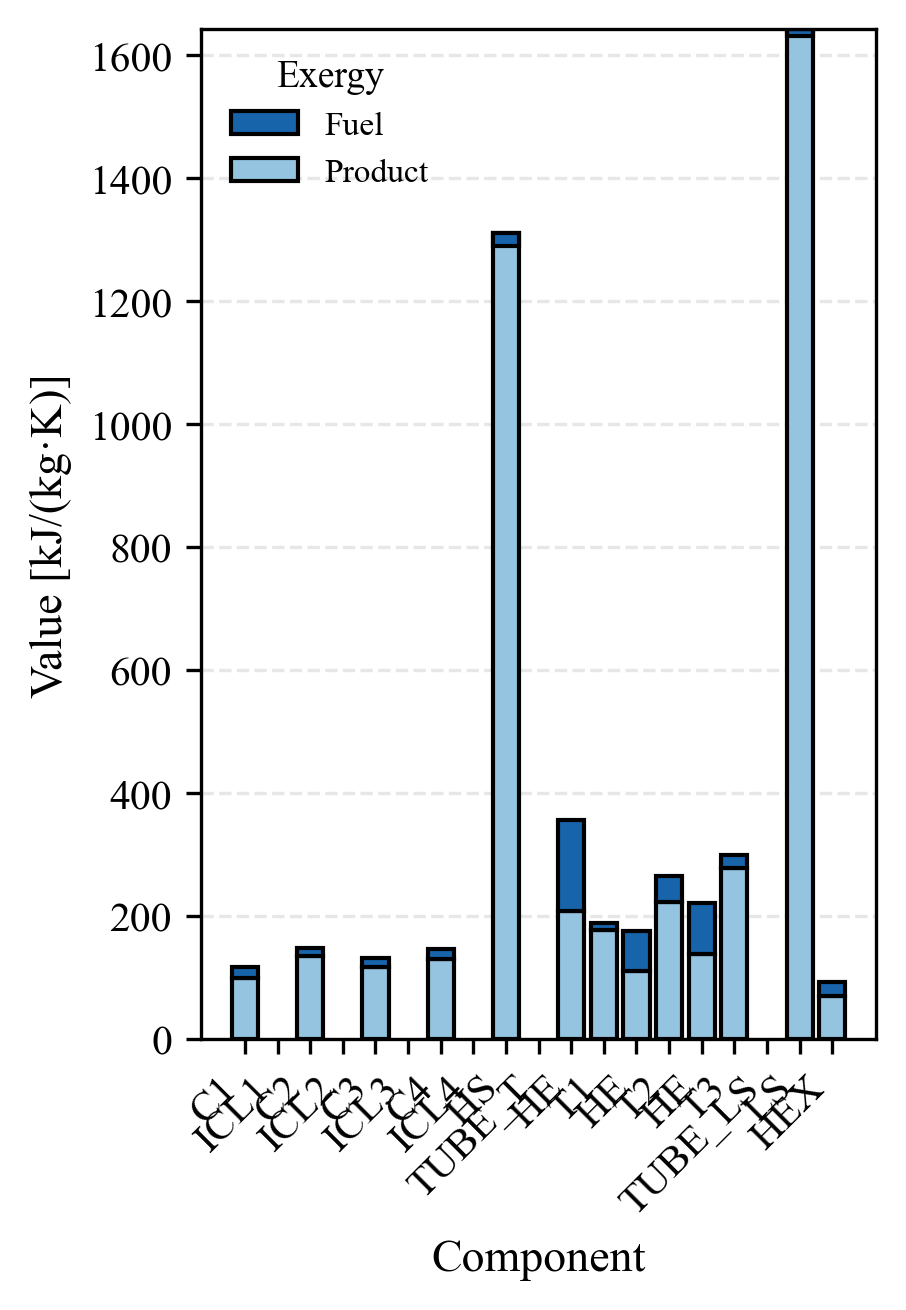

In [99]:
components = dfc['Component'].tolist()
EX_F = np.abs(dfc['EX_F'].values)
EX_P = np.abs(dfc['EX_P'].values)
inc_F = EX_F - EX_P

fig, ax = plt.subplots(figsize=(3.15, 4.5), dpi=300)

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 11
})


cmap = plt.get_cmap('Blues')
col_P = cmap(0.4)
col_F = cmap(0.8)


x = np.arange(len(components))
ax.bar(x, EX_P, color=col_P, label='Product', edgecolor='black')
ax.bar(x, inc_F, bottom=EX_P, color=col_F, label='Fuel', edgecolor='black')


ax.set_title("") 
ax.set_xlabel('Component')
ax.set_ylabel('Value [kJ/(kg·K)]')
ax.set_xticks(x)
ax.set_xticklabels(components, rotation=45, ha='right')

ax.yaxis.set_major_locator(plt.MaxNLocator(10))


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Exergy',
          title_fontsize=9, fontsize=8, loc='upper left', frameon=False)

ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()

Figure_title = 'Component Exergy Destruction'
out_path = fig_dir / f"{Figure_title}.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight')


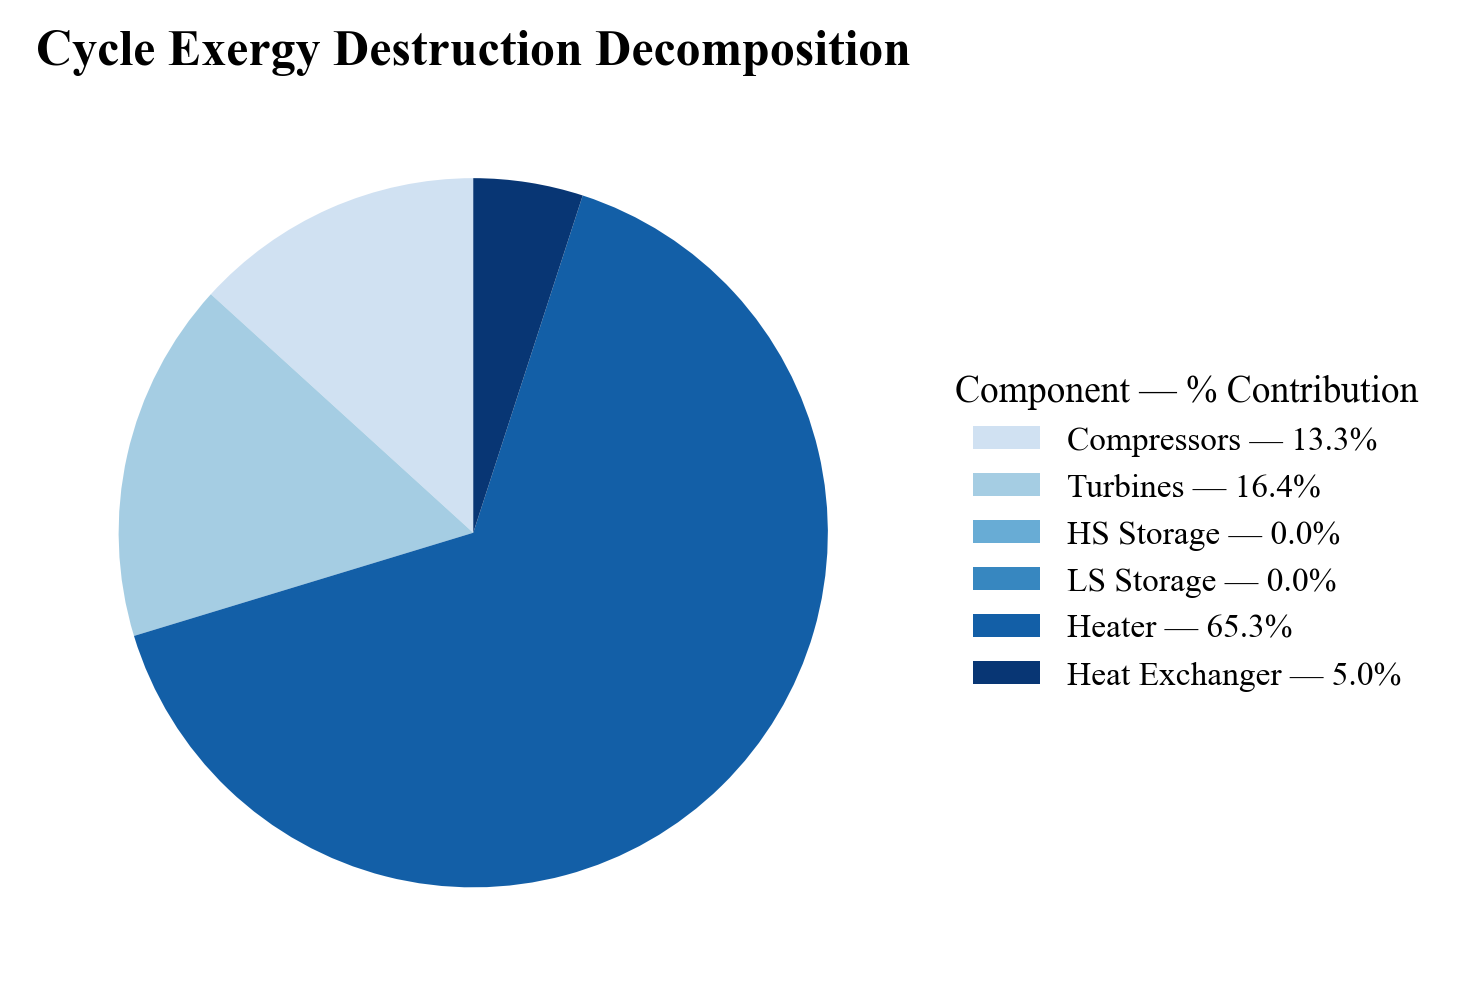

In [100]:
Figure_title = 'Cycle Exergy Destruction Decomposition'

components = ['Compressors', 'Turbines','HS Storage', 'LS Storage','Heater', 'Heat Exchanger']
ratios = np.array([EXDR_C,EXDR_T,EXDR_HS,EXDR_LS,EXDR_HE,EXDR_HEX]); percentages = 100 * ratios / ratios.sum(); legend_labels = [f"{comp} — {pct:.1f}%" for comp, pct in zip(components, percentages)]

fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap = plt.get_cmap('Blues'); hues = np.linspace(0.2, 0.975, len(components)); colors = cmap(hues)
wedges, _ = ax.pie(ratios,labels=None,colors=colors,startangle=90,wedgeprops=dict(edgecolor=None))
ax.legend(wedges,legend_labels,title='Component — % Contribution',loc='center left',bbox_to_anchor=(1.01, 0.5),fontsize=8,title_fontsize=9,frameon=False); ax.set_title(Figure_title, fontsize=12, fontweight='bold')

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

### Stream Visualizations

In [101]:
dffull = df; df_storage = df.iloc[-2:]; df = df.iloc[:-2]; 
HS_num = 0.5*(HS_start+HS_end); n_rows = dffull.shape[0];HS_idx = n_rows-1;

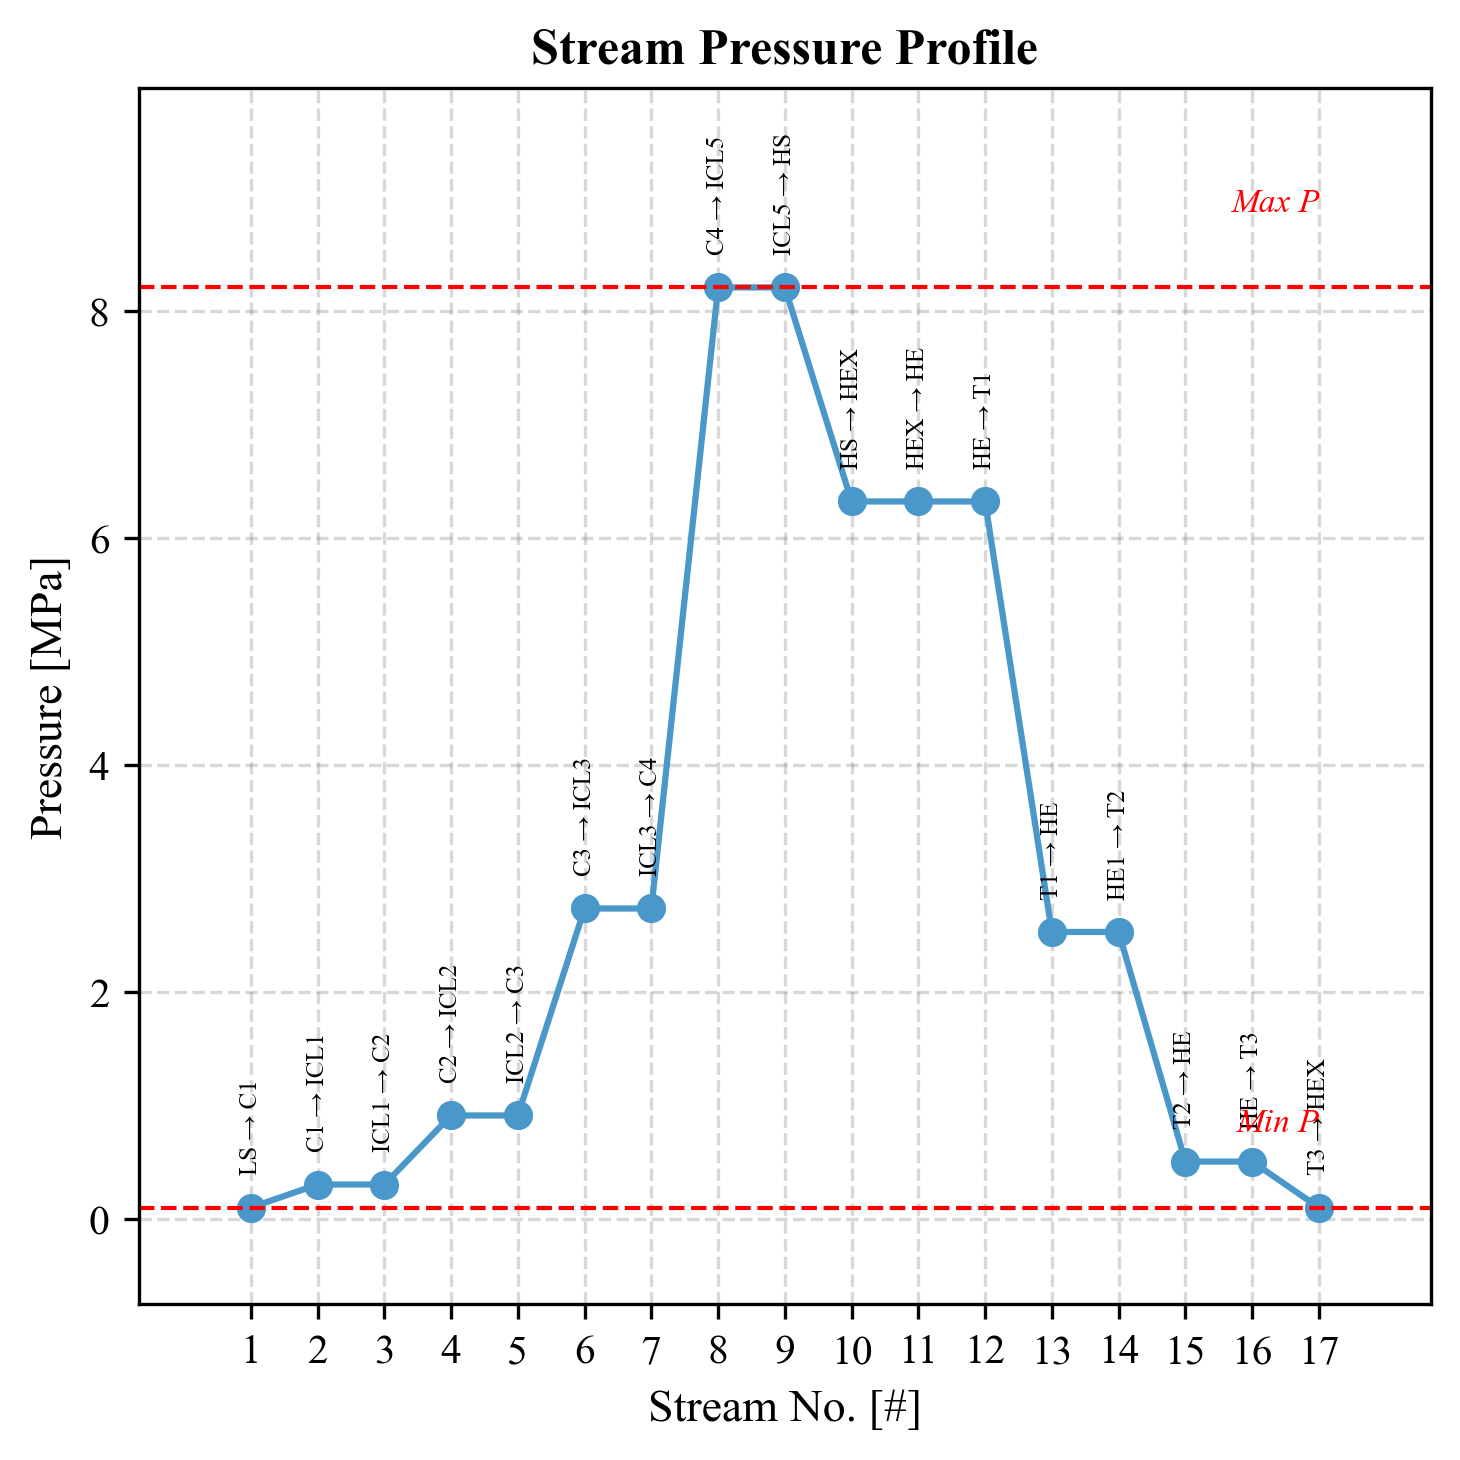

In [102]:
Thermodynamic_variable        = 'Pressure'
Thermodynamic_variable_symbol = 'P'
Units                         = 'MPa'
Figure_title                  = f'Stream {Thermodynamic_variable} Profile'

x_data = df['Stream_#'].astype(int); x_label = x_data.max(); y_data = df[Thermodynamic_variable_symbol]; Max_y  = y_data.max(); Min_y  = y_data.min()
cmap       = plt.get_cmap('Blues'); line_color = cmap(0.6)
ax = quant_vis(x=x_data,y=y_data,kind='line',marker='o',color=line_color,xlabel='Stream No. [#]',ylabel=f'{Thermodynamic_variable} [{Units}]',title=Figure_title,figsize=figsize_std,dpi=300)
point_labels = df['From_component'] + ' → ' + df['To_component']
for xi, yi, lbl in zip(x_data, y_data, point_labels):
    ax.annotate(lbl,xy=(xi, yi),xytext=(0, 8),textcoords='offset points',rotation=90,va='bottom',ha='center',fontsize=6,color='black')
ax.axhline(Max_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Max_y + 0.75,f'Max {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.axhline(Min_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Min_y + 0.75,f'Min {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.set_xticks(x_data); ax.set_xticklabels(x_data, fontsize=10); ymin, ymax = ax.get_ylim(); ax.set_ylim(ymin, ymax * 1.1)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

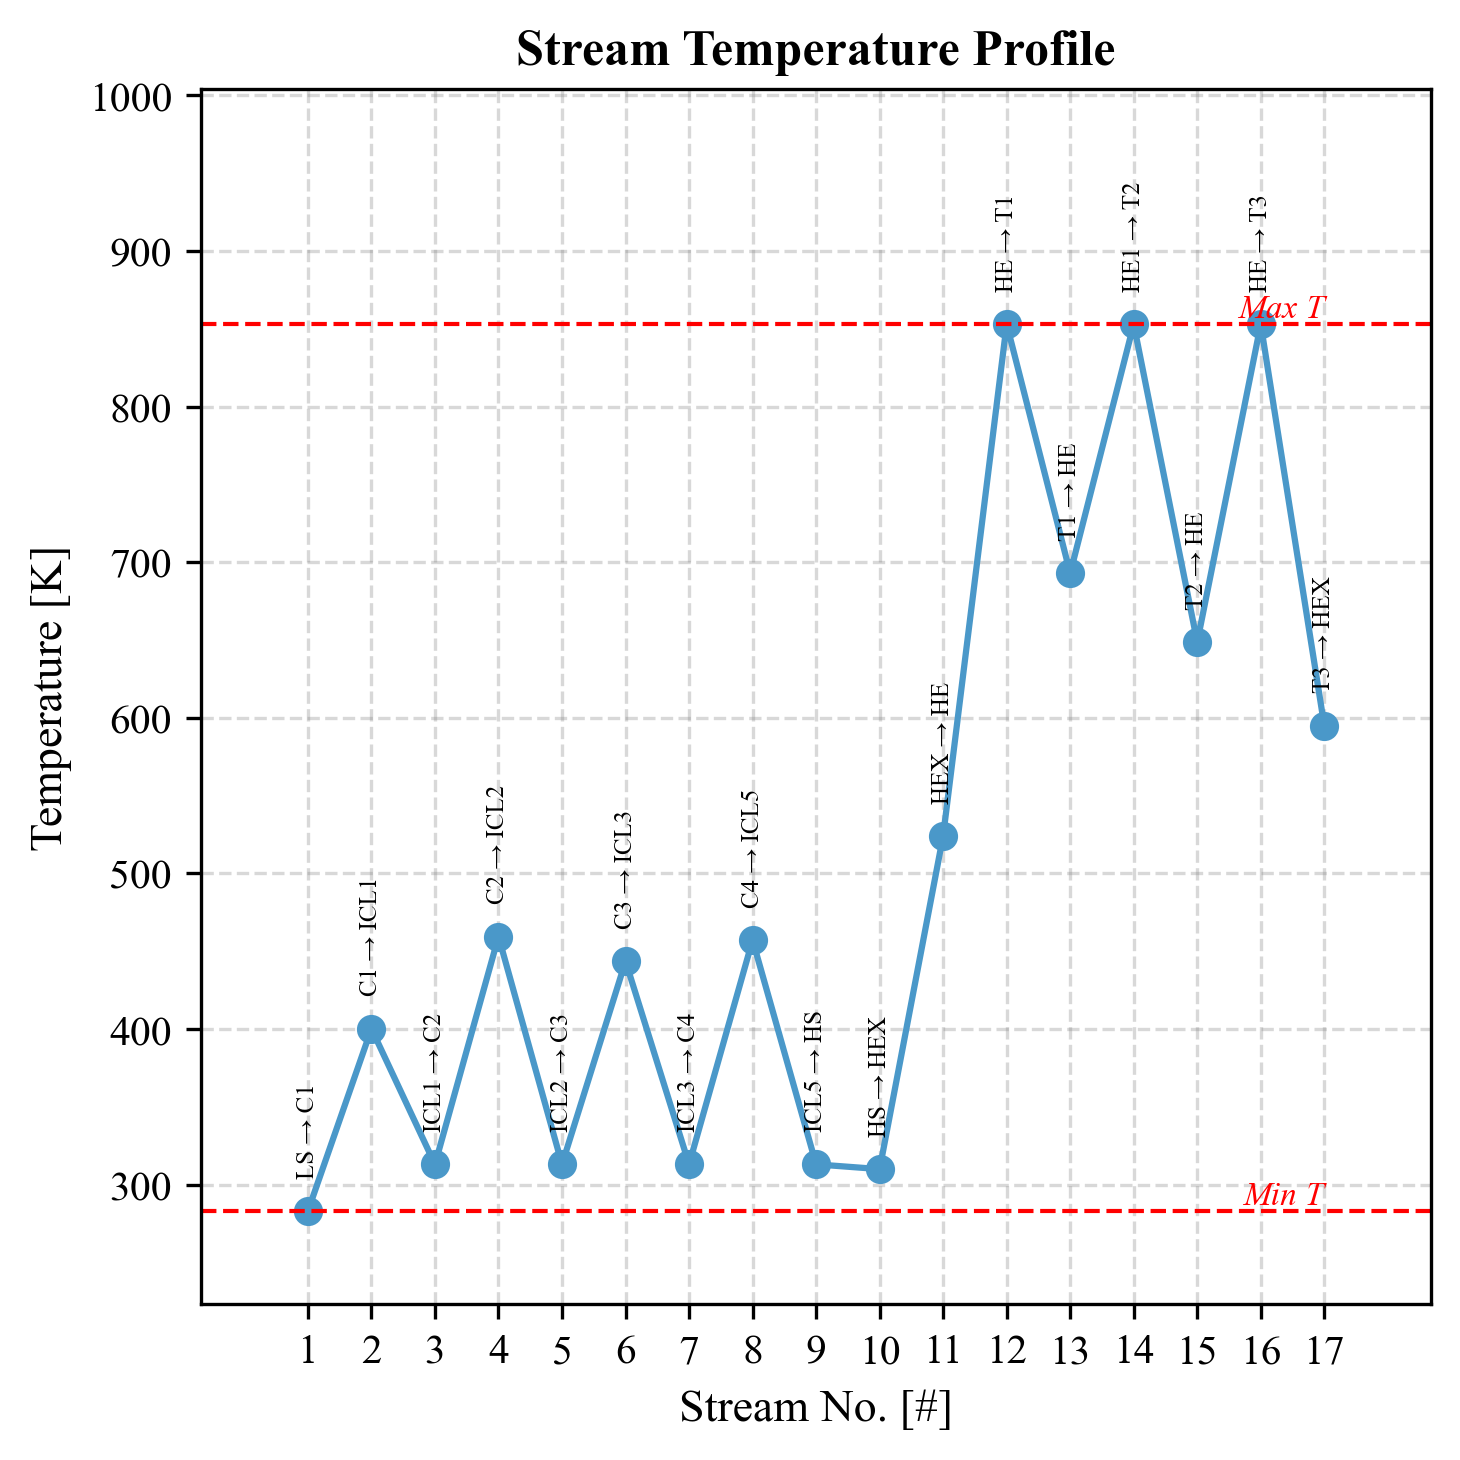

In [103]:
Thermodynamic_variable        = 'Temperature'
Thermodynamic_variable_symbol = 'T'
Units                         = 'K'
Figure_title                  = f'Stream {Thermodynamic_variable} Profile'


x_data = df['Stream_#'].astype(int); x_label = x_data.max(); y_data = df[Thermodynamic_variable_symbol]; Max_y  = y_data.max(); Min_y  = y_data.min()
cmap       = plt.get_cmap('Blues'); line_color = cmap(0.6)
ax = quant_vis(x=x_data,y=y_data,kind='line',marker='o',color=line_color,xlabel='Stream No. [#]',ylabel=f'{Thermodynamic_variable} [{Units}]',title=Figure_title,figsize=figsize_std,dpi=300)
point_labels = df['From_component'] + ' → ' + df['To_component']
for xi, yi, lbl in zip(x_data, y_data, point_labels):
    ax.annotate(lbl,xy=(xi, yi),xytext=(0, 8),textcoords='offset points',rotation=90,va='bottom',ha='center',fontsize=6,color='black')
ax.axhline(Max_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Max_y + 10,f'Max {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.axhline(Min_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Min_y + 10,f'Min {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.set_xticks(x_data); ax.set_xticklabels(x_data, fontsize=10); ymin, ymax = ax.get_ylim(); ax.set_ylim(ymin, ymax * 1.1)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

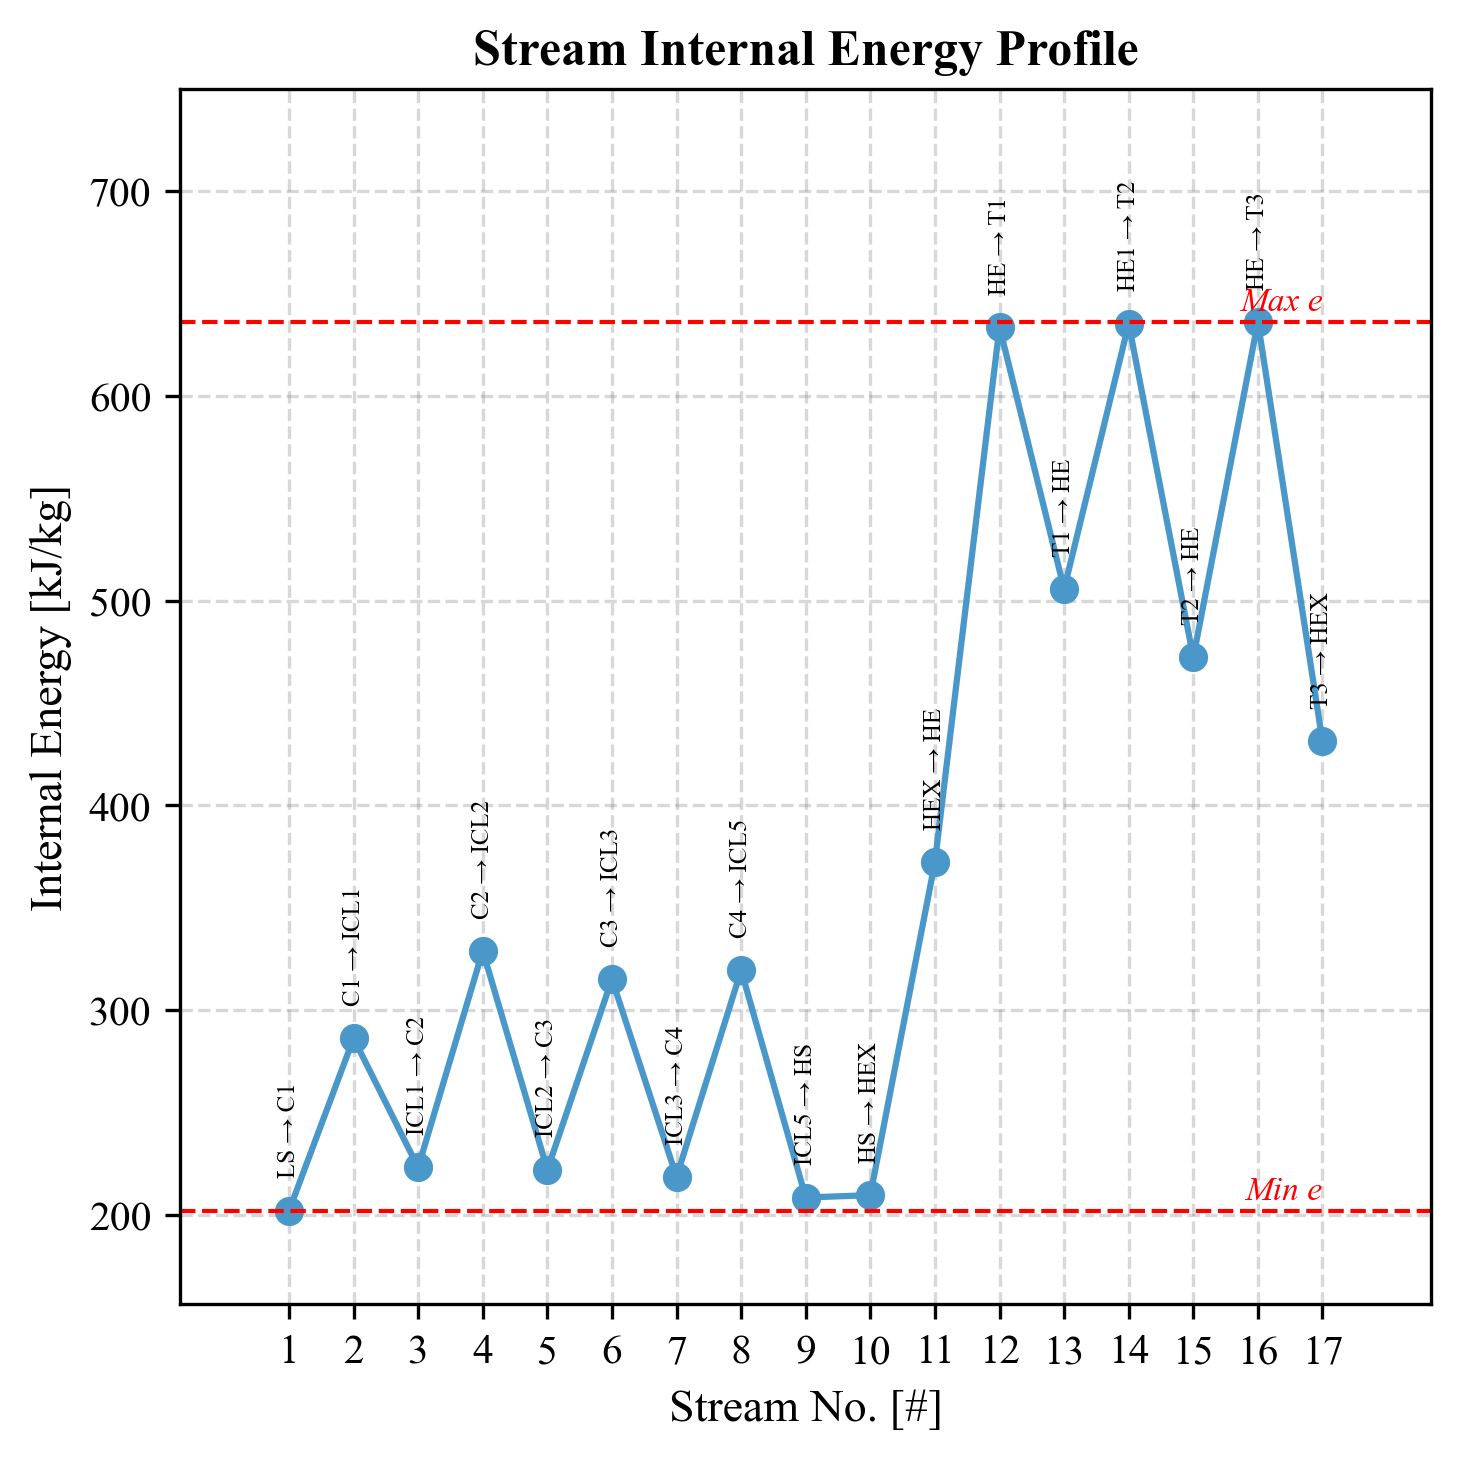

In [104]:
Thermodynamic_variable        = 'Internal Energy'
Thermodynamic_variable_symbol = 'e'
Units                         = 'kJ/kg'
Figure_title                  = f'Stream {Thermodynamic_variable} Profile'


x_data = df['Stream_#'].astype(int); x_label = x_data.max(); y_data = df[Thermodynamic_variable_symbol]; Max_y  = y_data.max(); Min_y  = y_data.min()
cmap       = plt.get_cmap('Blues'); line_color = cmap(0.6)
ax = quant_vis(x=x_data,y=y_data,kind='line',marker='o',color=line_color,xlabel='Stream No. [#]',ylabel=f'{Thermodynamic_variable} [{Units}]',title=Figure_title,figsize=figsize_std,dpi=300)
point_labels = df['From_component'] + ' → ' + df['To_component']
for xi, yi, lbl in zip(x_data, y_data, point_labels):
    ax.annotate(lbl,xy=(xi, yi),xytext=(0, 8),textcoords='offset points',rotation=90,va='bottom',ha='center',fontsize=6,color='black')
ax.axhline(Max_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Max_y + 10,f'Max {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.axhline(Min_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Min_y + 10,f'Min {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.set_xticks(x_data); ax.set_xticklabels(x_data, fontsize=10); ymin, ymax = ax.get_ylim(); ax.set_ylim(ymin, ymax * 1.1)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

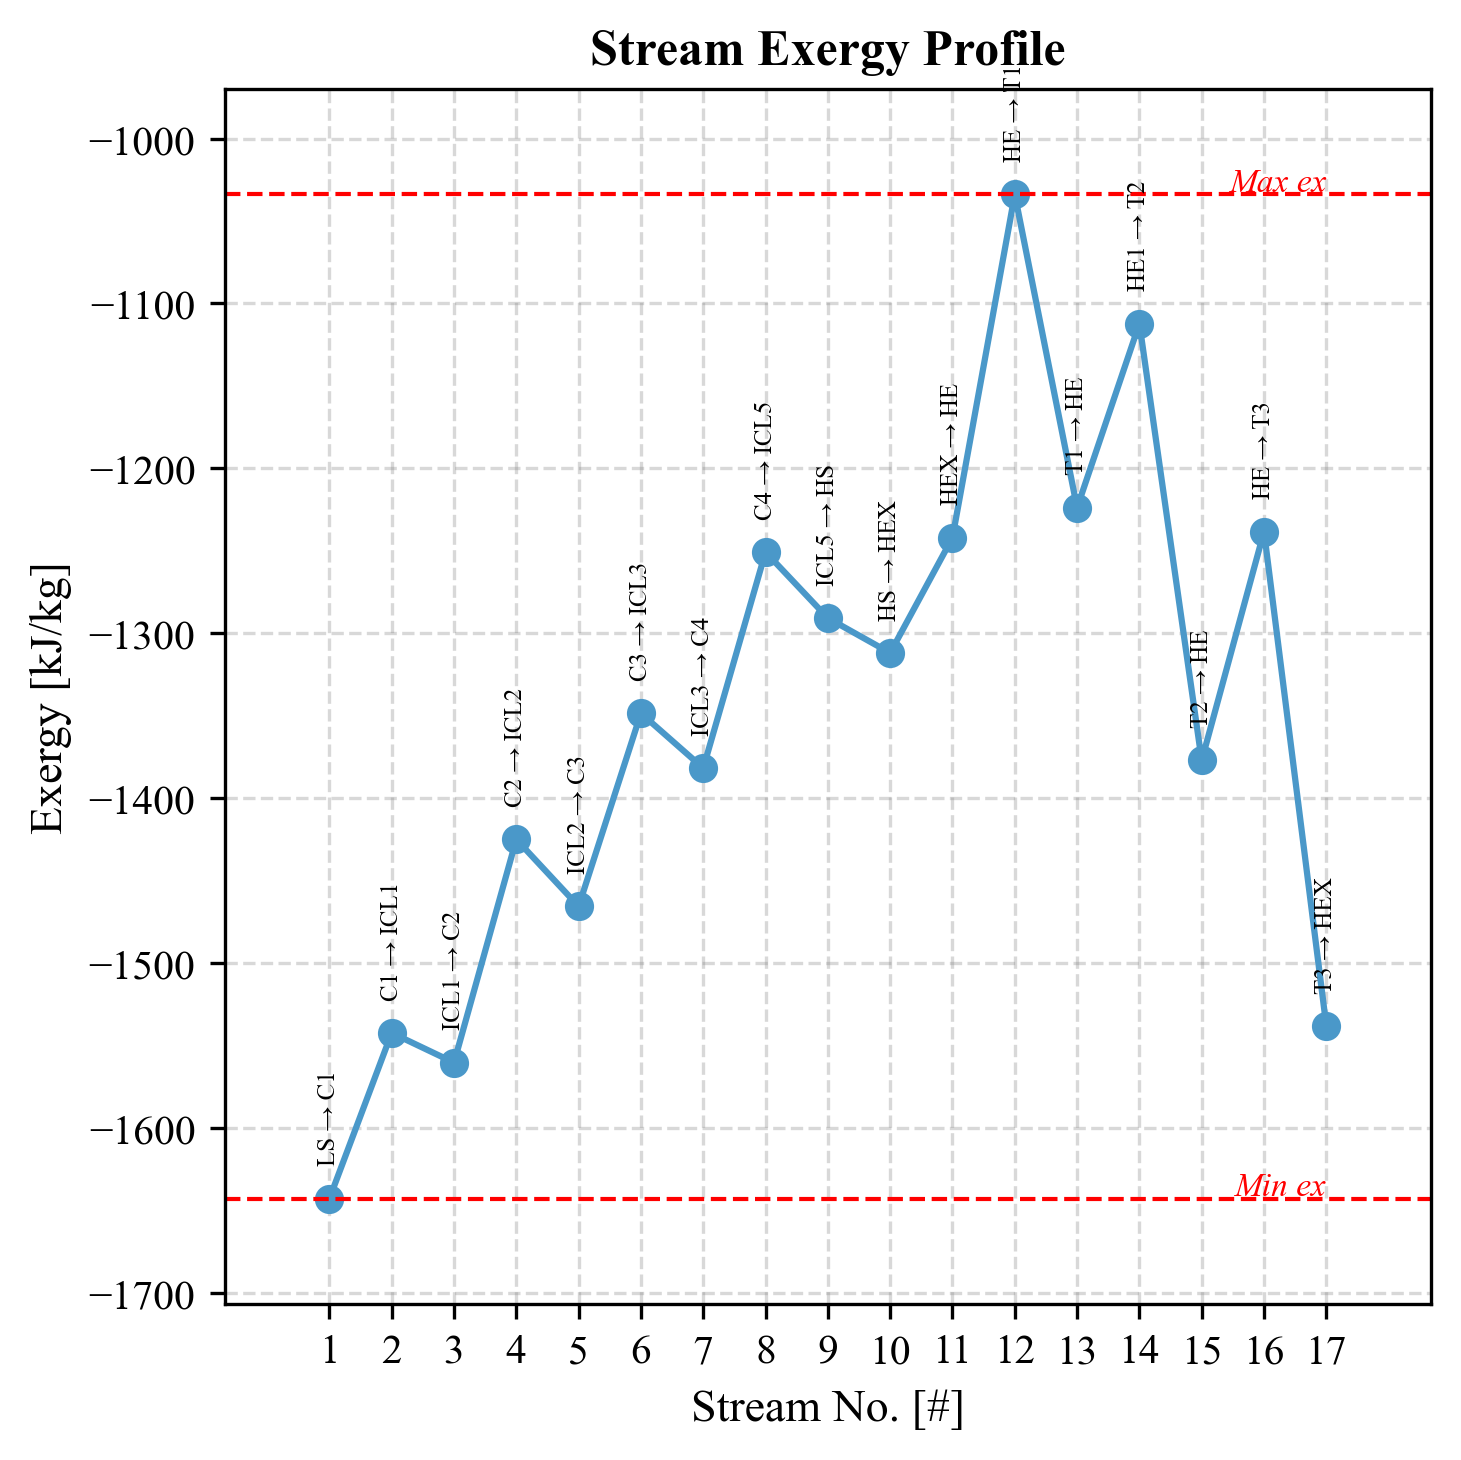

In [105]:
Thermodynamic_variable        = 'Exergy'
Thermodynamic_variable_symbol = 'ex'
Units                         = 'kJ/kg'
Figure_title                  = f'Stream {Thermodynamic_variable} Profile'


x_data = df['Stream_#'].astype(int); x_label = x_data.max()
y_data = df[Thermodynamic_variable_symbol]
Max_y   = y_data.max(); Min_y   = y_data.min()


cmap       = plt.get_cmap('Blues')
line_color = cmap(0.6)
ax = quant_vis(x=x_data,y=y_data,kind='line',marker='o',color=line_color,xlabel='Stream No. [#]',ylabel=f'{Thermodynamic_variable} [{Units}]',title=Figure_title,figsize=figsize_std, dpi=300)
point_labels = df['From_component'] + ' → ' + df['To_component']
for xi, yi, lbl in zip(x_data, y_data, point_labels):
    ax.annotate(lbl,xy=(xi, yi),xytext=(0, 8),textcoords='offset points',rotation=90,va='bottom',ha='center',fontsize=6,color='black')
ax.axhline(Max_y, color='red', linestyle='--', linewidth=1)
ax.text(x_label,Max_y + 7.5,f'Max {Thermodynamic_variable_symbol}',ha='right',va='center',fontsize=8,color='red',fontstyle='italic',clip_on=False)
ax.axhline(Min_y, color='red', linestyle='--', linewidth=1)
ax.text(x_label,Min_y + 7.5,f'Min {Thermodynamic_variable_symbol}',ha='right',va='center',fontsize=8,color='red',fontstyle='italic',clip_on=False)
ax.set_xticks(x_data);ax.set_xticklabels(x_data, fontsize=10); ax.margins(y=0.1)  # add 10% head- and tail-room


plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

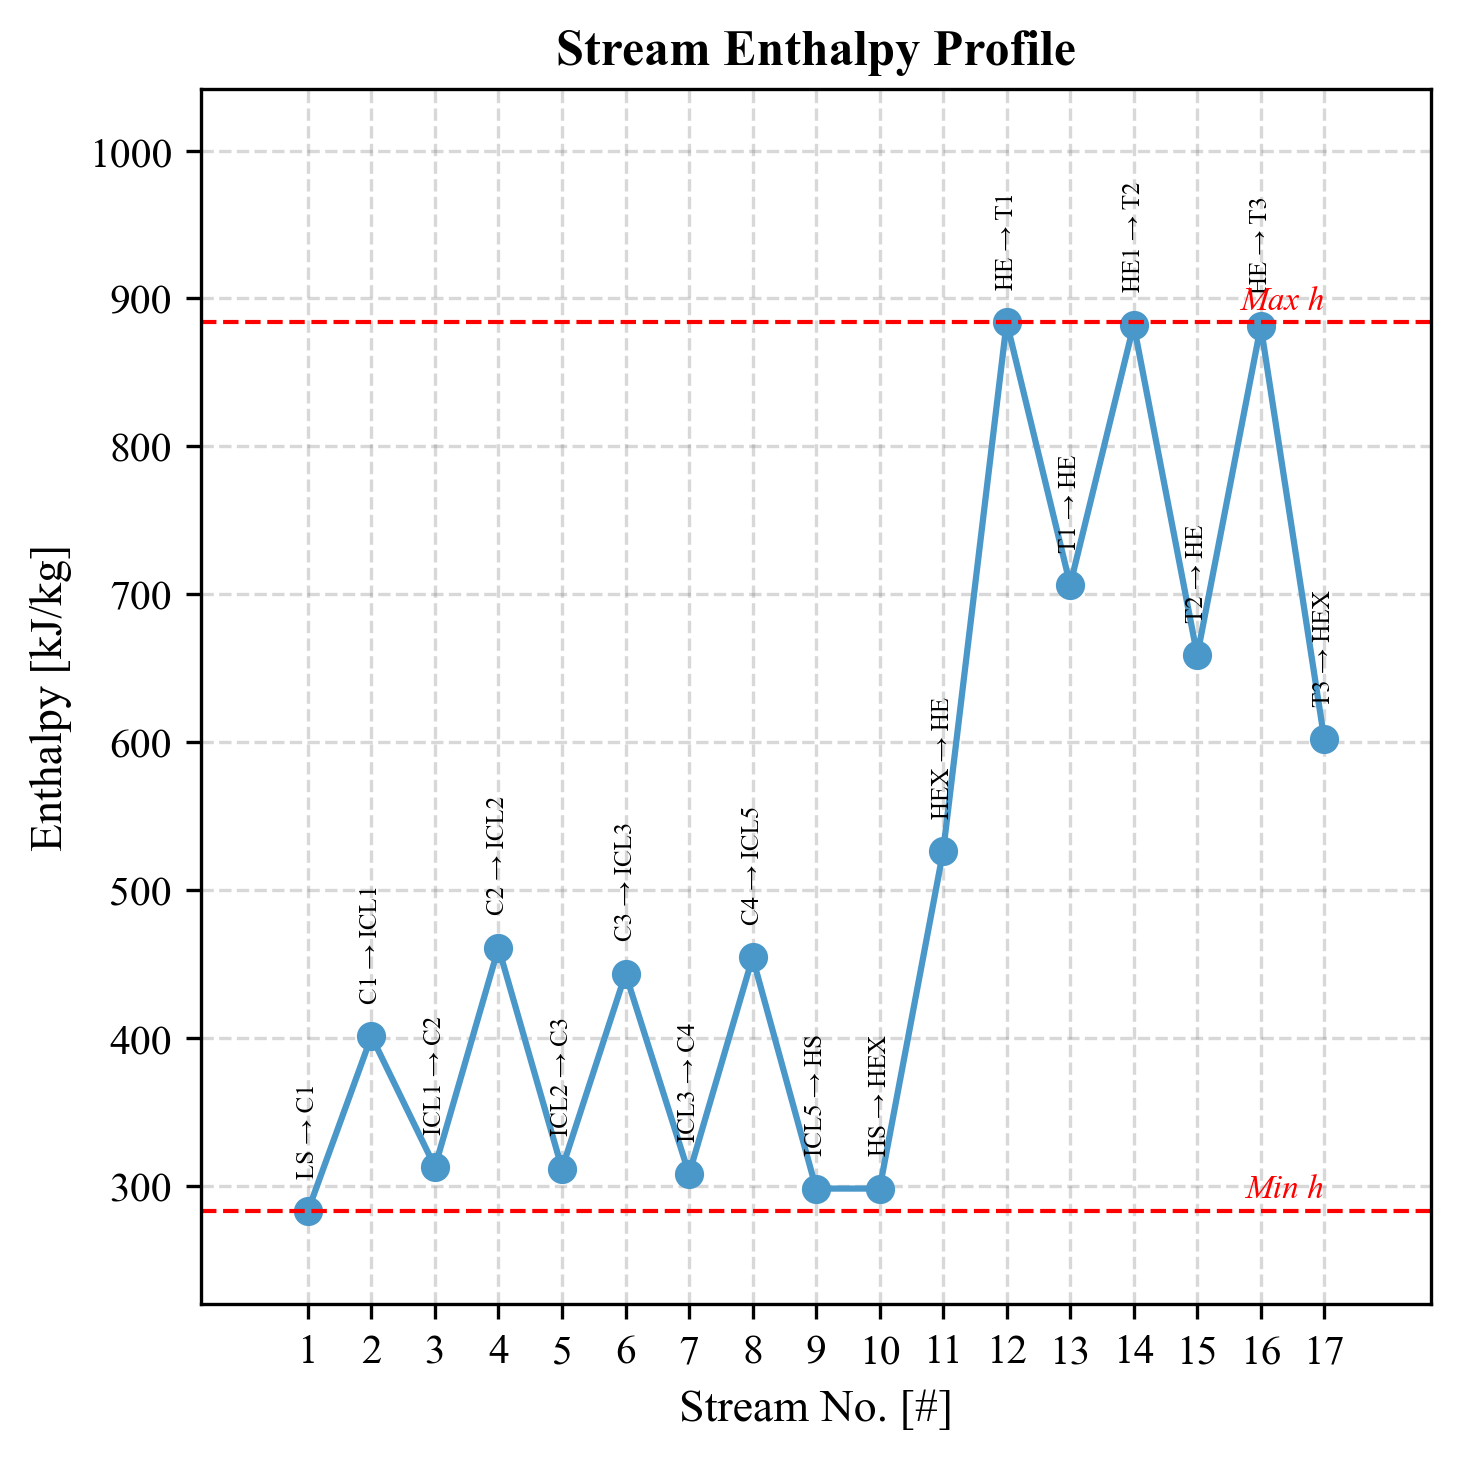

In [106]:
Thermodynamic_variable        = 'Enthalpy'
Thermodynamic_variable_symbol = 'h'
Units                         = 'kJ/kg'
Figure_title                  = f'Stream {Thermodynamic_variable} Profile'


x_data = df['Stream_#'].astype(int); x_label = x_data.max(); y_data = df[Thermodynamic_variable_symbol]; Max_y  = y_data.max(); Min_y  = y_data.min()
cmap       = plt.get_cmap('Blues'); line_color = cmap(0.6)
ax = quant_vis(x=x_data,y=y_data,kind='line',marker='o',color=line_color,xlabel='Stream No. [#]',ylabel=f'{Thermodynamic_variable} [{Units}]',title=Figure_title,figsize=figsize_std,dpi=300)
point_labels = df['From_component'] + ' → ' + df['To_component']
for xi, yi, lbl in zip(x_data, y_data, point_labels):
    ax.annotate(lbl,xy=(xi, yi),xytext=(0, 8),textcoords='offset points',rotation=90,va='bottom',ha='center',fontsize=6,color='black')
ax.axhline(Max_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Max_y + 15,f'Max {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.axhline(Min_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Min_y + 15,f'Min {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.set_xticks(x_data); ax.set_xticklabels(x_data, fontsize=10); ymin, ymax = ax.get_ylim(); ax.set_ylim(ymin, ymax * 1.1)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

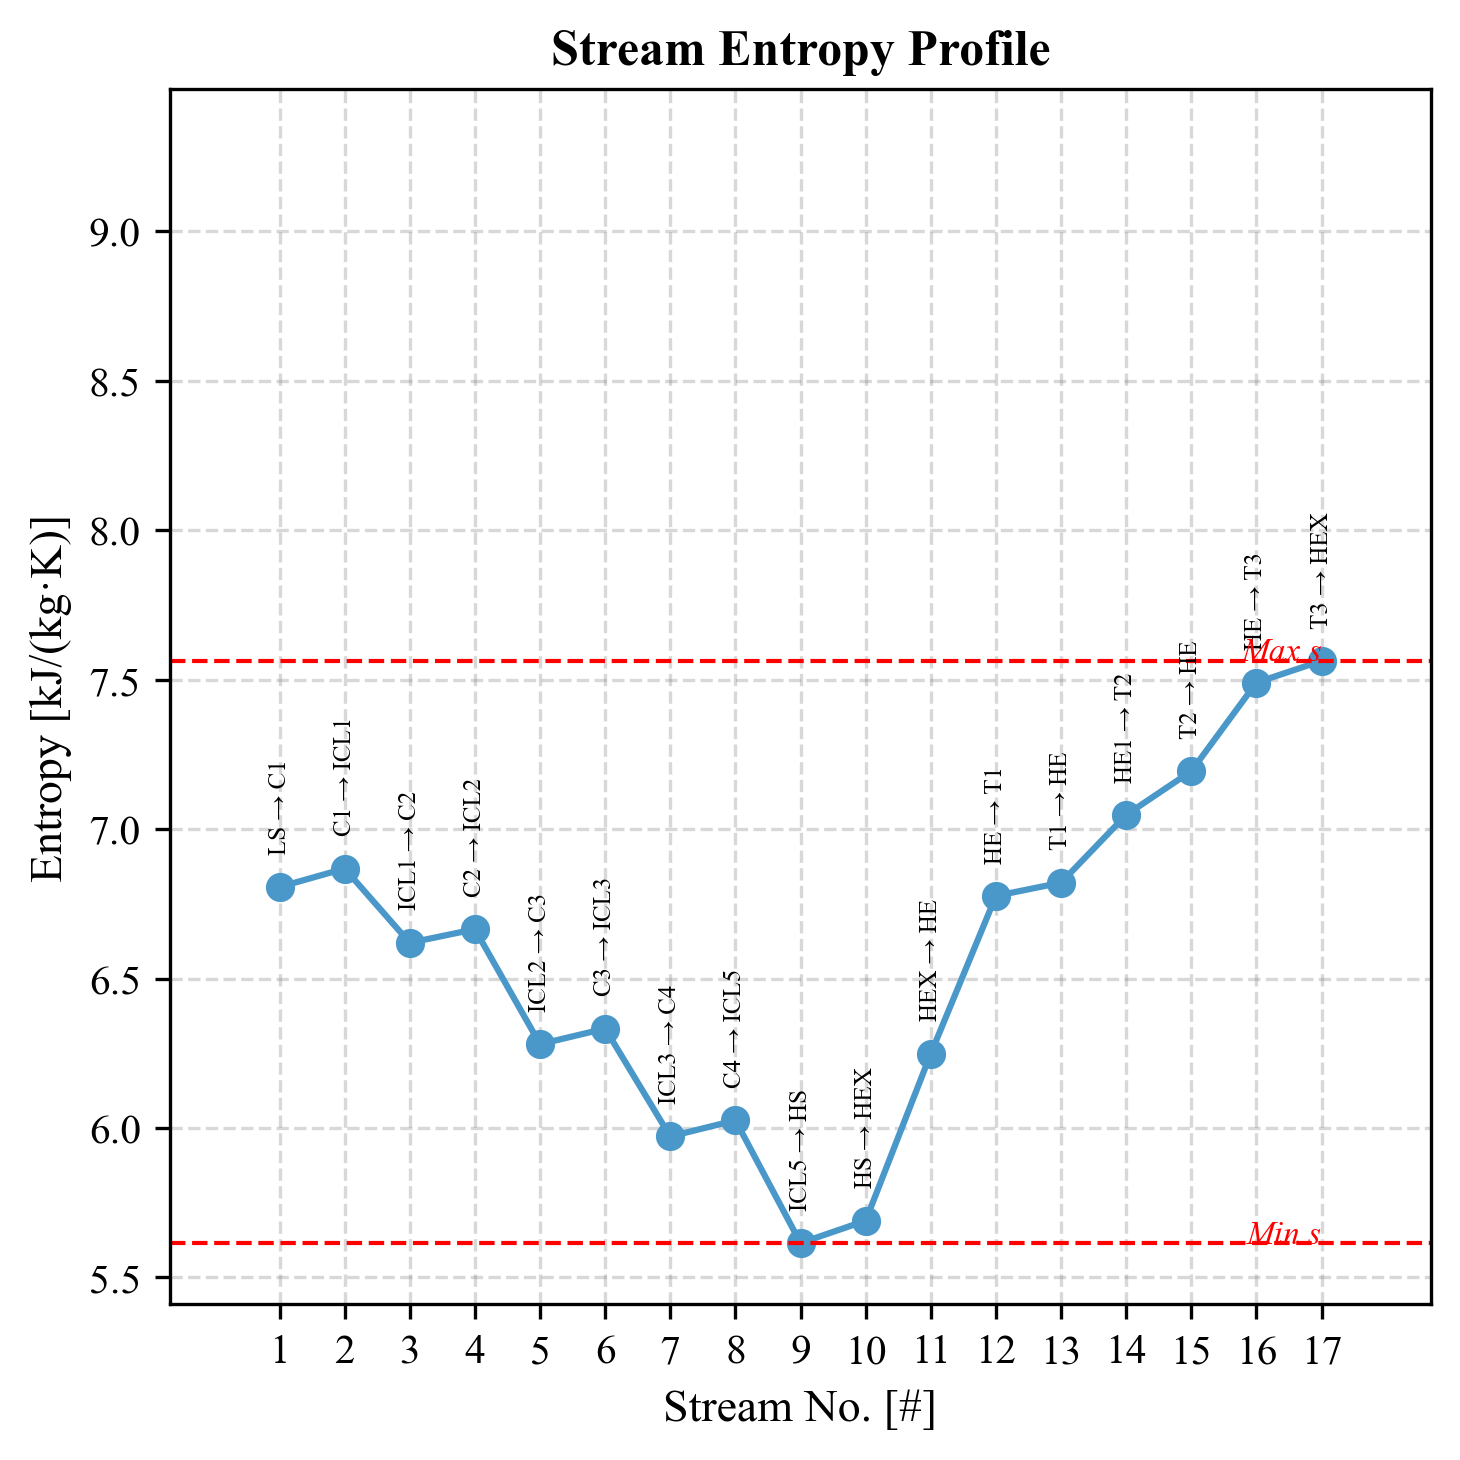

In [107]:
Thermodynamic_variable        = 'Entropy'
Thermodynamic_variable_symbol = 's'
Units                         = 'kJ/(kg·K)'
Figure_title                  = f'Stream {Thermodynamic_variable} Profile'


x_data = df['Stream_#'].astype(int); x_label = x_data.max(); y_data = df[Thermodynamic_variable_symbol]; Max_y  = y_data.max(); Min_y  = y_data.min()
cmap       = plt.get_cmap('Blues'); line_color = cmap(0.6)
ax = quant_vis(x=x_data,y=y_data,kind='line',marker='o',color=line_color,xlabel='Stream No. [#]',ylabel=f'{Thermodynamic_variable} [{Units}]',title=Figure_title,figsize=figsize_std,dpi=300)
point_labels = df['From_component'] + ' → ' + df['To_component']
for xi, yi, lbl in zip(x_data, y_data, point_labels):
    ax.annotate(lbl,xy=(xi, yi),xytext=(0, 8),textcoords='offset points',rotation=90,va='bottom',ha='center',fontsize=6,color='black')
ax.axhline(Max_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Max_y + 0.03,f'Max {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.axhline(Min_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Min_y + 0.03,f'Min {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.set_xticks(x_data); ax.set_xticklabels(x_data, fontsize=10); ymin, ymax = ax.get_ylim(); ax.set_ylim(ymin, ymax * 1.22)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

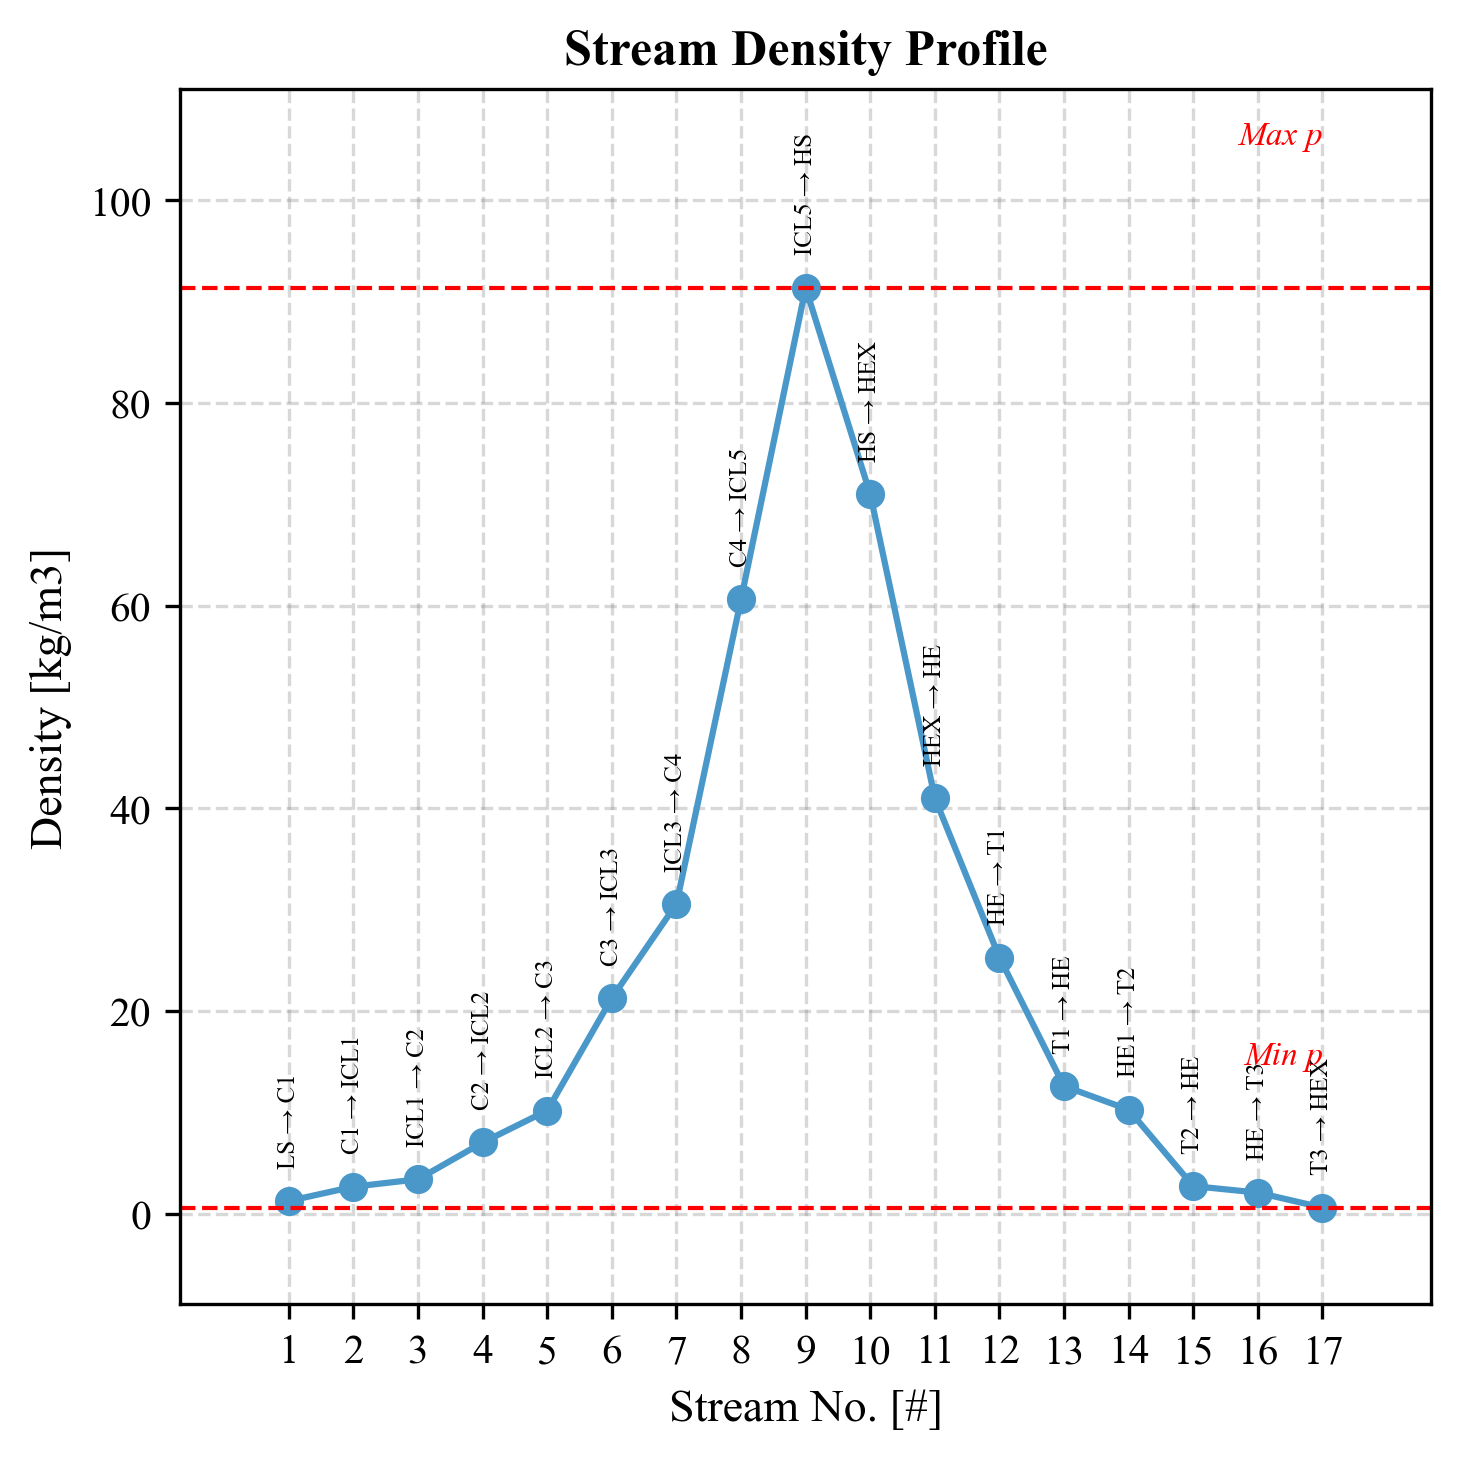

In [108]:
Thermodynamic_variable        = 'Density'
Thermodynamic_variable_symbol = 'p'
Units                         = 'kg/m3'
Figure_title                  = f'Stream {Thermodynamic_variable} Profile'


x_data = df['Stream_#'].astype(int); x_label = x_data.max(); y_data = df[Thermodynamic_variable_symbol]; Max_y  = y_data.max(); Min_y  = y_data.min()
cmap       = plt.get_cmap('Blues'); line_color = cmap(0.6)
ax = quant_vis(x=x_data,y=y_data,kind='line',marker='o',color=line_color,xlabel='Stream No. [#]',ylabel=f'{Thermodynamic_variable} [{Units}]',title=Figure_title,figsize=figsize_std,dpi=300)
point_labels = df['From_component'] + ' → ' + df['To_component']
for xi, yi, lbl in zip(x_data, y_data, point_labels):
    ax.annotate(lbl,xy=(xi, yi),xytext=(0, 8),textcoords='offset points',rotation=90,va='bottom',ha='center',fontsize=6,color='black')
ax.axhline(Max_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Max_y + 15,f'Max {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.axhline(Min_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Min_y + 15,f'Min {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.set_xticks(x_data); ax.set_xticklabels(x_data, fontsize=10); ymin, ymax = ax.get_ylim(); ax.set_ylim(ymin, ymax * 1.1)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

### Cycle Visualizations

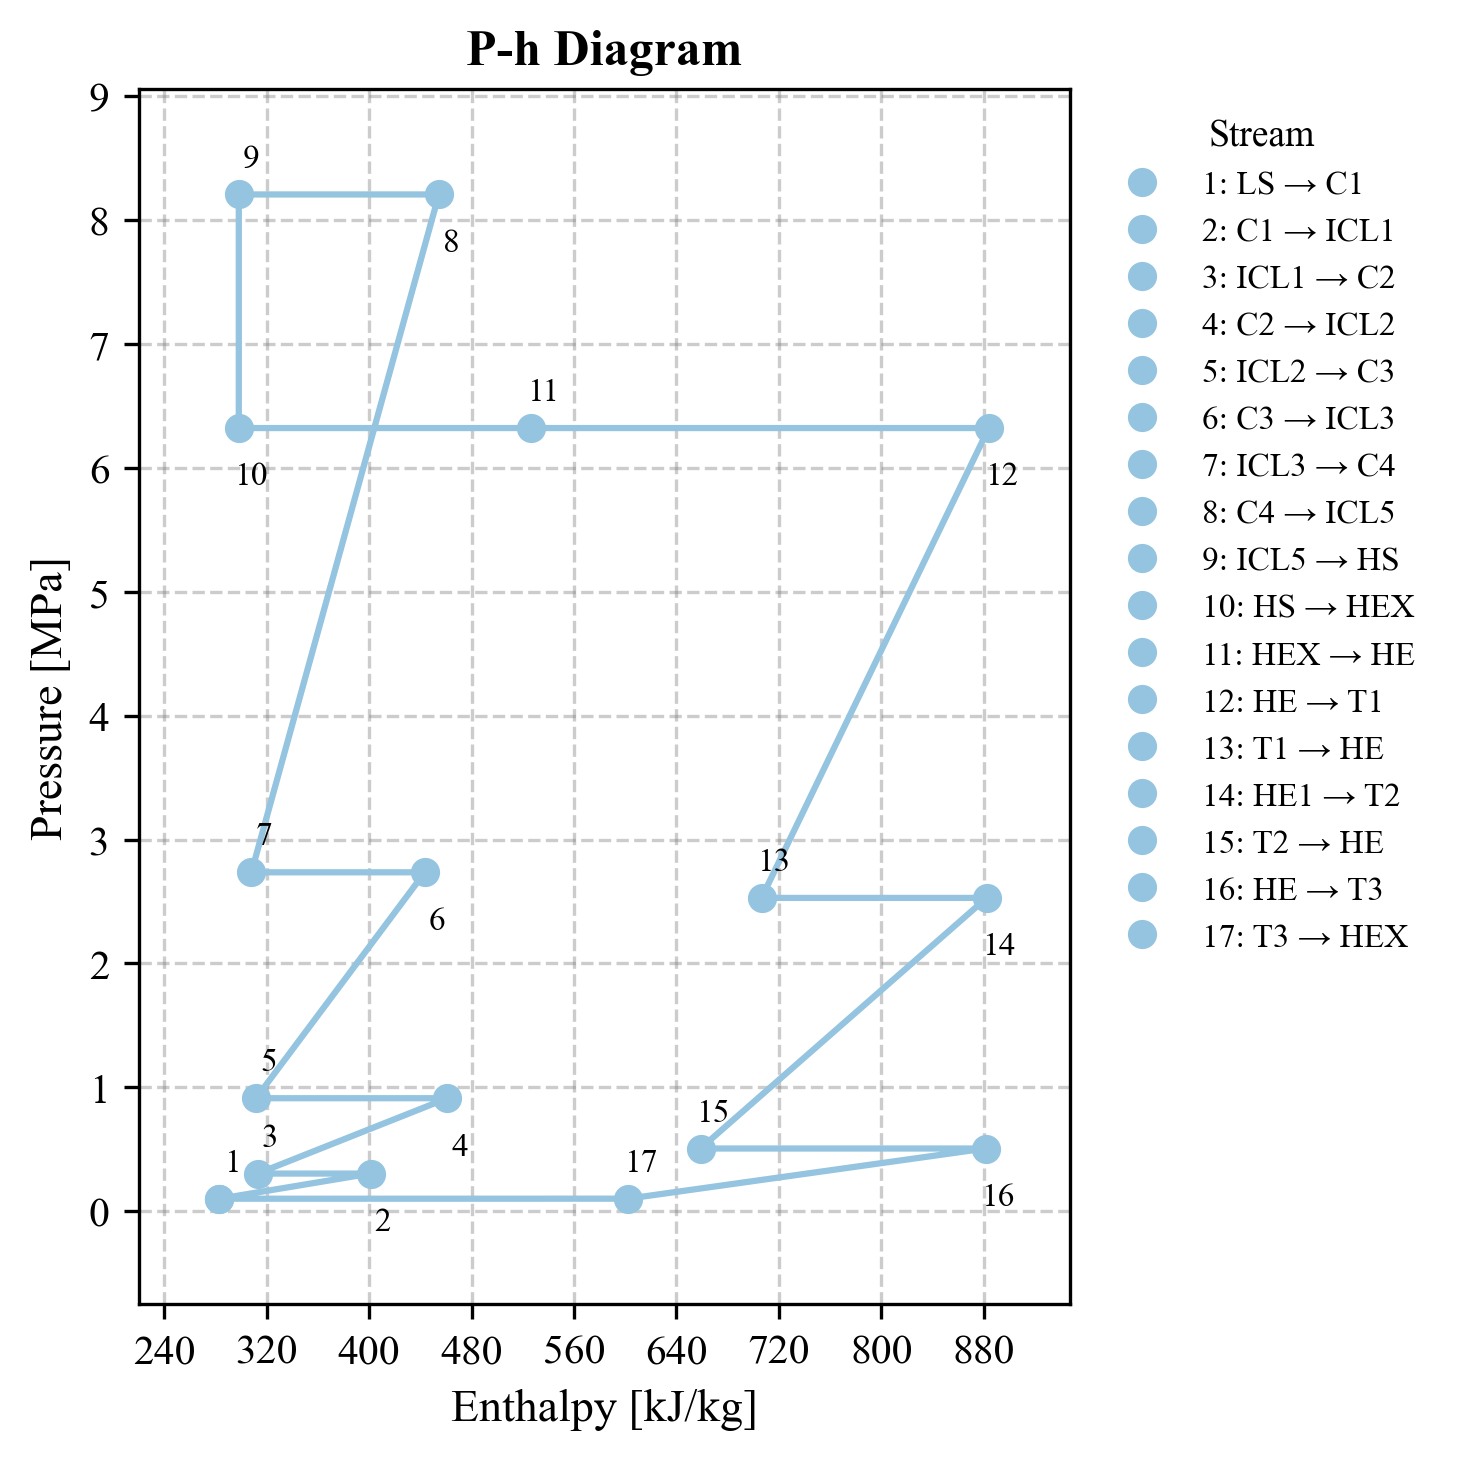

In [109]:
x_var         = 'Enthalpy'
x_var_sym     = 'h'
x_var_units   = 'kJ/kg'
y_var         = 'Pressure'
y_var_sym     = 'P'
y_var_units   = 'MPa'
Figure_title  = f'{y_var_sym}-{x_var_sym} Diagram'


x_orig      = df[x_var_sym].values; y_orig      = df[y_var_sym].values; x_data      = np.append(x_orig, x_orig[0]); y_data      = np.append(y_orig, y_orig[0])
stream_nums   = df['Stream_#'].astype(int).values; stream_labels = df['From_component'] + ' → ' + df['To_component']

cmap      = plt.get_cmap('Blues'); line_color = cmap(0.4)
ax = quant_vis(x=x_data,y=y_data,kind='line',marker='o',color=line_color,xlabel=f'{x_var} [{x_var_units}]',ylabel=f'{y_var} [{y_var_units}]',title=Figure_title,figsize=figsize_std,dpi=300)
ax.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax.yaxis.set_major_locator(MaxNLocator(nbins=10)); ax.grid(True, which='major', linestyle='--', alpha=0.4); offsets = [(3, 5), (3, -8)]
for i, (xi, yi, sn) in enumerate(zip(x_orig, y_orig, stream_nums)):
    dx, dy = offsets[i % len(offsets)]
    ax.annotate(str(sn),xy=(xi, yi),xytext=(dx, dy),textcoords='offset points',fontsize=8,color='black',ha='center',va='bottom' if dy > 0 else 'top')
handles = [Line2D([0], [0], marker='o', color=line_color, linestyle='') for _ in stream_nums]
legend_labels = [f"{sn}: {lbl}" for sn, lbl in zip(stream_nums, stream_labels)]; ax.legend(handles,legend_labels,title='Stream',loc='upper left',bbox_to_anchor=(1.01, 1),fontsize=8,title_fontsize=9,frameon=False)
plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

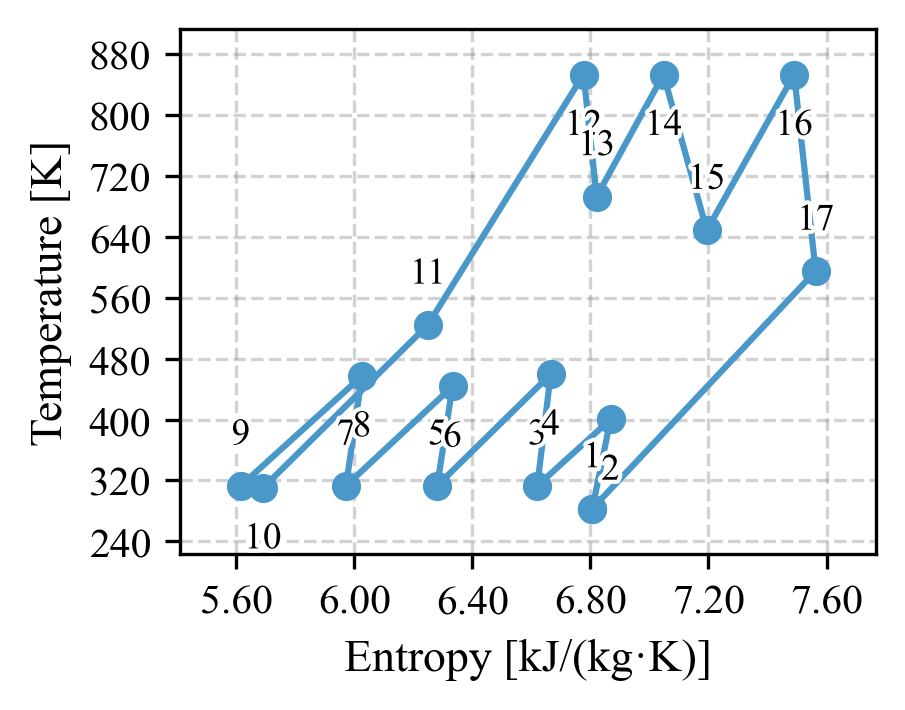

In [110]:
x_var         = 'Entropy'
x_var_sym     = 's'
x_var_units   = 'kJ/(kg·K)'
y_var         = 'Temperature'
y_var_sym     = 'T'
y_var_units   = 'K'
Figure_title  = f'{y_var_sym}-{x_var_sym} Diagram'

x_orig      = df[x_var_sym].values
y_orig      = df[y_var_sym].values
x_data      = np.append(x_orig, x_orig[0])
y_data      = np.append(y_orig, y_orig[0])
stream_nums = df['Stream_#'].astype(int).values
stream_labels = df['From_component'] + ' → ' + df['To_component']

cmap        = plt.get_cmap('Blues')
line_color  = cmap(0.6)

ax = quant_vis(
    x=x_data, y=y_data, kind='line', marker='o', color=line_color,
    xlabel=f'{x_var} [{x_var_units}]',
    ylabel=f'{y_var} [{y_var_units}]',
    title="",   # remove figure title
    figsize=(3.15, 2.5), dpi=300
)

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 11
})

from matplotlib.ticker import MaxNLocator, FuncFormatter
import matplotlib.patheffects as pe

ax.xaxis.set_major_locator(MaxNLocator(nbins=6))                
ax.xaxis.set_major_formatter(FuncFormatter(lambda v, p: f"{v:.2f}"))
ax.yaxis.set_major_locator(MaxNLocator(nbins=10))            

ax.grid(True, which='major', linestyle='--', alpha=0.35)

LABEL_OFFSET = 8  
for i, (xi, yi, sn) in enumerate(zip(x_orig, y_orig, stream_nums)):
    dy = LABEL_OFFSET if (i % 2 == 0) else -LABEL_OFFSET   
    txt = ax.annotate(
        str(sn), xy=(xi, yi), xytext=(0, dy),
        textcoords='offset points', fontsize=9, color='black',
        ha='center', va='bottom' if dy > 0 else 'top', clip_on=False
    )
    txt.set_path_effects([pe.withStroke(linewidth=2, foreground='white')])


ax.legend([], [], frameon=False)

plt.tight_layout()

out_path = fig_dir / f"{Figure_title}.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight')


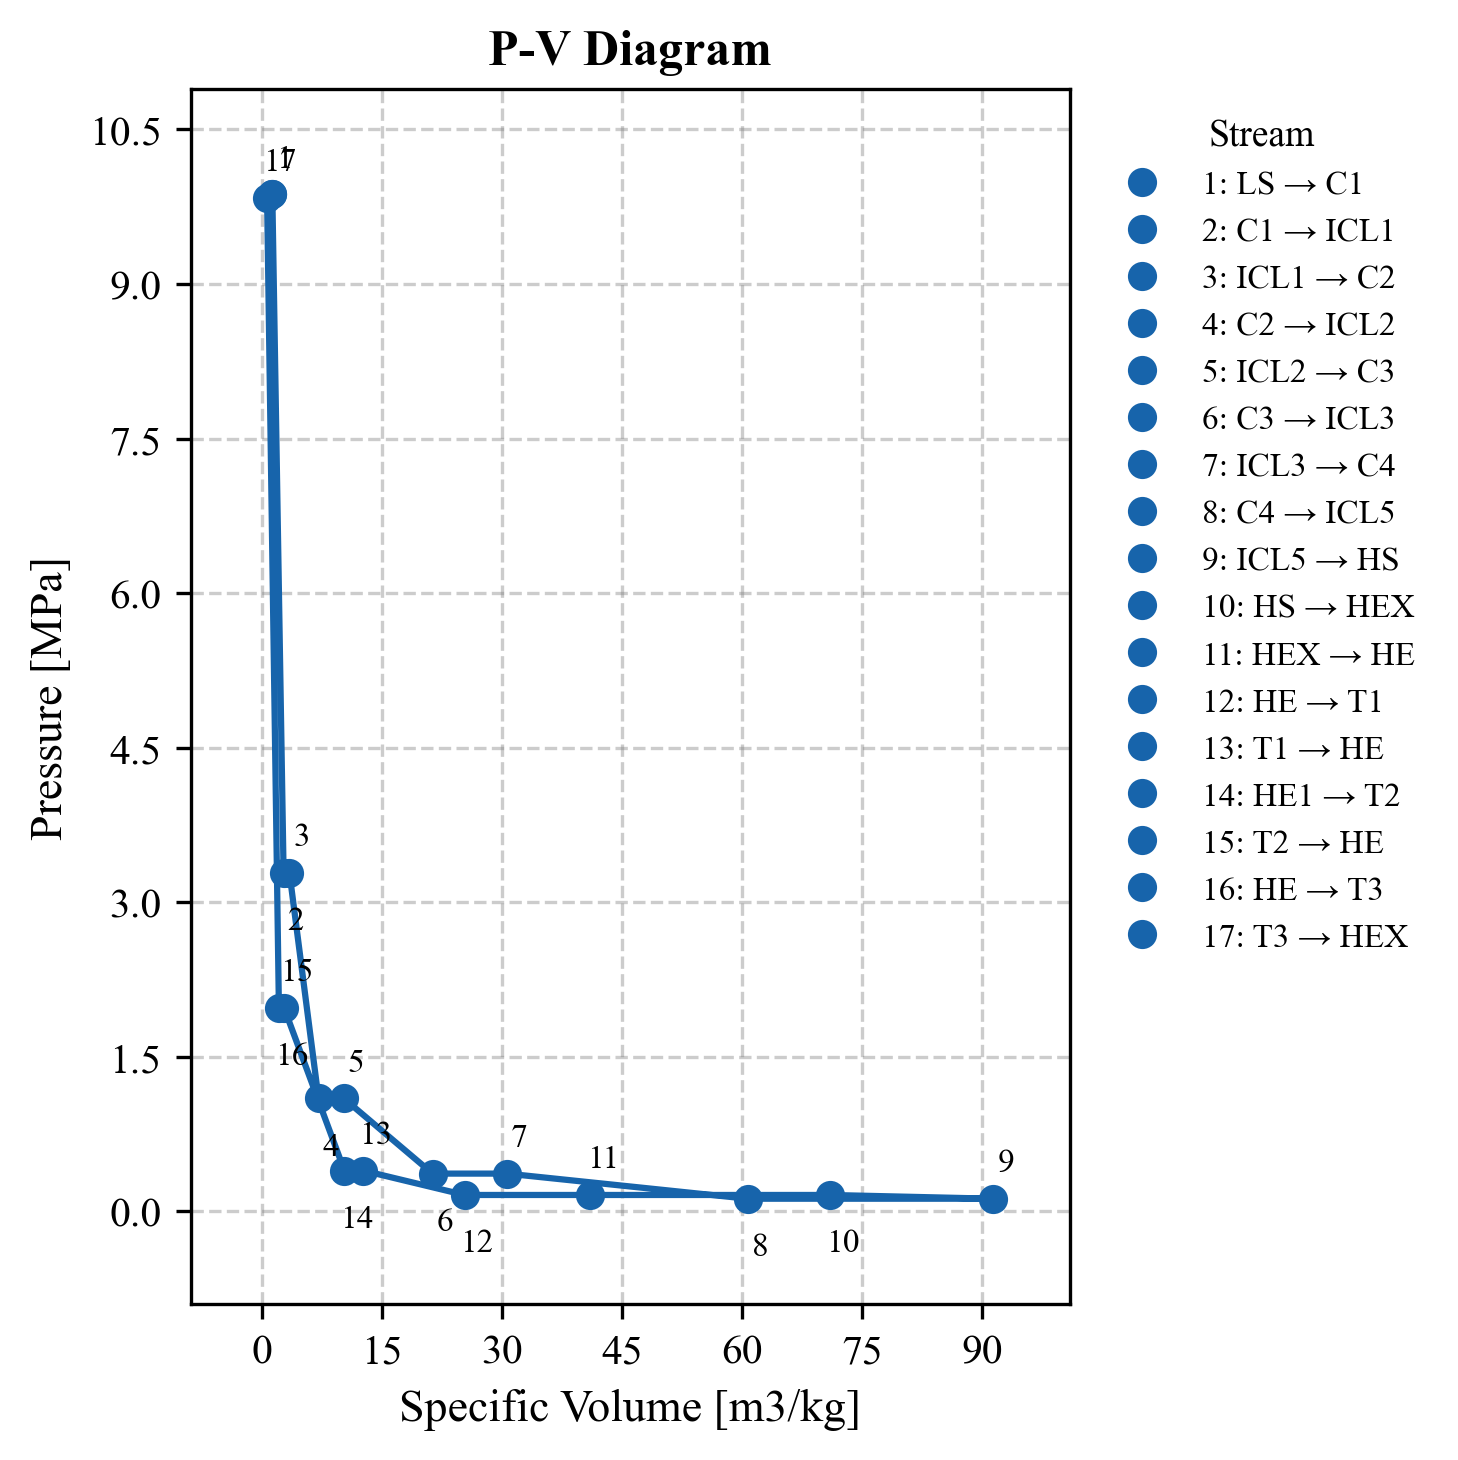

In [111]:
x_var         = 'Specific Volume'
x_var_sym     = 'p'
x_var_units   = 'm3/kg'
y_var         = 'Pressure'
y_var_sym     = 'P'
y_var_units   = 'MPa'
Figure_title  = f'{y_var_sym}-V Diagram'


x_orig      = df[x_var_sym].values; y_orig      = df[y_var_sym].values; y_orig = 1/y_orig; x_data      = np.append(x_orig, x_orig[0]); y_data      = np.append(y_orig, y_orig[0])
stream_nums   = df['Stream_#'].astype(int).values; stream_labels = df['From_component'] + ' → ' + df['To_component']

cmap      = plt.get_cmap('Blues'); line_color = cmap(0.8)
ax = quant_vis(x=x_data,y=y_data,kind='line',marker='o',color=line_color,xlabel=f'{x_var} [{x_var_units}]',ylabel=f'{y_var} [{y_var_units}]',title=Figure_title,figsize=figsize_std,dpi=300)
ax.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax.yaxis.set_major_locator(MaxNLocator(nbins=10)); ax.grid(True, which='major', linestyle='--', alpha=0.4); offsets = [(3, 5), (3, -8)]
for i, (xi, yi, sn) in enumerate(zip(x_orig, y_orig, stream_nums)):
    dx, dy = offsets[i % len(offsets)]
    ax.annotate(str(sn),xy=(xi, yi),xytext=(dx, dy),textcoords='offset points',fontsize=8,color='black',ha='center',va='bottom' if dy > 0 else 'top')
handles = [Line2D([0], [0], marker='o', color=line_color, linestyle='') for _ in stream_nums]
legend_labels = [f"{sn}: {lbl}" for sn, lbl in zip(stream_nums, stream_labels)]; ax.legend(handles,legend_labels,title='Stream',loc='upper left',bbox_to_anchor=(1.01, 1),fontsize=8,title_fontsize=9,frameon=False)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

### Storage Visualizations

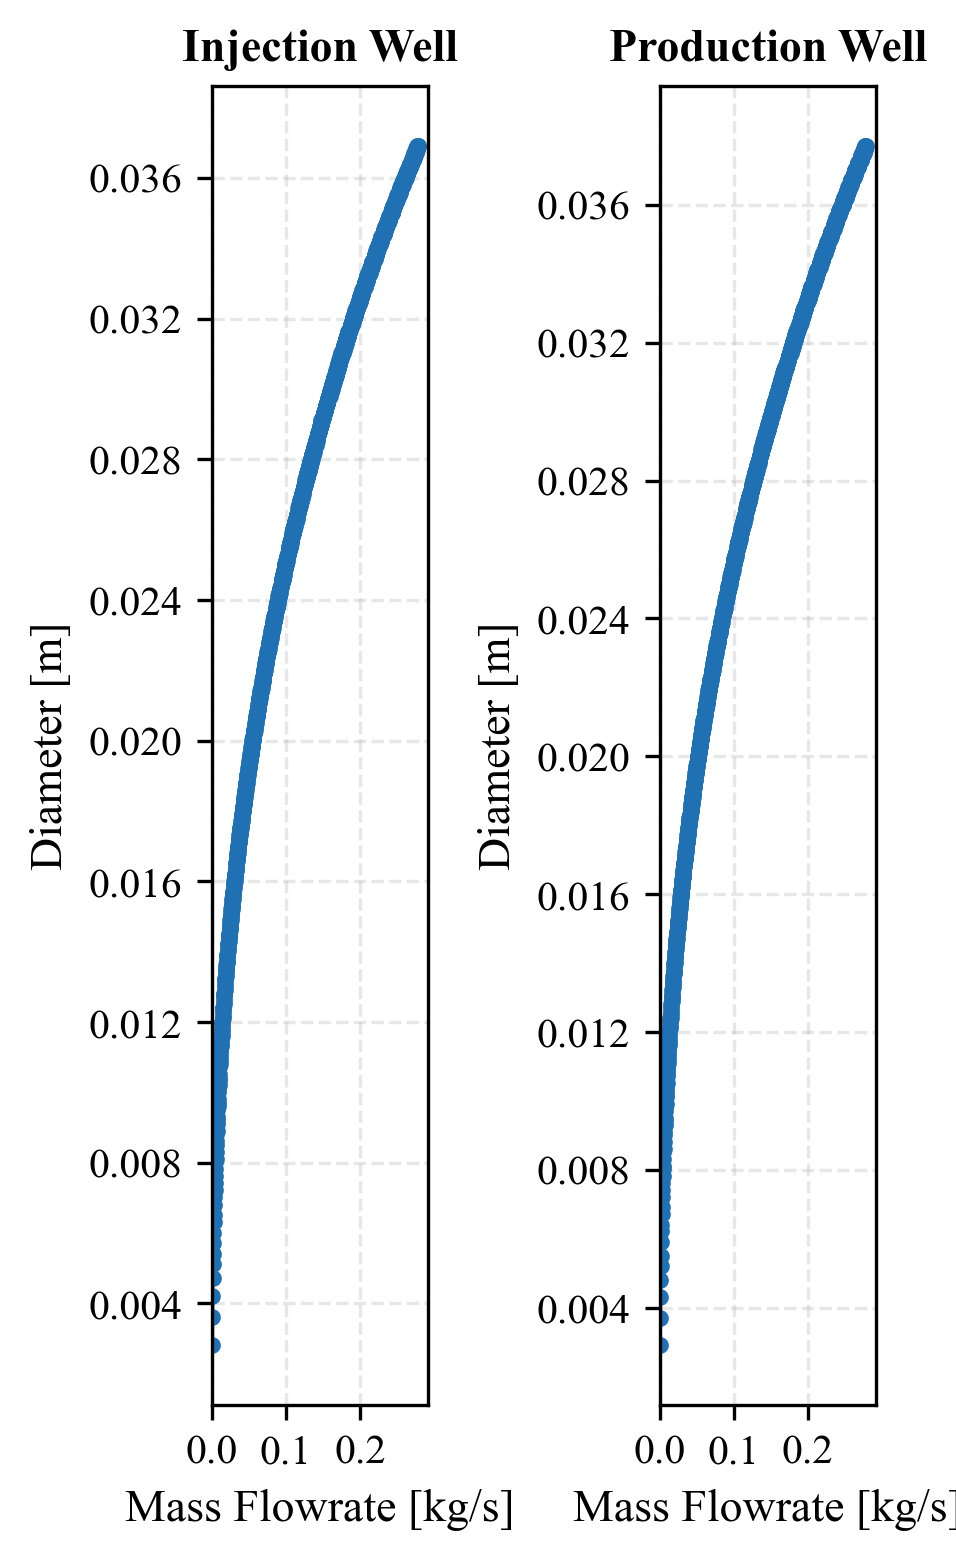

In [112]:
from matplotlib.ticker import MaxNLocator

Figure_title = f'Required Well Diameters - fric:{gradP} MPa/m'
File_title   = 'Required_Well_Diameters'

fig, axs = plt.subplots(ncols=2, figsize=(3.15, 5.5), dpi=300)

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 11
})

cmap    = plt.get_cmap('Blues')
hues    = np.linspace(0.3, 0.975, 4)
colors  = cmap(hues)
line_clr = colors[2]  # single readable blue

ax = axs[0]
ax.plot(
    dfDm_HS_inj_well['mdot'],
    dfDm_HS_inj_well['Dsol'],
    marker='o', markersize=3, linewidth=1, color=line_clr
)
ax.set_xlabel('Mass Flowrate [kg/s]')
ax.set_ylabel('Diameter [m]')
ax.set_title('Injection Well', fontsize=11)
ax.grid(True, which='both', linestyle='--', alpha=0.3)
ax.xaxis.set_major_locator(MaxNLocator(nbins=3)) 
ax.yaxis.set_major_locator(MaxNLocator(nbins=10))  
ax.set_xlim(left=0.00)

ax = axs[1]
ax.plot(
    dfDm_HS_prod_well['mdot'],  
    dfDm_HS_prod_well['Dsol'],
    marker='o', markersize=3, linewidth=1, color=line_clr
)
ax.set_xlabel('Mass Flowrate [kg/s]')
ax.set_ylabel('Diameter [m]')
ax.set_title('Production Well', fontsize=11)
ax.grid(True, which='both', linestyle='--', alpha=0.3)
ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
ax.yaxis.set_major_locator(MaxNLocator(nbins=10))
ax.set_xlim(left=0.00)

for ax in axs:
    ax.legend([], [], frameon=False)

fig.suptitle("")

plt.tight_layout()

out_path = fig_dir / f"{File_title}.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight')


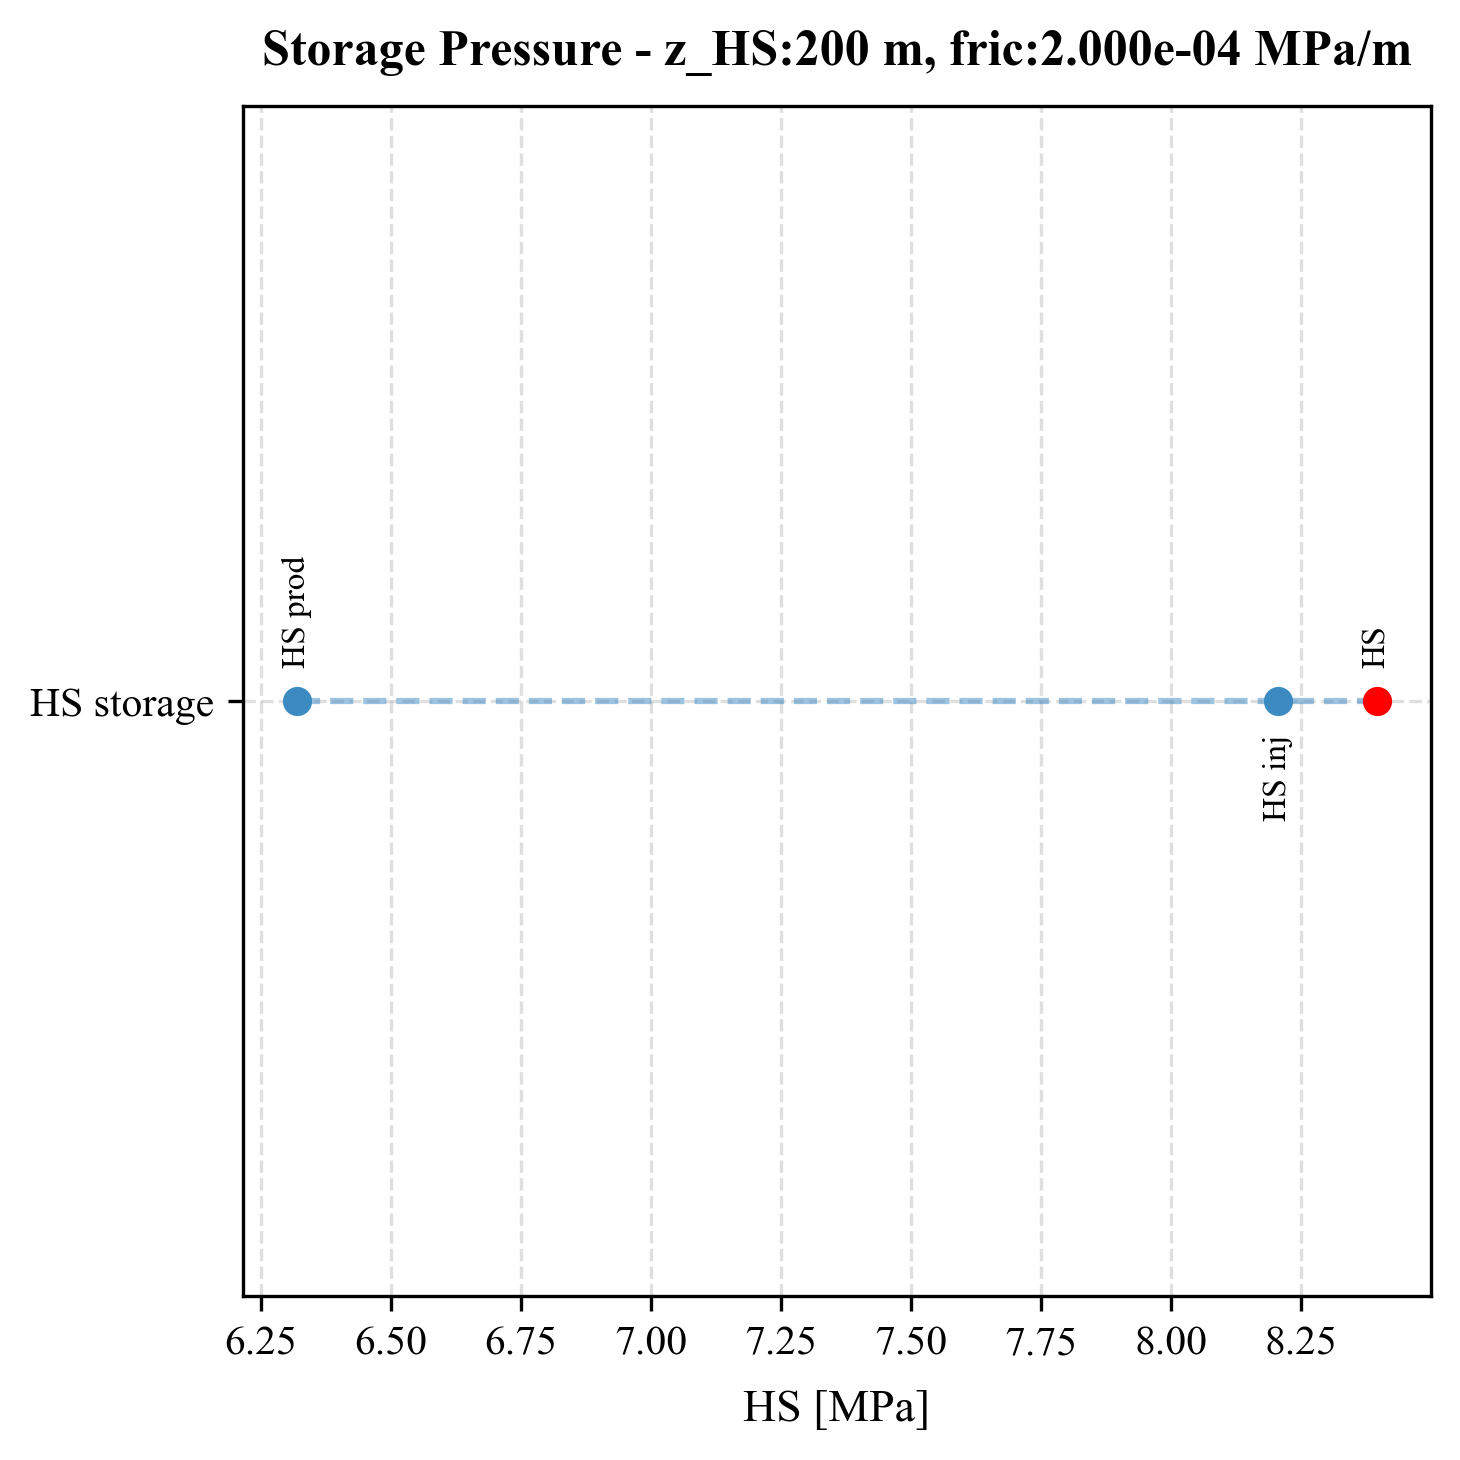

In [113]:
x_var       = 'Pressure'
x_var_sym   = 'P'
x_var_units = 'MPa'
Figure_title = f"Storage {x_var} - z_HS:{z_HS} m, fric:{gradP:.3e} MPa/m"
File_title   = f'Storage_{x_var}s'

hs_inj  = dffull.loc[dffull.To_component == 'HS',   'Stream_#'].iat[0]; hs_prod = dffull.loc[dffull.From_component == 'HS', 'Stream_#'].iat[0]
hs_char = dffull.loc[dffull.Orientation.isna(),      'Stream_#'].sort_values().iat[0]; hs_streams = [hs_inj, hs_char, hs_prod]
dfi = dffull.set_index('Stream_#')
x_hs = dfi.loc[hs_streams, x_var_sym].values
def expand(vals):
    lo, hi = vals.min(), vals.max()
    rng = hi - lo
    return lo - 0.05*rng, hi + 0.05*rng
hs_xlim = expand(x_hs)

fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap = plt.get_cmap('Blues'); hs_base = cmap(0.65); hs_cols = [hs_base, 'red', hs_base]; role = {hs_inj: 'HS inj', hs_char: 'HS', hs_prod: 'HS prod'}; offsets = [8, -8]
ax.hlines(0, x_hs.min(), x_hs.max(), linestyles='--', alpha=0.5, color=hs_base)
for xx, col in zip(x_hs, hs_cols):
    ax.scatter(xx, 0, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_hs, hs_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]
    ax.annotate(role[s], xy=(xx, 0), xytext=(0, dy), textcoords='offset points',
                rotation=90, va='bottom' if dy > 0 else 'top', ha='center', fontsize=8)
ax.set_xlim(*hs_xlim); ax.set_xlabel(f"HS [{x_var_units}]", labelpad=6)
ax.set_yticks([0]); ax.set_yticklabels(['HS storage'])
ax.set_ylim(-0.5, 0.5); ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
ax.grid(True, which='major', linestyle='--', alpha=0.4); ax.set_title(Figure_title, pad=10)

plt.tight_layout(); out_path = fig_dir / f"{File_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

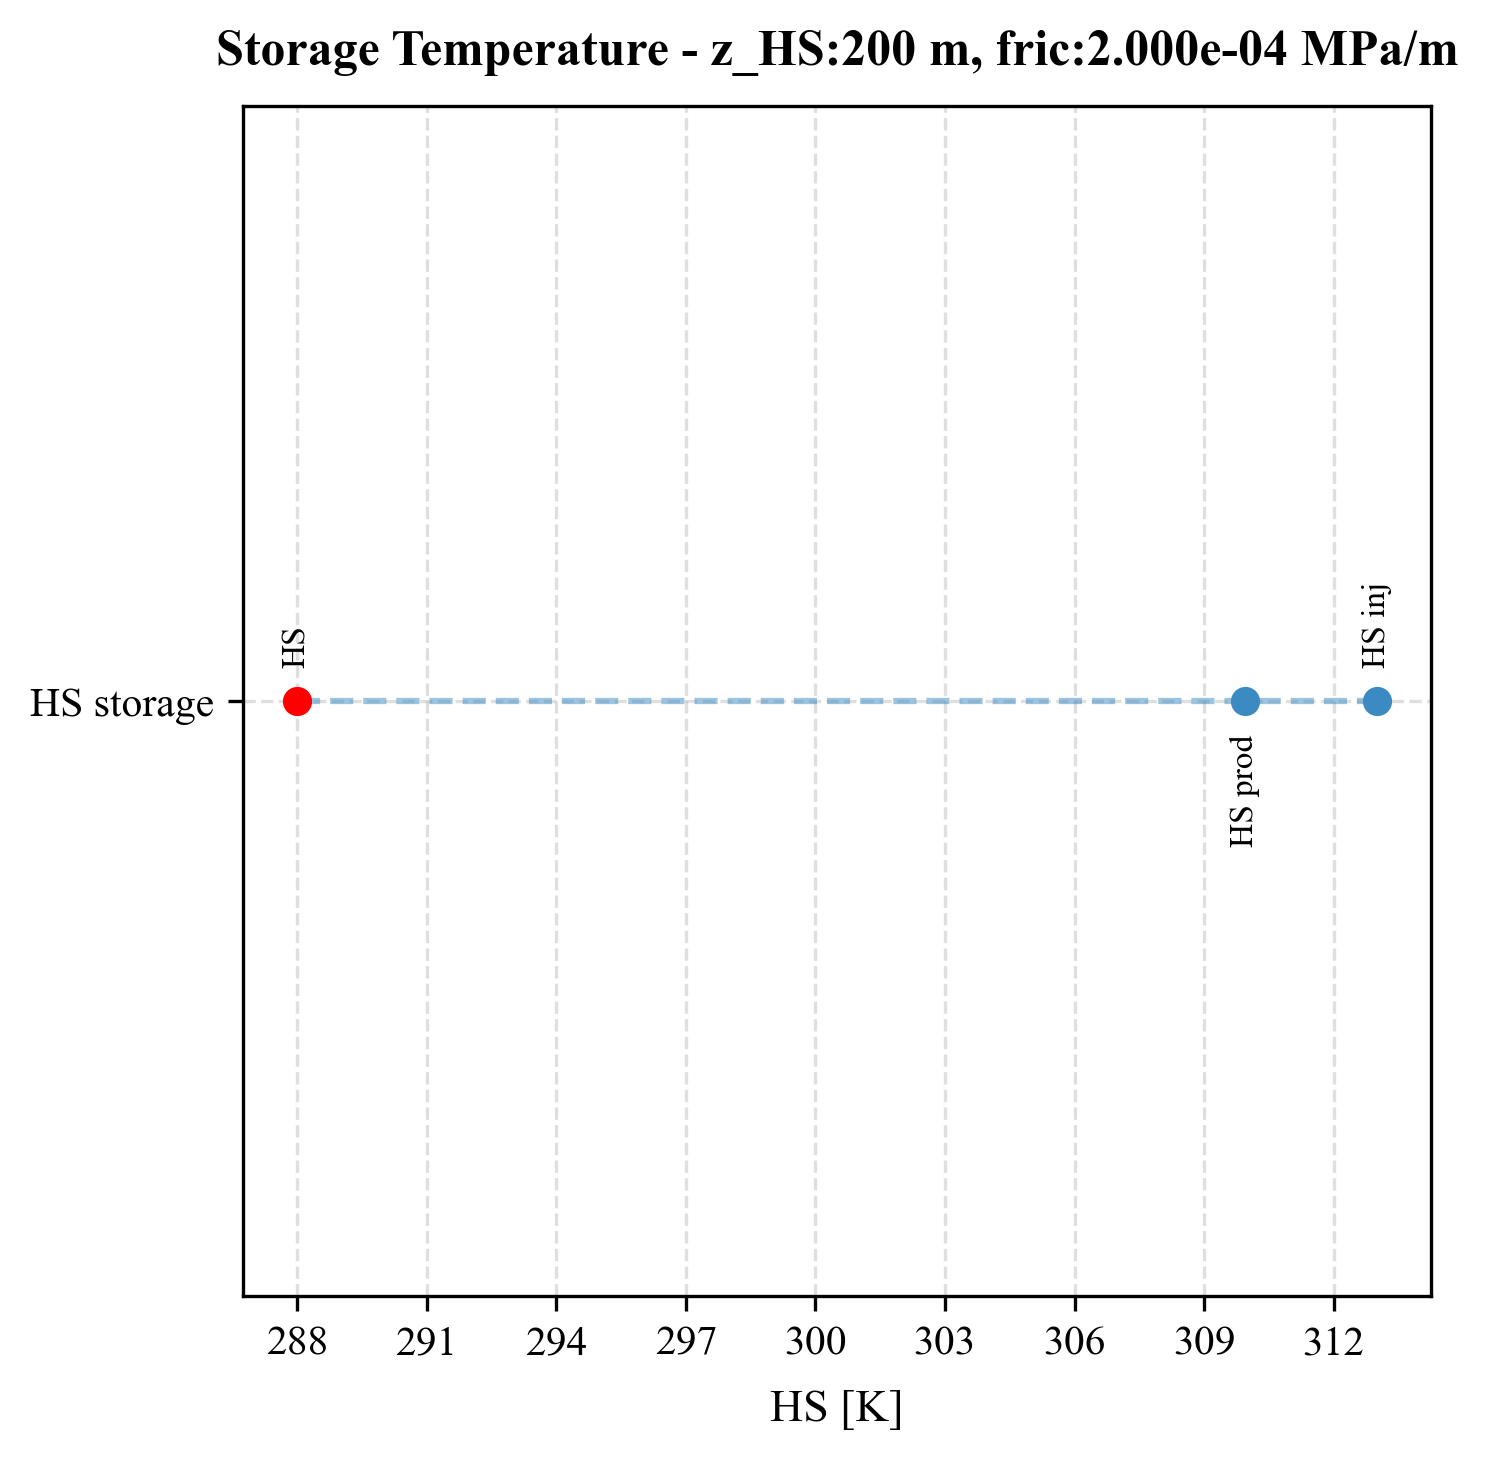

In [114]:
x_var       = 'Temperature'        
x_var_sym   = 'T'               
x_var_units = 'K'            
Figure_title = f"Storage {x_var} - z_HS:{z_HS} m, fric:{gradP:.3e} MPa/m"
File_title = f'Storage_{x_var}s'

hs_inj  = dffull.loc[dffull.To_component == 'HS',   'Stream_#'].iat[0]; hs_prod = dffull.loc[dffull.From_component == 'HS', 'Stream_#'].iat[0]
hs_char = dffull.loc[dffull.Orientation.isna(),      'Stream_#'].sort_values().iat[0]; hs_streams = [hs_inj, hs_char, hs_prod]
dfi = dffull.set_index('Stream_#')
x_hs = dfi.loc[hs_streams, x_var_sym].values
def expand(vals):
    lo, hi = vals.min(), vals.max()
    rng = hi - lo
    return lo - 0.05*rng, hi + 0.05*rng
hs_xlim = expand(x_hs)

fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap = plt.get_cmap('Blues'); hs_base = cmap(0.65); hs_cols = [hs_base, 'red', hs_base]; role = {hs_inj: 'HS inj', hs_char: 'HS', hs_prod: 'HS prod'}; offsets = [8, -8]
ax.hlines(0, x_hs.min(), x_hs.max(), linestyles='--', alpha=0.5, color=hs_base)
for xx, col in zip(x_hs, hs_cols):
    ax.scatter(xx, 0, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_hs, hs_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]
    ax.annotate(role[s], xy=(xx, 0), xytext=(0, dy), textcoords='offset points',
                rotation=90, va='bottom' if dy > 0 else 'top', ha='center', fontsize=8)
ax.set_xlim(*hs_xlim); ax.set_xlabel(f"HS [{x_var_units}]", labelpad=6)
ax.set_yticks([0]); ax.set_yticklabels(['HS storage'])
ax.set_ylim(-0.5, 0.5); ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
ax.grid(True, which='major', linestyle='--', alpha=0.4); ax.set_title(Figure_title, pad=10)

plt.tight_layout(); out_path = fig_dir / f"{File_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

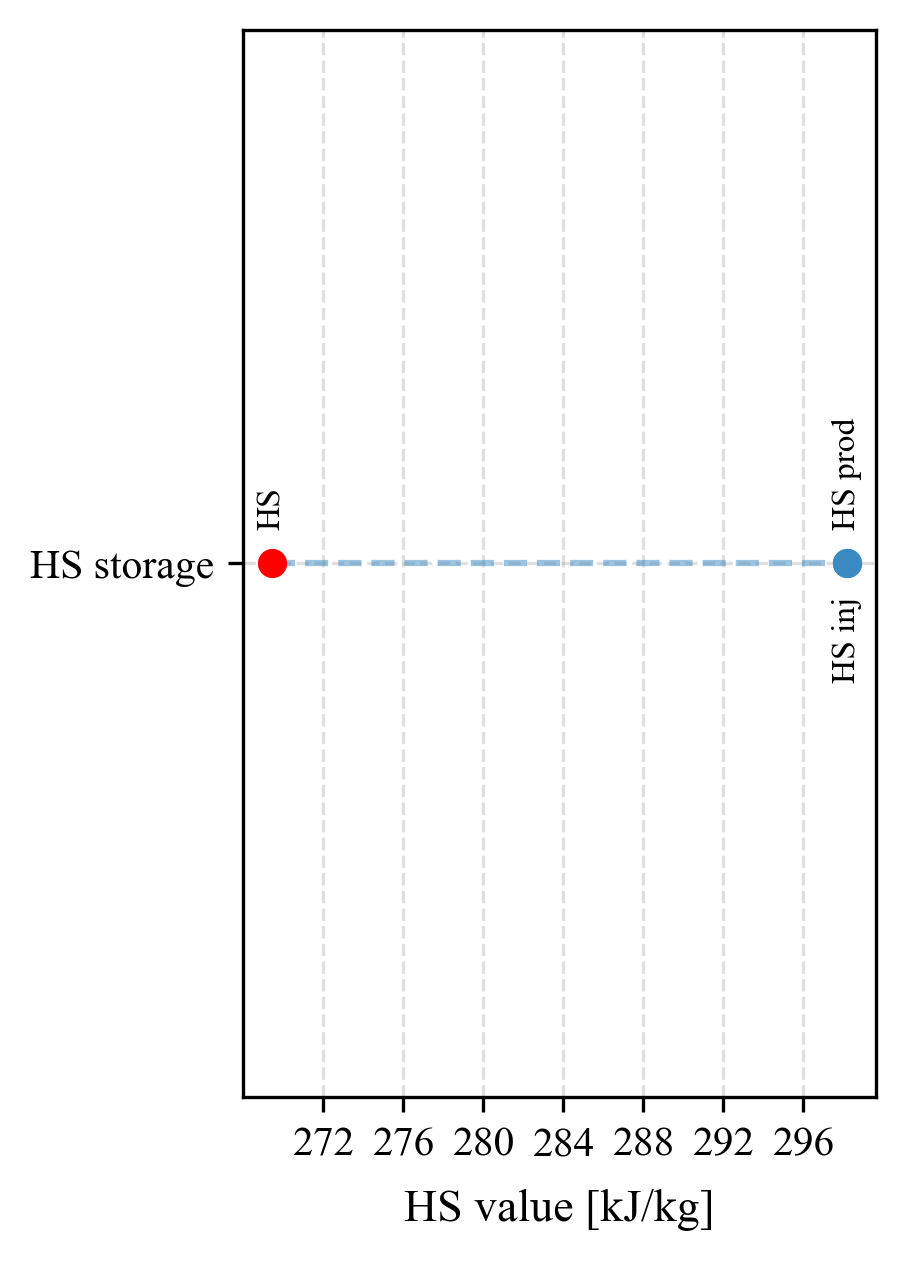

In [115]:
from matplotlib.ticker import MaxNLocator
import numpy as np
import matplotlib.pyplot as plt

x_var       = 'Enthalpy'
x_var_sym   = 'h'
x_var_units = 'kJ/kg'
Figure_title = f"Storage {x_var} - z_HS:{z_HS} m, fric:{gradP:.3e} MPa/m"
File_title   = f"Storage_{x_var}s"


hs_inj  = dffull.loc[dffull.To_component == 'HS',   'Stream_#'].iat[0]
hs_prod = dffull.loc[dffull.From_component == 'HS', 'Stream_#'].iat[0]
hs_char = dffull.loc[dffull.Orientation.isna(),     'Stream_#'].sort_values().iat[0]
hs_streams = [hs_inj, hs_char, hs_prod]

dfi   = dffull.set_index('Stream_#')
x_hs  = dfi.loc[hs_streams, x_var_sym].values

def expand(vals):
    lo, hi = vals.min(), vals.max()
    rng = hi - lo
    return lo - 0.05*rng, hi + 0.05*rng

hs_xlim = expand(x_hs)

fig, ax = plt.subplots(figsize=(3.15, 4.5), dpi=300)

# Fonts: Times New Roman, size 11
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 11
})

cmap     = plt.get_cmap('Blues')
hs_base  = cmap(0.65)
hs_cols  = [hs_base, 'red', hs_base]  # inj, char, prod
role     = {hs_inj: 'HS inj', hs_char: 'HS', hs_prod: 'HS prod'}
offsets  = [8, -8]

ax.hlines(0, x_hs.min(), x_hs.max(), linestyles='--', alpha=0.5, color=hs_base)
for xx, col in zip(x_hs, hs_cols):
    ax.scatter(xx, 0, color=col, zorder=3)

for idx, (xx, s) in enumerate(sorted(zip(x_hs, hs_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]
    ax.annotate(
        role[s], xy=(xx, 0), xytext=(0, dy), textcoords='offset points',
        rotation=90, va='bottom' if dy > 0 else 'top', ha='center', fontsize=8
    )

ax.set_xlim(*hs_xlim)
ax.set_xlabel(f"HS value [{x_var_units}]", labelpad=6)

ax.set_yticks([0])
ax.set_yticklabels(['HS storage'])
ax.set_ylim(-0.5, 0.5)

ax.xaxis.set_major_locator(MaxNLocator(nbins=8))

ax.grid(True, which='major', linestyle='--', alpha=0.4)
ax.set_title("")       # no figure title on plot
fig.suptitle("")       # no suptitle
ax.legend([], [], frameon=False)

plt.tight_layout()

out_path = fig_dir / f"{File_title}.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight')

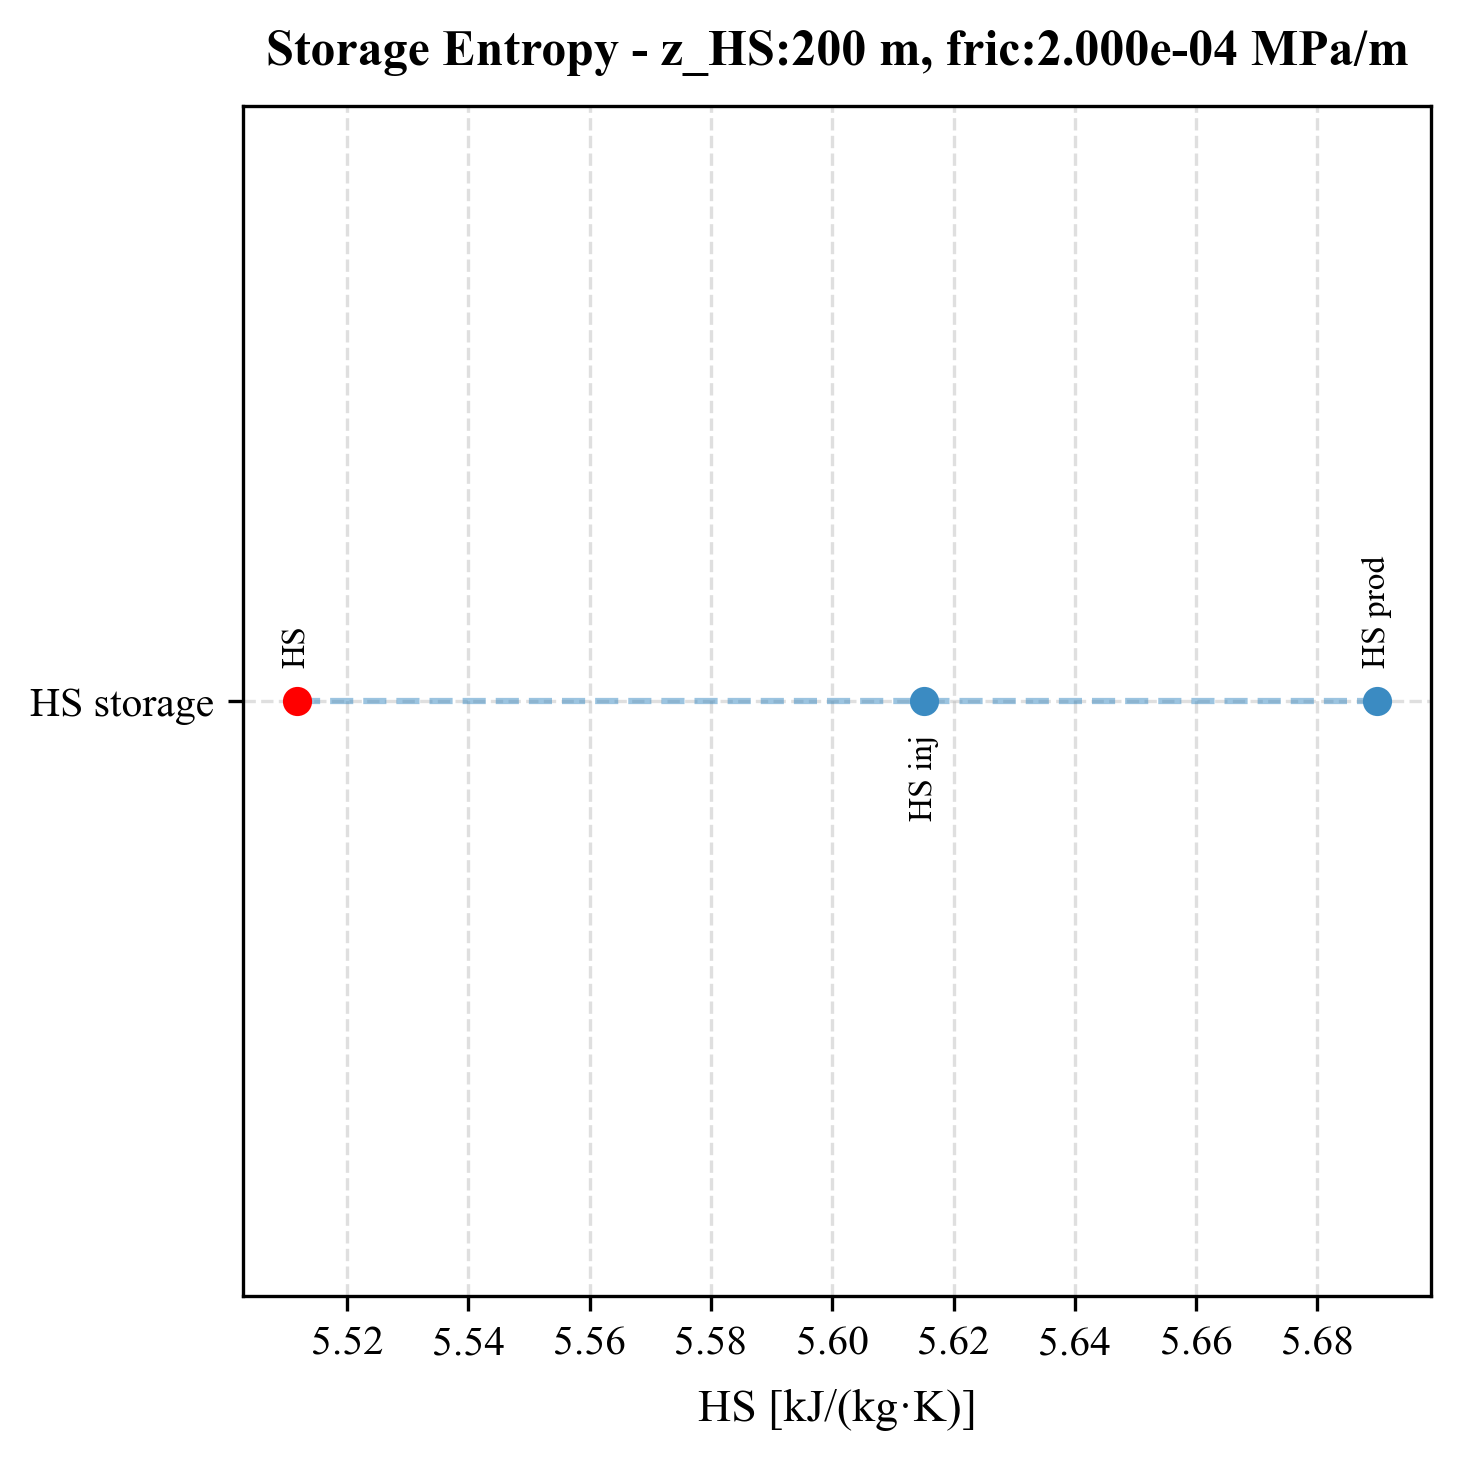

In [116]:
x_var       = 'Entropy'        
x_var_sym   = 's'               
x_var_units = 'kJ/(kg·K)'            
Figure_title = f"Storage {x_var} - z_HS:{z_HS} m, fric:{gradP:.3e} MPa/m"
File_title = f'Storage_{x_var}s'

hs_inj  = dffull.loc[dffull.To_component == 'HS',   'Stream_#'].iat[0]; hs_prod = dffull.loc[dffull.From_component == 'HS', 'Stream_#'].iat[0]
hs_char = dffull.loc[dffull.Orientation.isna(),      'Stream_#'].sort_values().iat[0]; hs_streams = [hs_inj, hs_char, hs_prod]
dfi = dffull.set_index('Stream_#')
x_hs = dfi.loc[hs_streams, x_var_sym].values
def expand(vals):
    lo, hi = vals.min(), vals.max()
    rng = hi - lo
    return lo - 0.05*rng, hi + 0.05*rng
hs_xlim = expand(x_hs)

fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap = plt.get_cmap('Blues'); hs_base = cmap(0.65); hs_cols = [hs_base, 'red', hs_base]; role = {hs_inj: 'HS inj', hs_char: 'HS', hs_prod: 'HS prod'}; offsets = [8, -8]
ax.hlines(0, x_hs.min(), x_hs.max(), linestyles='--', alpha=0.5, color=hs_base)
for xx, col in zip(x_hs, hs_cols):
    ax.scatter(xx, 0, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_hs, hs_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]
    ax.annotate(role[s], xy=(xx, 0), xytext=(0, dy), textcoords='offset points',
                rotation=90, va='bottom' if dy > 0 else 'top', ha='center', fontsize=8)
ax.set_xlim(*hs_xlim); ax.set_xlabel(f"HS [{x_var_units}]", labelpad=6)
ax.set_yticks([0]); ax.set_yticklabels(['HS storage'])
ax.set_ylim(-0.5, 0.5); ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
ax.grid(True, which='major', linestyle='--', alpha=0.4); ax.set_title(Figure_title, pad=10)

plt.tight_layout(); out_path = fig_dir / f"{File_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

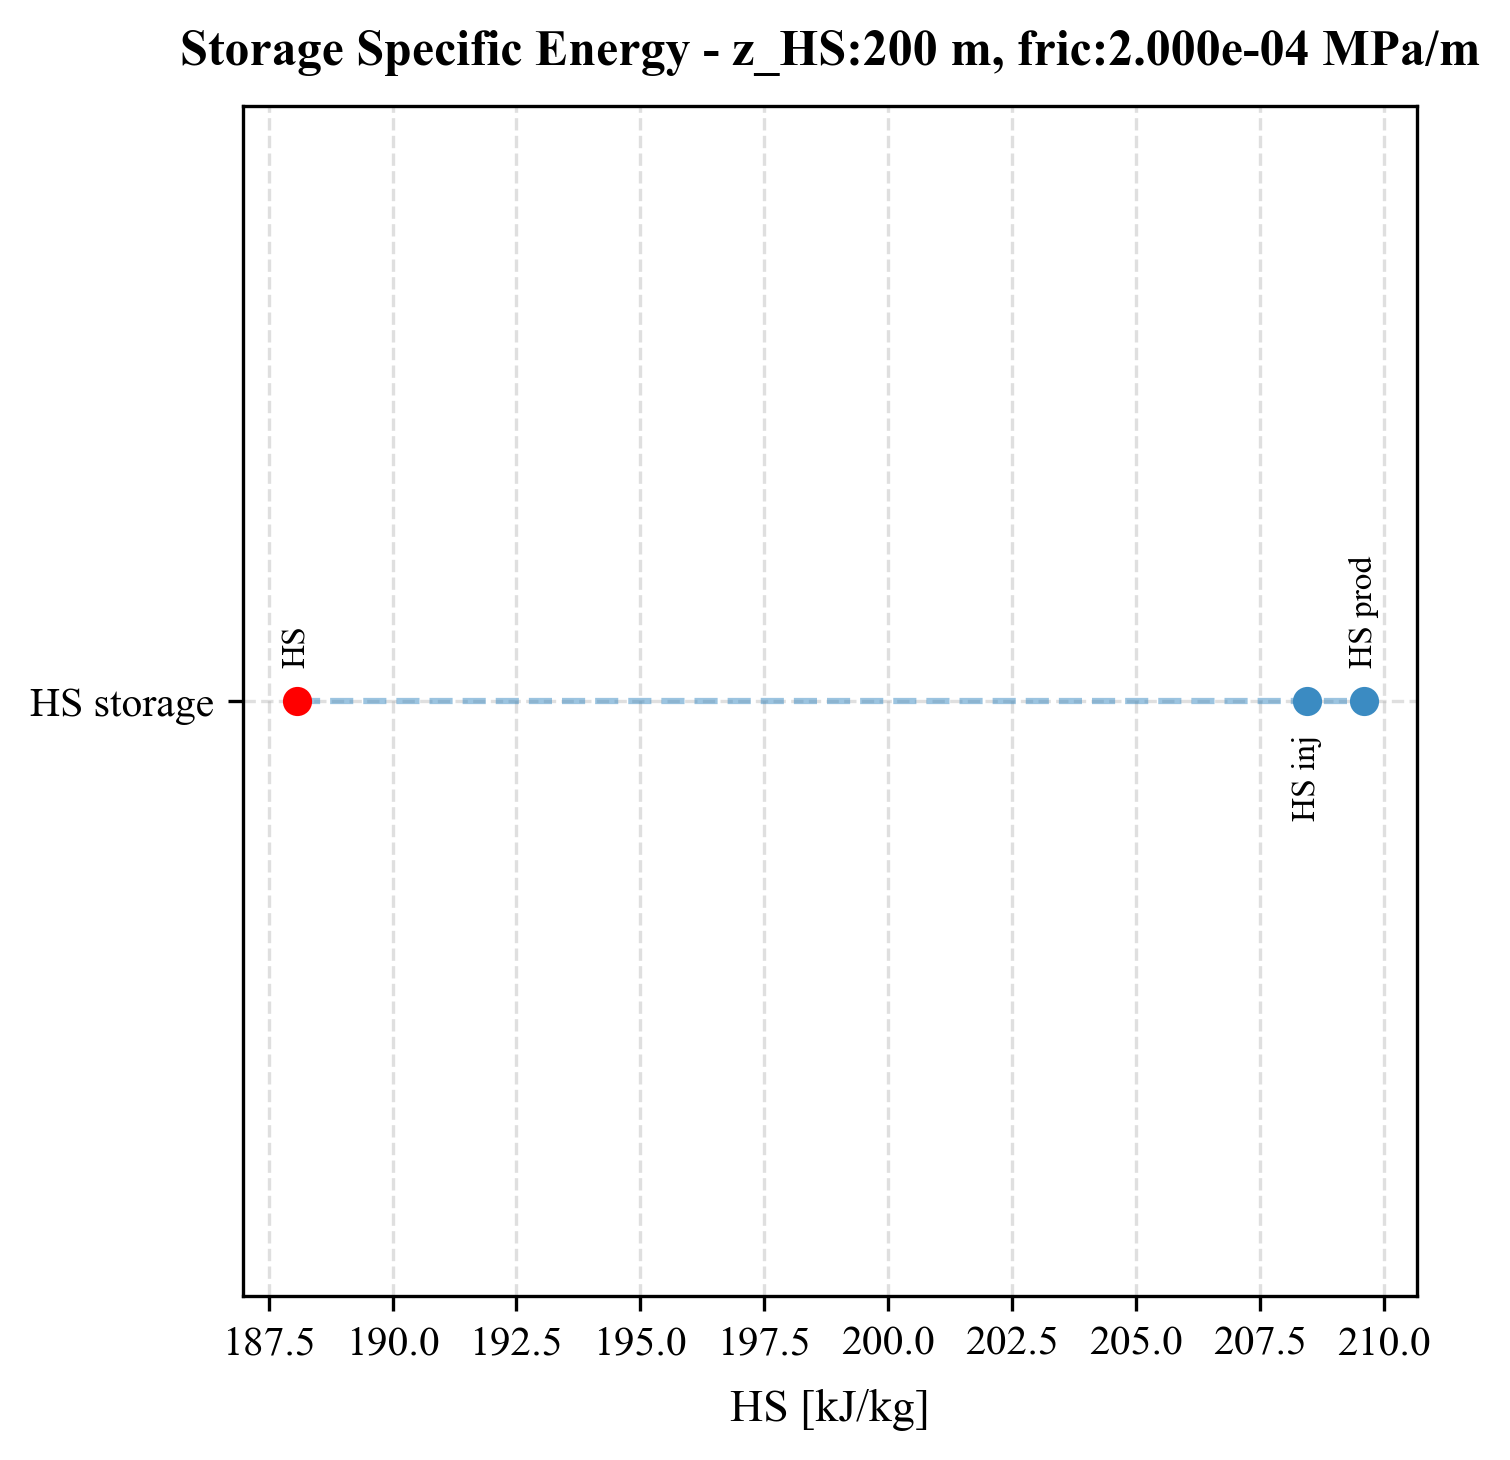

In [117]:
x_var       = 'Specific Energy'        
x_var_sym   = 'e'               
x_var_units = 'kJ/kg'            
Figure_title = f"Storage {x_var} - z_HS:{z_HS} m, fric:{gradP:.3e} MPa/m"
File_title = f'Storage_{x_var}s'

hs_inj  = dffull.loc[dffull.To_component == 'HS',   'Stream_#'].iat[0]; hs_prod = dffull.loc[dffull.From_component == 'HS', 'Stream_#'].iat[0]
hs_char = dffull.loc[dffull.Orientation.isna(),      'Stream_#'].sort_values().iat[0]; hs_streams = [hs_inj, hs_char, hs_prod]
dfi = dffull.set_index('Stream_#')
x_hs = dfi.loc[hs_streams, x_var_sym].values
def expand(vals):
    lo, hi = vals.min(), vals.max()
    rng = hi - lo
    return lo - 0.05*rng, hi + 0.05*rng
hs_xlim = expand(x_hs)

fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap = plt.get_cmap('Blues'); hs_base = cmap(0.65); hs_cols = [hs_base, 'red', hs_base]; role = {hs_inj: 'HS inj', hs_char: 'HS', hs_prod: 'HS prod'}; offsets = [8, -8]
ax.hlines(0, x_hs.min(), x_hs.max(), linestyles='--', alpha=0.5, color=hs_base)
for xx, col in zip(x_hs, hs_cols):
    ax.scatter(xx, 0, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_hs, hs_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]
    ax.annotate(role[s], xy=(xx, 0), xytext=(0, dy), textcoords='offset points',
                rotation=90, va='bottom' if dy > 0 else 'top', ha='center', fontsize=8)
ax.set_xlim(*hs_xlim); ax.set_xlabel(f"HS [{x_var_units}]", labelpad=6)
ax.set_yticks([0]); ax.set_yticklabels(['HS storage'])
ax.set_ylim(-0.5, 0.5); ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
ax.grid(True, which='major', linestyle='--', alpha=0.4); ax.set_title(Figure_title, pad=10)

plt.tight_layout(); out_path = fig_dir / f"{File_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

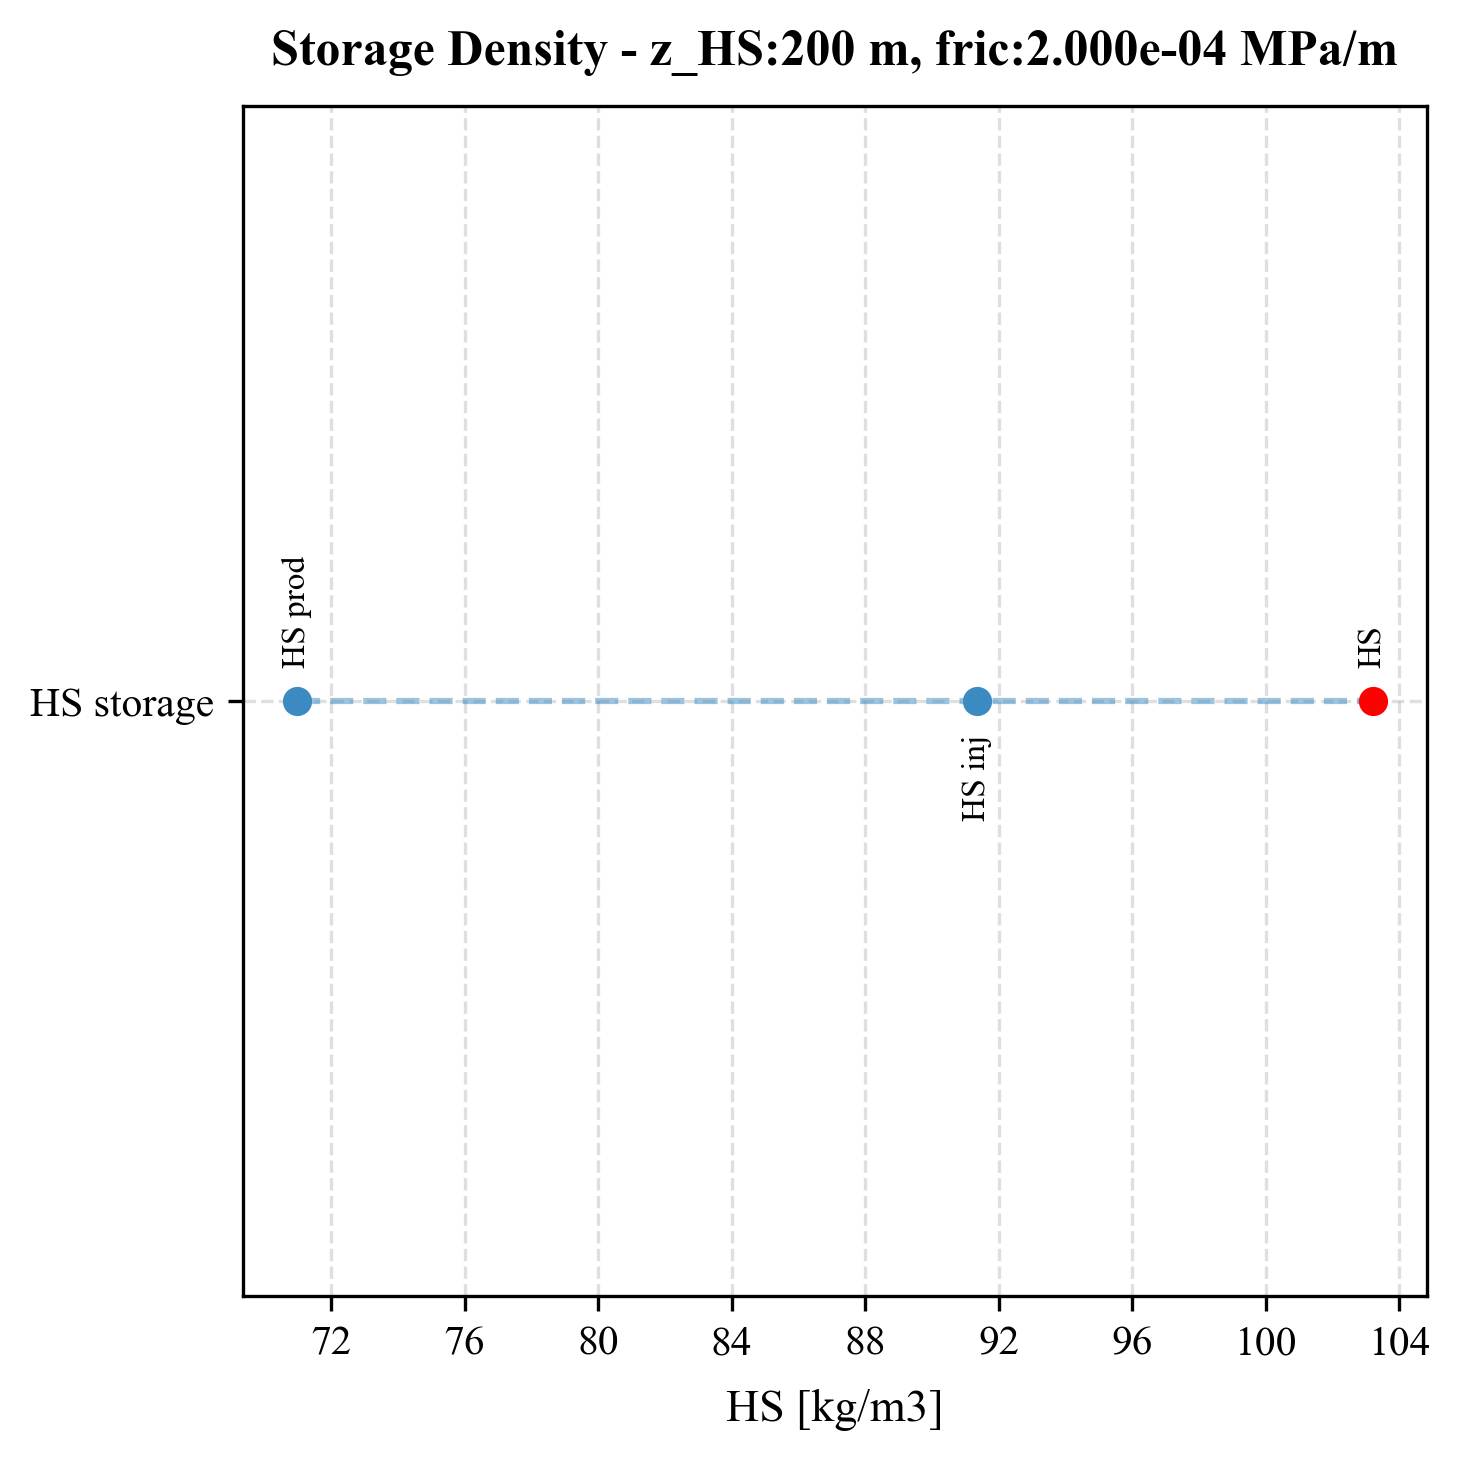

In [118]:
x_var       = 'Density'        
x_var_sym   = 'p'               
x_var_units = 'kg/m3'            
Figure_title = f"Storage {x_var} - z_HS:{z_HS} m, fric:{gradP:.3e} MPa/m"
File_title = f'Storage_{x_var}s'

hs_inj  = dffull.loc[dffull.To_component == 'HS',   'Stream_#'].iat[0]; hs_prod = dffull.loc[dffull.From_component == 'HS', 'Stream_#'].iat[0]
hs_char = dffull.loc[dffull.Orientation.isna(),      'Stream_#'].sort_values().iat[0]; hs_streams = [hs_inj, hs_char, hs_prod]
dfi = dffull.set_index('Stream_#')
x_hs = dfi.loc[hs_streams, x_var_sym].values
def expand(vals):
    lo, hi = vals.min(), vals.max()
    rng = hi - lo
    return lo - 0.05*rng, hi + 0.05*rng
hs_xlim = expand(x_hs)

fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap = plt.get_cmap('Blues'); hs_base = cmap(0.65); hs_cols = [hs_base, 'red', hs_base]; role = {hs_inj: 'HS inj', hs_char: 'HS', hs_prod: 'HS prod'}; offsets = [8, -8]
ax.hlines(0, x_hs.min(), x_hs.max(), linestyles='--', alpha=0.5, color=hs_base)
for xx, col in zip(x_hs, hs_cols):
    ax.scatter(xx, 0, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_hs, hs_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]
    ax.annotate(role[s], xy=(xx, 0), xytext=(0, dy), textcoords='offset points',
                rotation=90, va='bottom' if dy > 0 else 'top', ha='center', fontsize=8)
ax.set_xlim(*hs_xlim); ax.set_xlabel(f"HS [{x_var_units}]", labelpad=6)
ax.set_yticks([0]); ax.set_yticklabels(['HS storage'])
ax.set_ylim(-0.5, 0.5); ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
ax.grid(True, which='major', linestyle='--', alpha=0.4); ax.set_title(Figure_title, pad=10)

plt.tight_layout(); out_path = fig_dir / f"{File_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

In [119]:
from matplotlib.ticker import FuncFormatter, MultipleLocator, LinearLocator
import math

def visualize_QSS(df, series_left, left_label, left_units,
                  series_right=None, right_label=None, right_units=None,
                  separate_axes=True, title="QSS Time Series",
                  figsize=(3.15, 5.8), dpi=300, cmap_name="Blues"):
    import numpy as np
    import matplotlib.pyplot as plt

    # Settlement periods (48 half-hours)
    sp = np.arange(1, 49)
    
    left_colors = plt.get_cmap(cmap_name)(np.linspace(0.60, 0.90, len(series_left)))
    right_colors = (plt.get_cmap('Greens')(
        np.linspace(0.45, 0.85, len(series_right))) if series_right else [])

    axis_left_color  = 'navy'
    axis_right_color = 'darkgreen'

    fig, ax1 = plt.subplots(figsize=figsize, dpi=dpi)
    handles, labels = [], []


    for i, col in enumerate(series_left):
        h, = ax1.plot(sp, df[col], 'o-', color=left_colors[i], markersize=3, linewidth=1)
        handles.append(h); labels.append(col)
    ax1.set_ylabel(f"{left_label} {left_units}")

    def sci3_all(x, pos):
        if x == 0:
            return "0.00 e00"
        m, e = f"{x:.3e}".split('e')  
        e = int(e)
        return f"{float(m):.2f} e{'-' if e < 0 else ''}{abs(e):02d}"

    ax1.yaxis.set_major_formatter(FuncFormatter(sci3_all))
    ax1.yaxis.set_major_locator(LinearLocator(10))  # exactly 10 labels

    ax1.spines['left'].set_color(axis_left_color)
    ax1.yaxis.label.set_color(axis_left_color)
    ax1.tick_params(axis='y', colors=axis_left_color)

    ax2 = ax1
    if separate_axes and series_right:
        ax2 = ax1.twinx()
        for j, col in enumerate(series_right, start=len(series_left)):
            idx = j - len(series_left)
            h, = ax2.plot(sp, df[col], 'o-', color=right_colors[idx], markersize=3, linewidth=1)
            handles.append(h); labels.append(col)
        ax2.set_ylabel(f"{right_label} {right_units}")
        ax2.yaxis.set_major_formatter(FuncFormatter(sci3_all))
        ax2.yaxis.set_major_locator(LinearLocator(10))  # exactly 10 labels

        ax2.spines['right'].set_color(axis_right_color)
        ax2.yaxis.label.set_color(axis_right_color)
        ax2.tick_params(axis='y', colors=axis_right_color)

    ax1.grid(True, which='both', linestyle='--', alpha=0.3)


    ax1.set_xlim(1, 48)
    ax1.set_xlabel('Time [hour]')
    ax1.set_xticks(np.arange(1, 49, 2))                   
    ax1.set_xticklabels([str(h) for h in range(1, 25)])   
    ax1.xaxis.set_major_locator(MultipleLocator(2))

    legend = ax1.legend(
        handles, labels,
        ncol=2, fontsize=11, title_fontsize=11,
        frameon=False, loc='upper center',
        bbox_to_anchor=(0.5, -0.06)
    )
    for idx, text in enumerate(legend.get_texts()):
        text.set_color(handles[idx].get_color())

    plt.rcParams.update({'font.family': 'Times New Roman', 'font.size': 11})

    fig.suptitle("")
    plt.tight_layout(rect=[0, 0.03, 1, 1])
    return fig, ax1

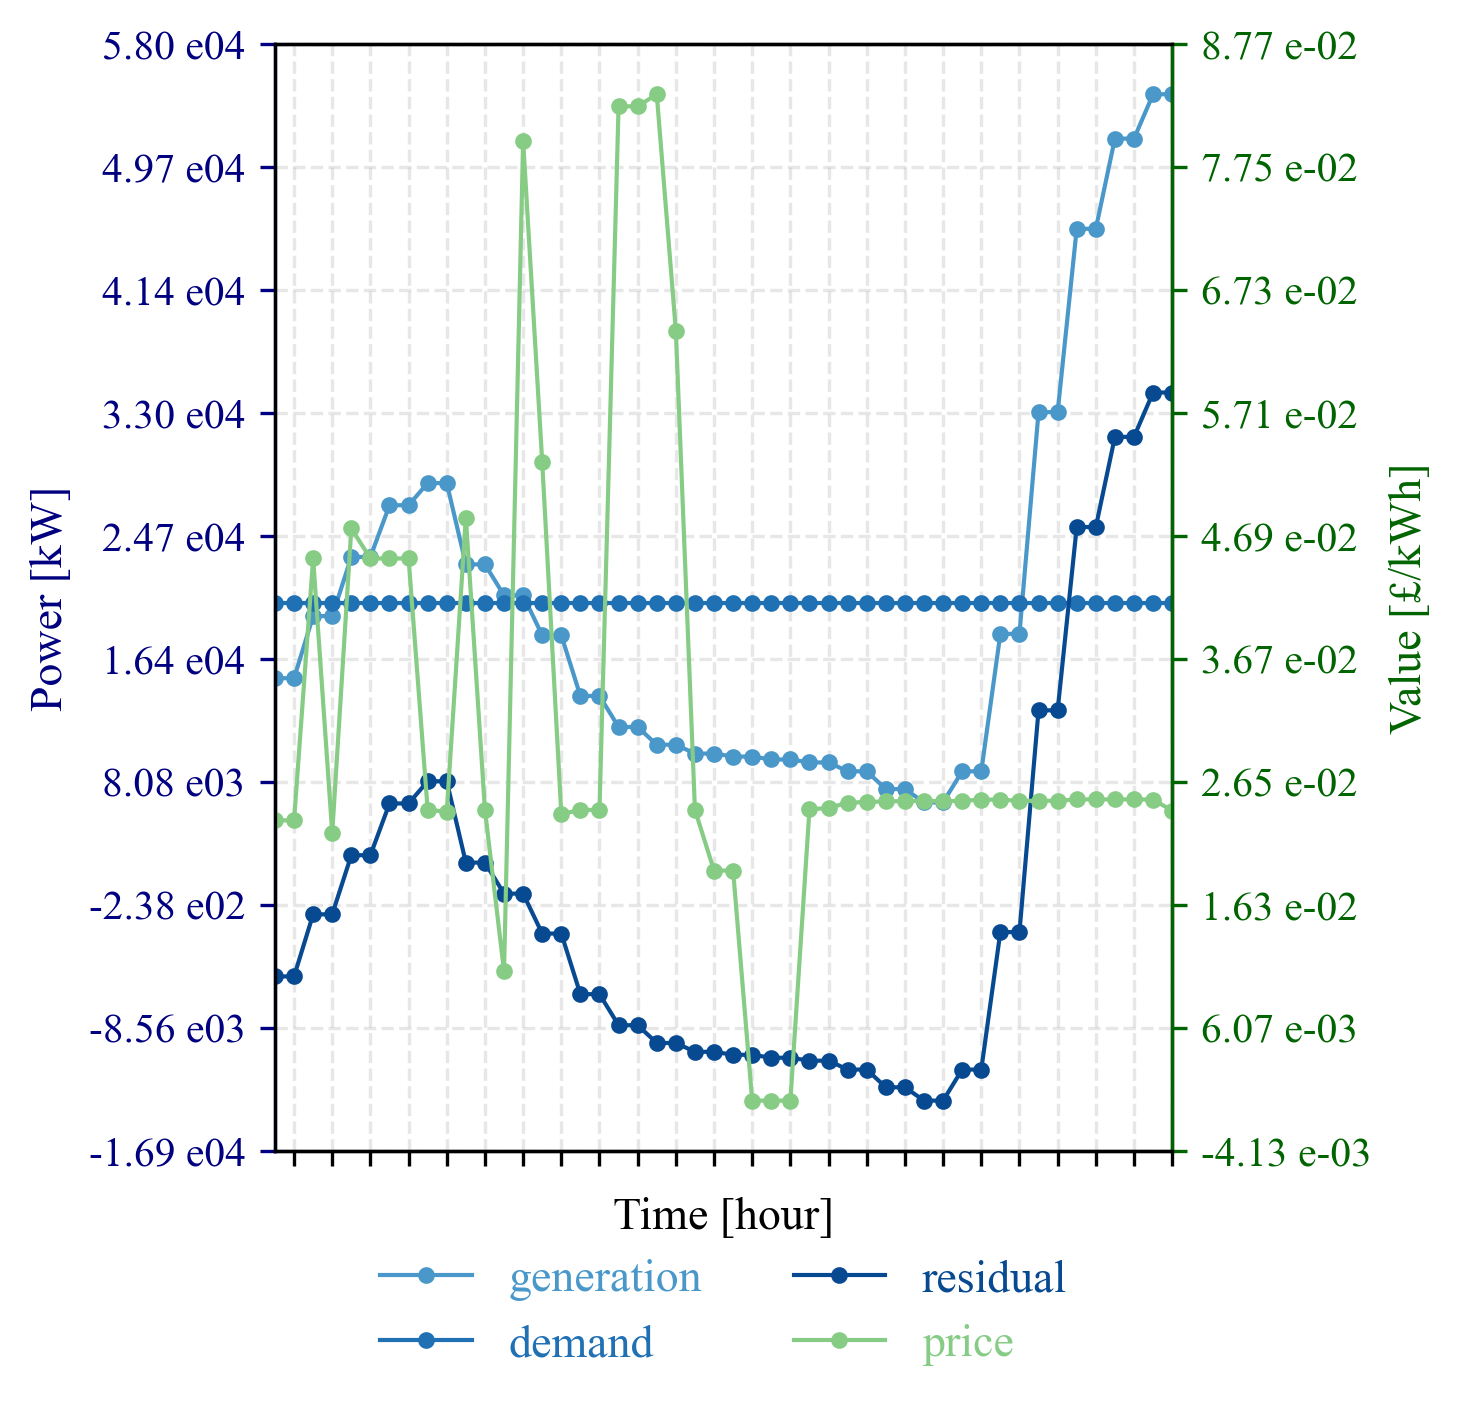

In [120]:
Figure_title = 'Residual Generation'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['generation', 'demand', 'residual'],
    left_label='Power',
    left_units='[kW]',
    series_right = ['price'],
    right_label = 'Value',
    right_units = '[£/kWh]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

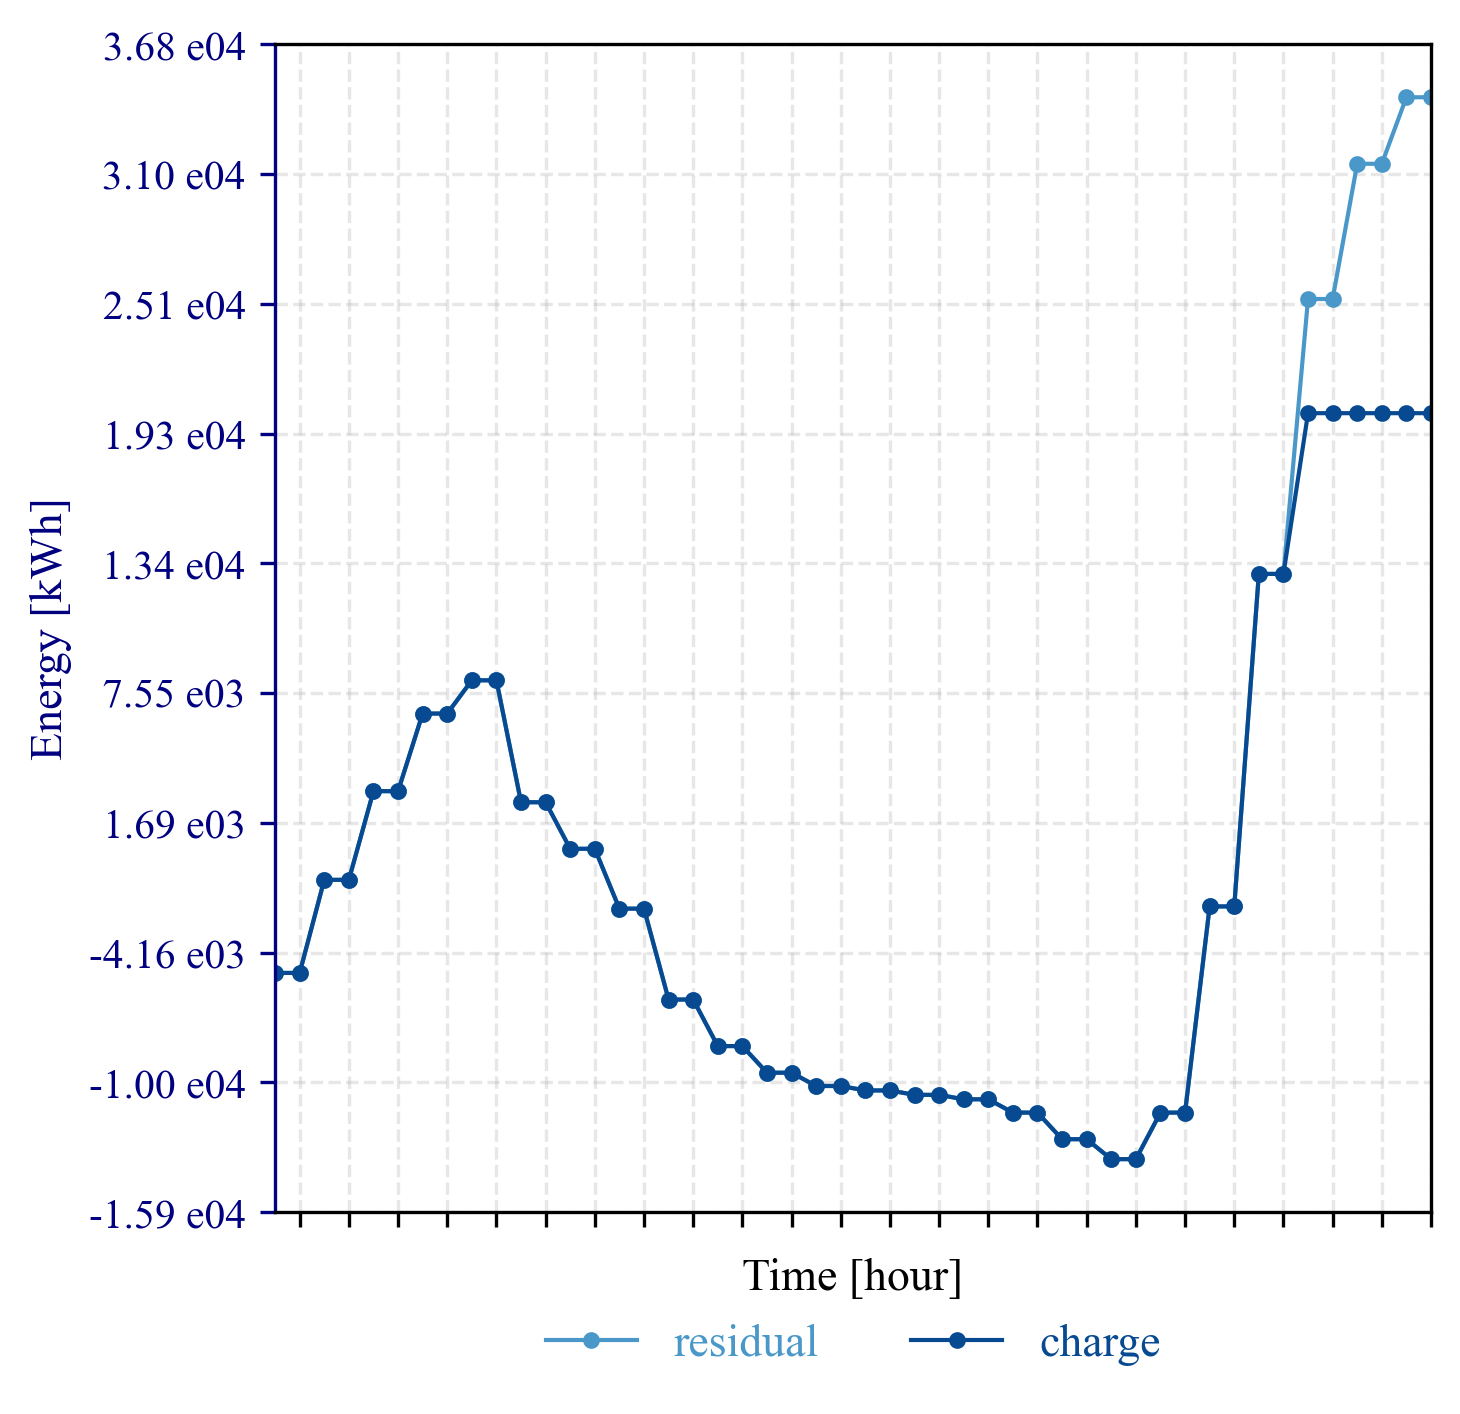

In [121]:
Figure_title = 'Operational Restriction of QSS Approximation - Energy Flow'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['residual', 'charge'],
    left_label='Energy',
    left_units='[kWh]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

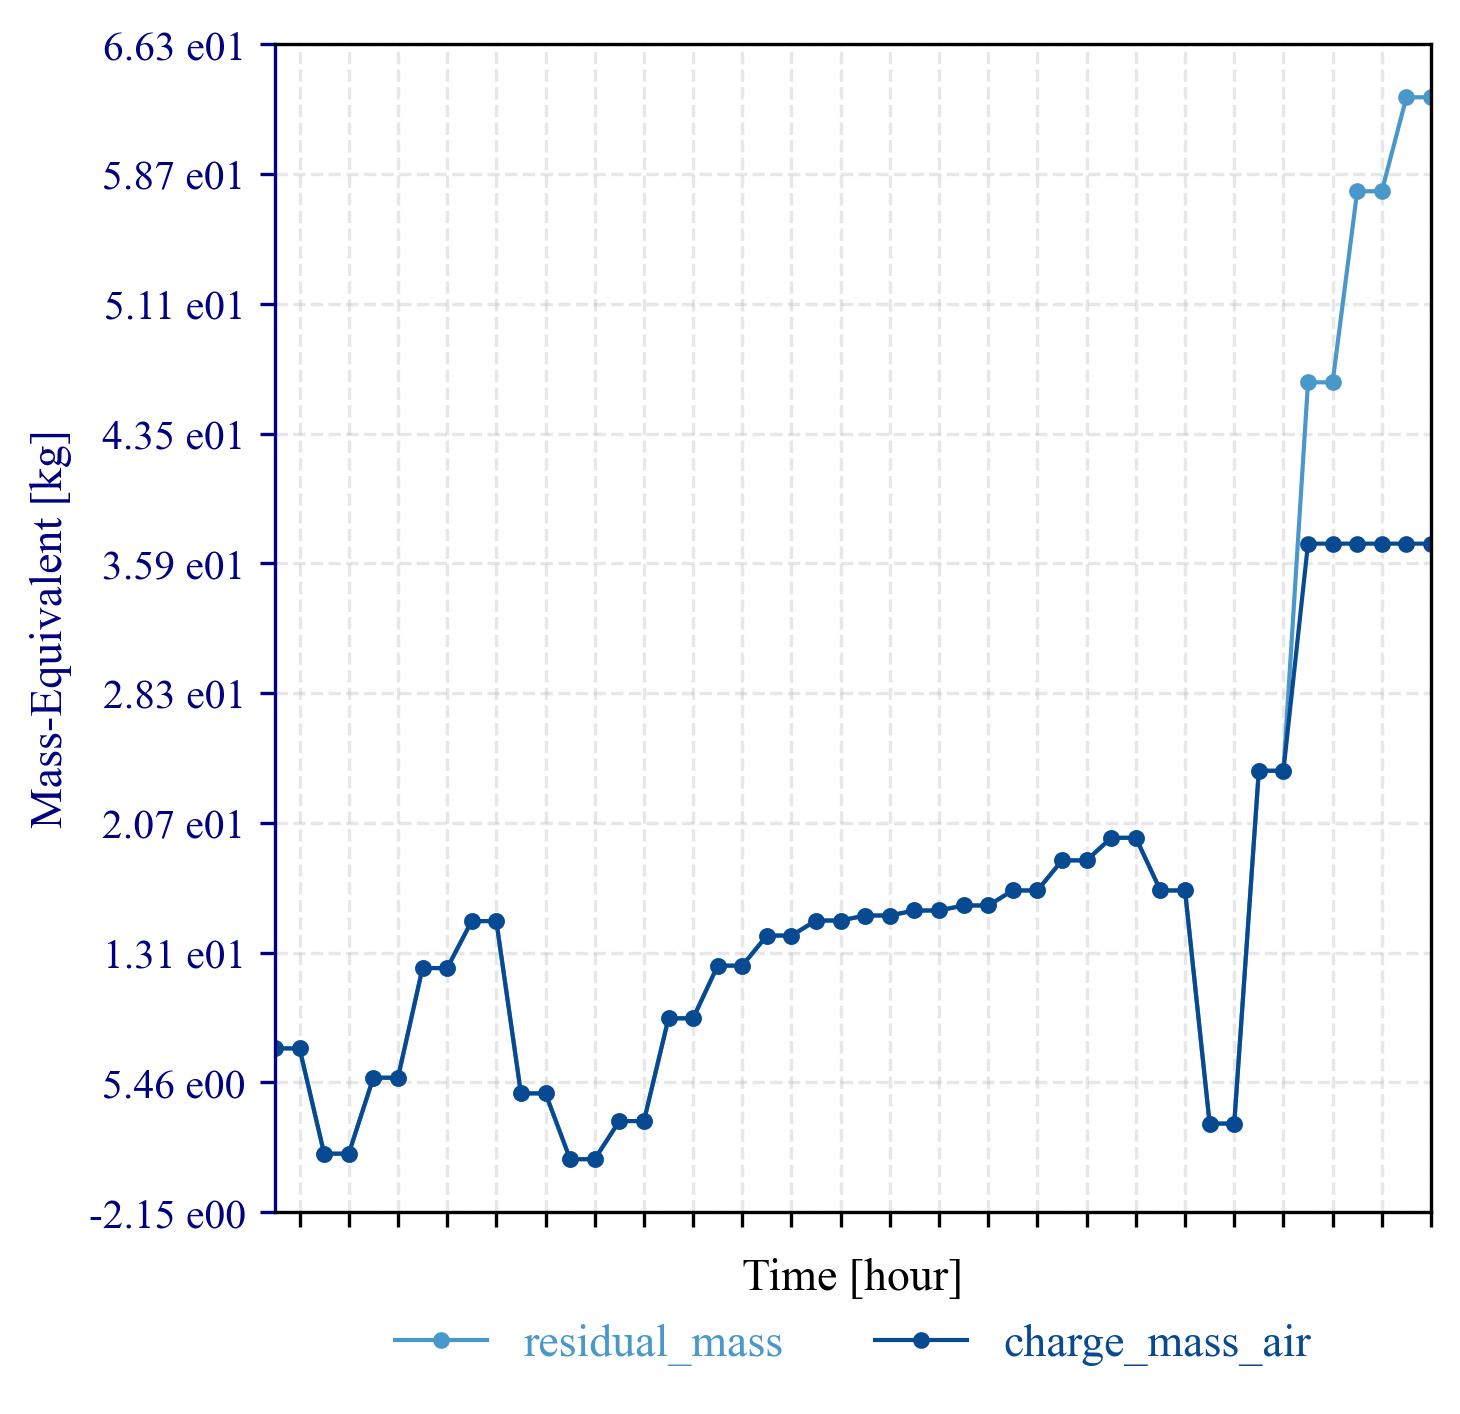

In [122]:
Figure_title = 'Operational Restriction of QSS Approximation - Material Flow'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['residual_mass','charge_mass_air'],
    left_label='Mass-Equivalent',
    left_units='[kg]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

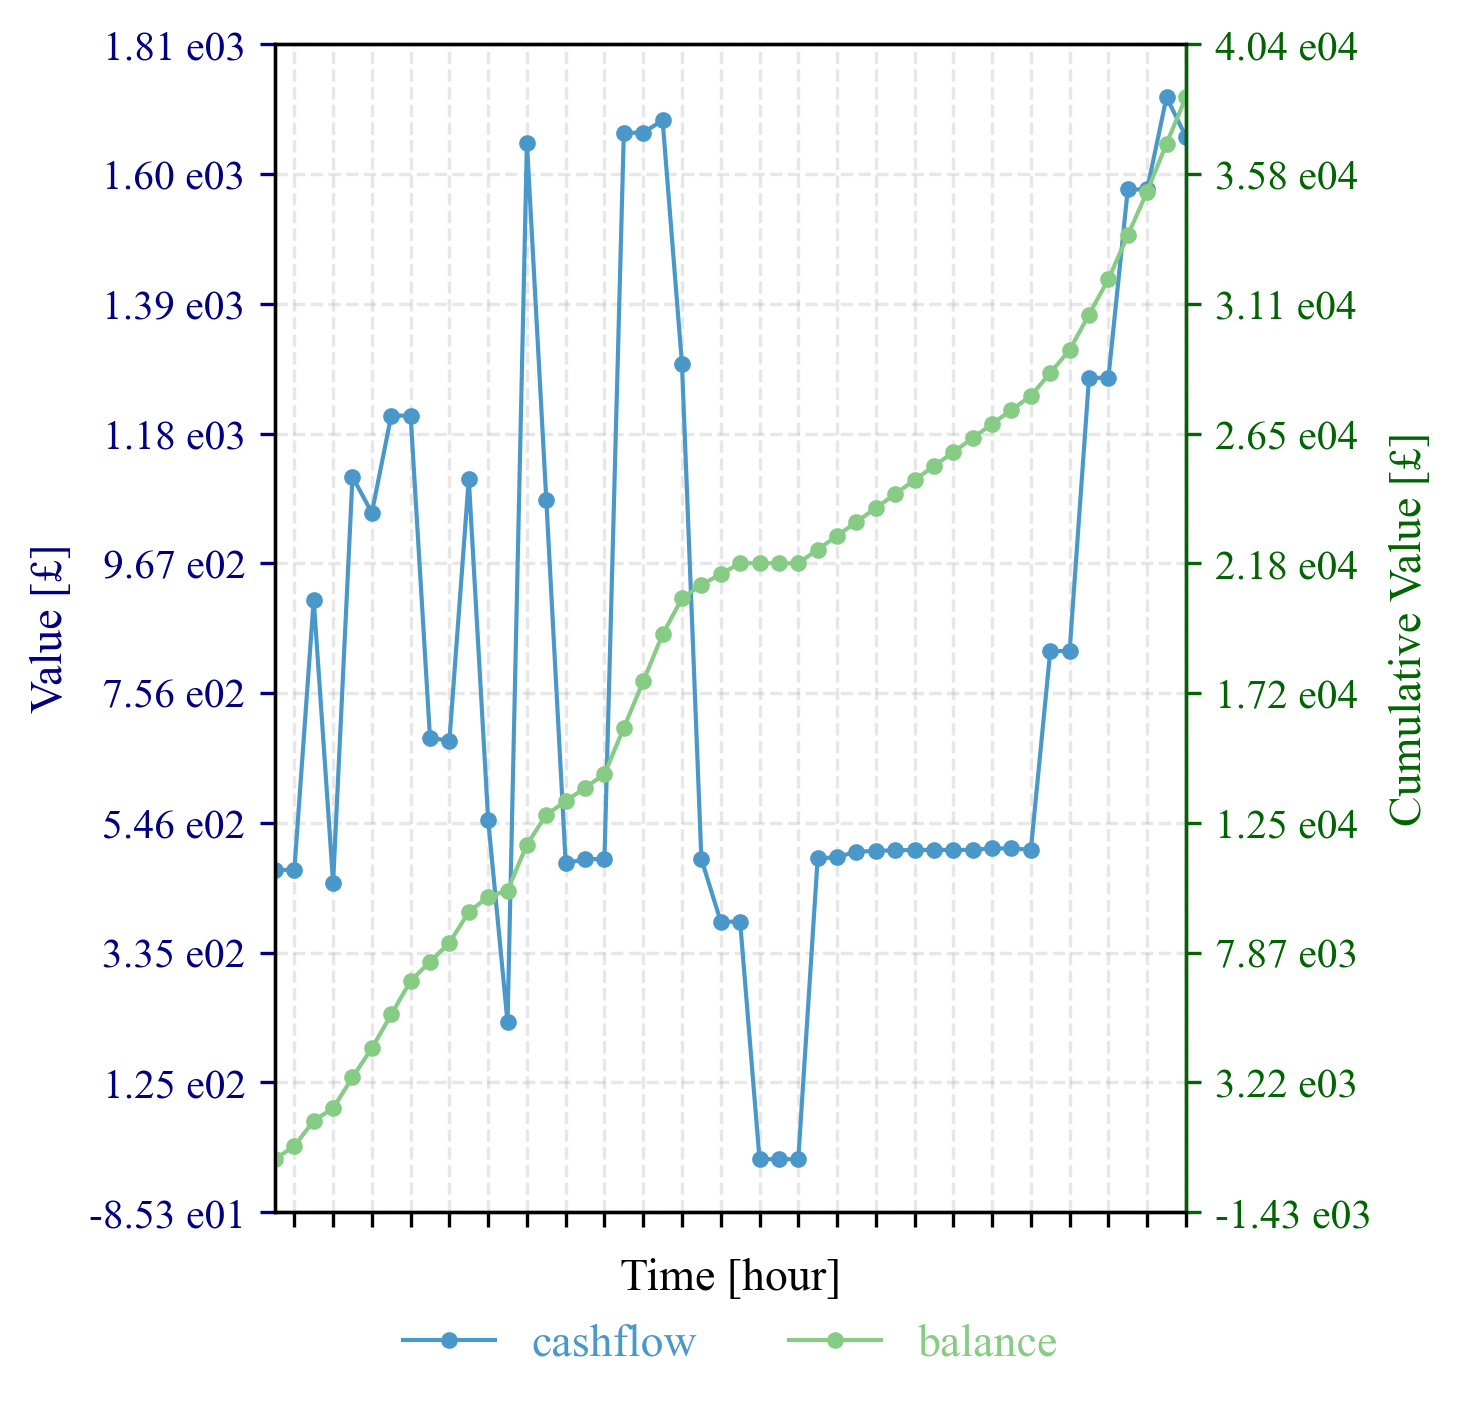

In [123]:
Figure_title = f'{Cycle} Balance Sheet'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['cashflow'],
    left_label='Value',
    left_units='[£]',
    series_right = ['balance'],
    right_label = 'Cumulative Value',
    right_units = '[£]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

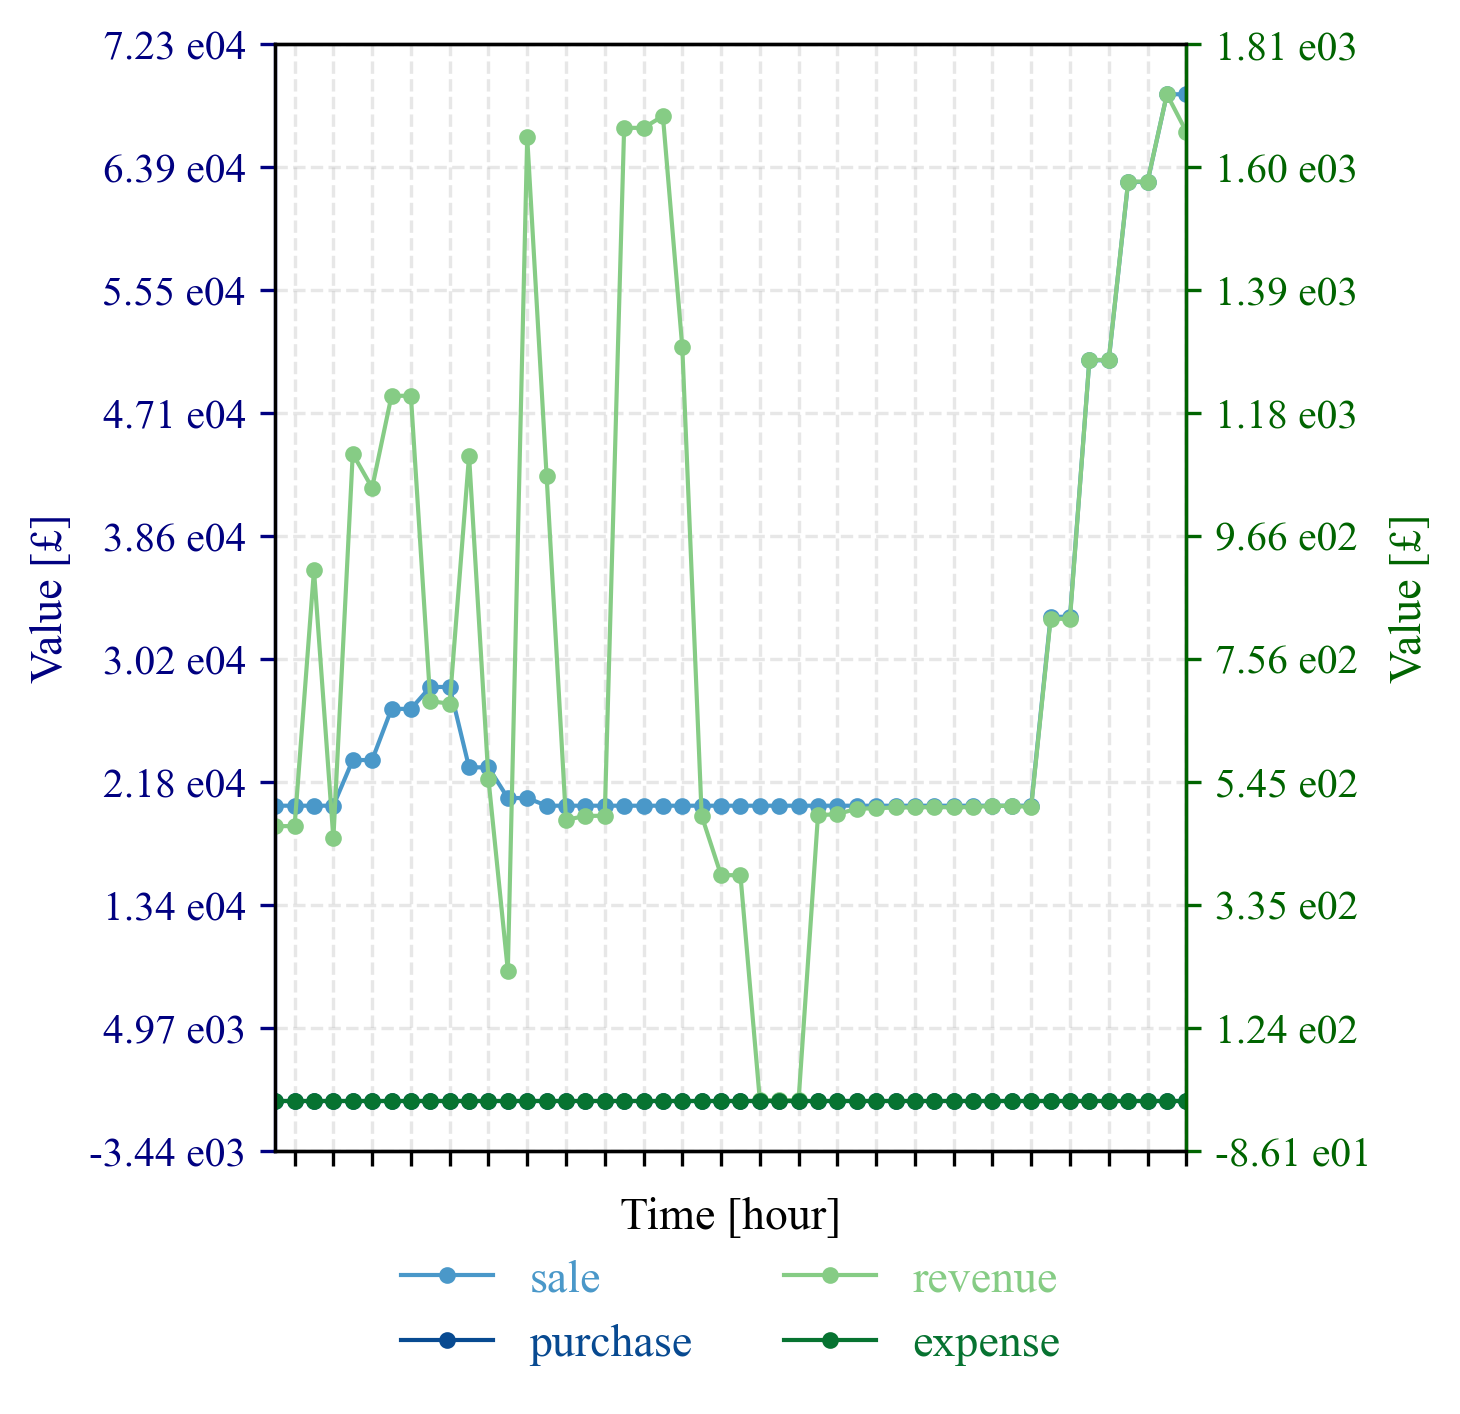

In [124]:
Figure_title = f'{Cycle} Power Trade'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['sale','purchase'],
    left_label='Value',
    left_units='[£]',
    series_right = ['revenue','expense'],
    right_label = 'Value',
    right_units = '[£]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

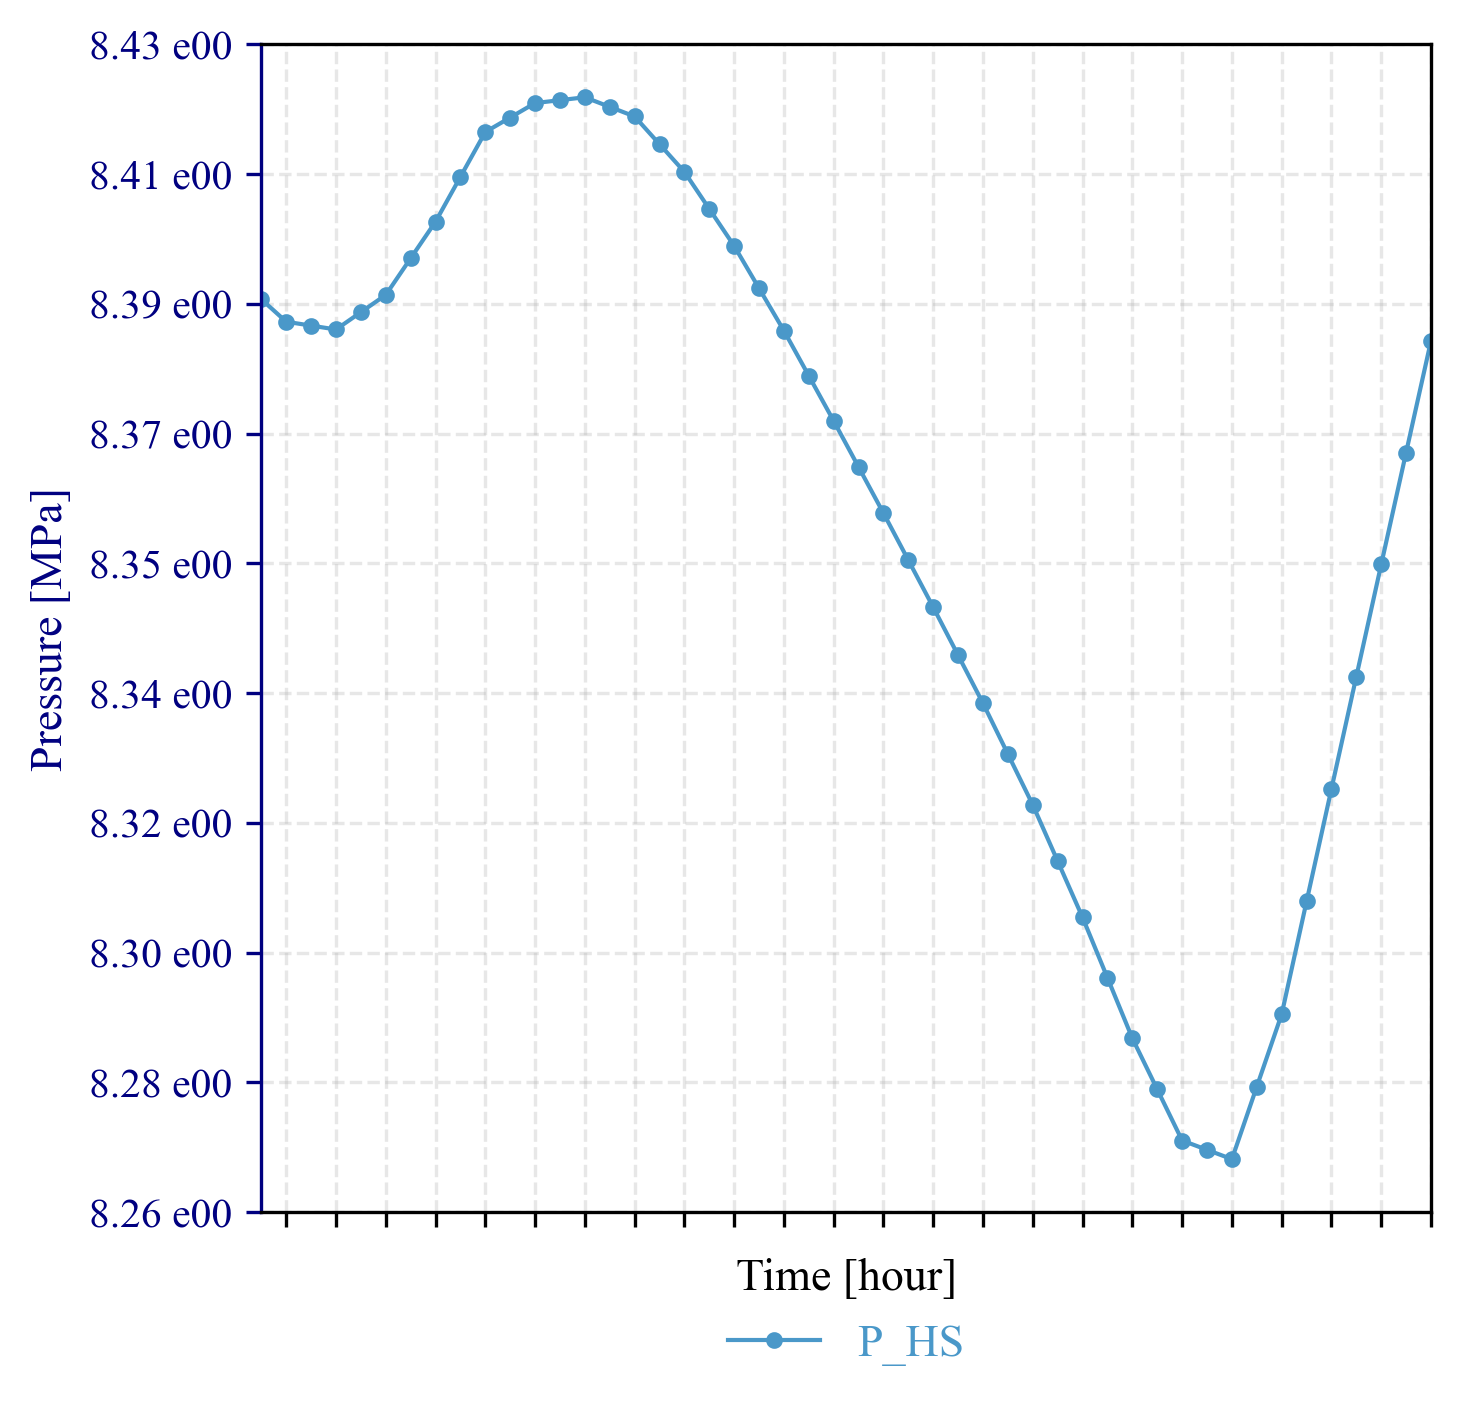

In [125]:
Figure_title = 'Storage Pressure'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['P_HS'],
    left_label= 'Pressure',
    left_units='[MPa]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

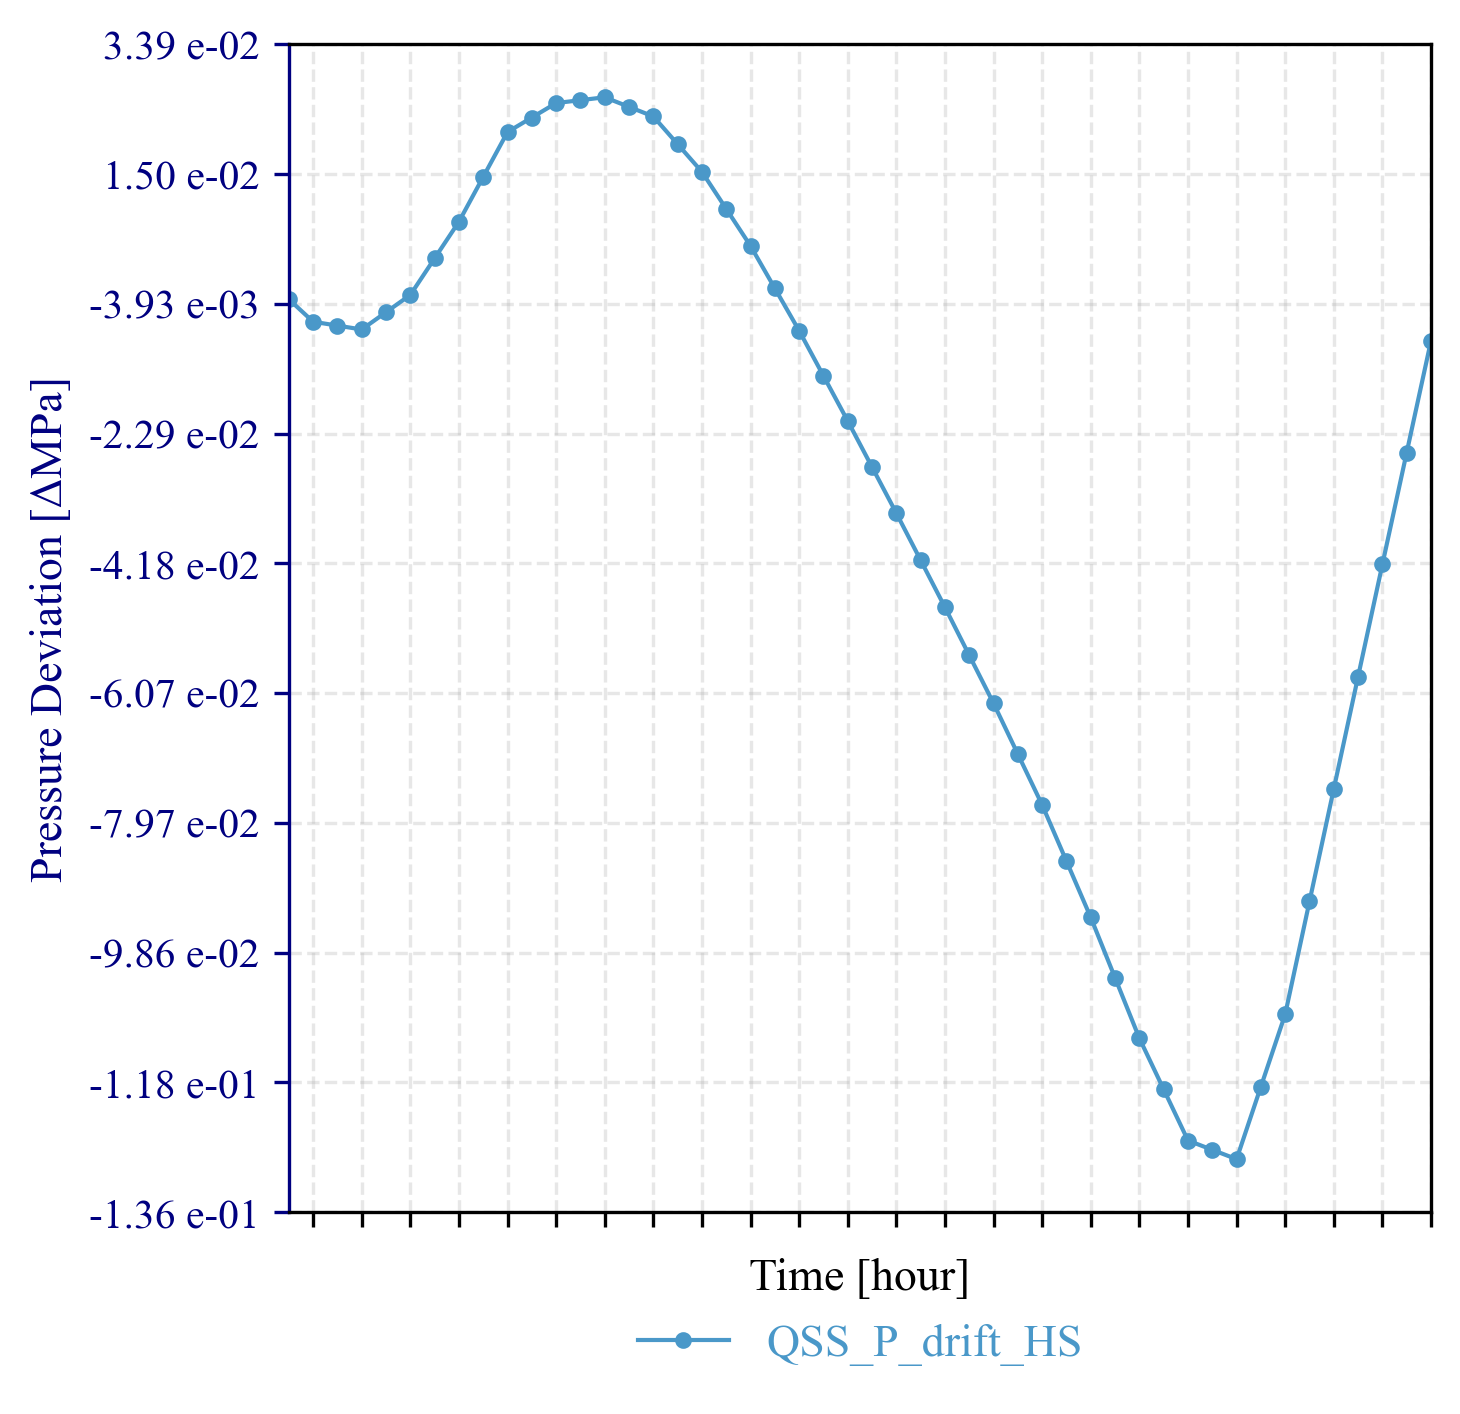

In [126]:
Figure_title = 'QSS Baseline Pressure Deviation'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['QSS_P_drift_HS'],
    left_label= 'Pressure Deviation',
    left_units='[ΔMPa]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

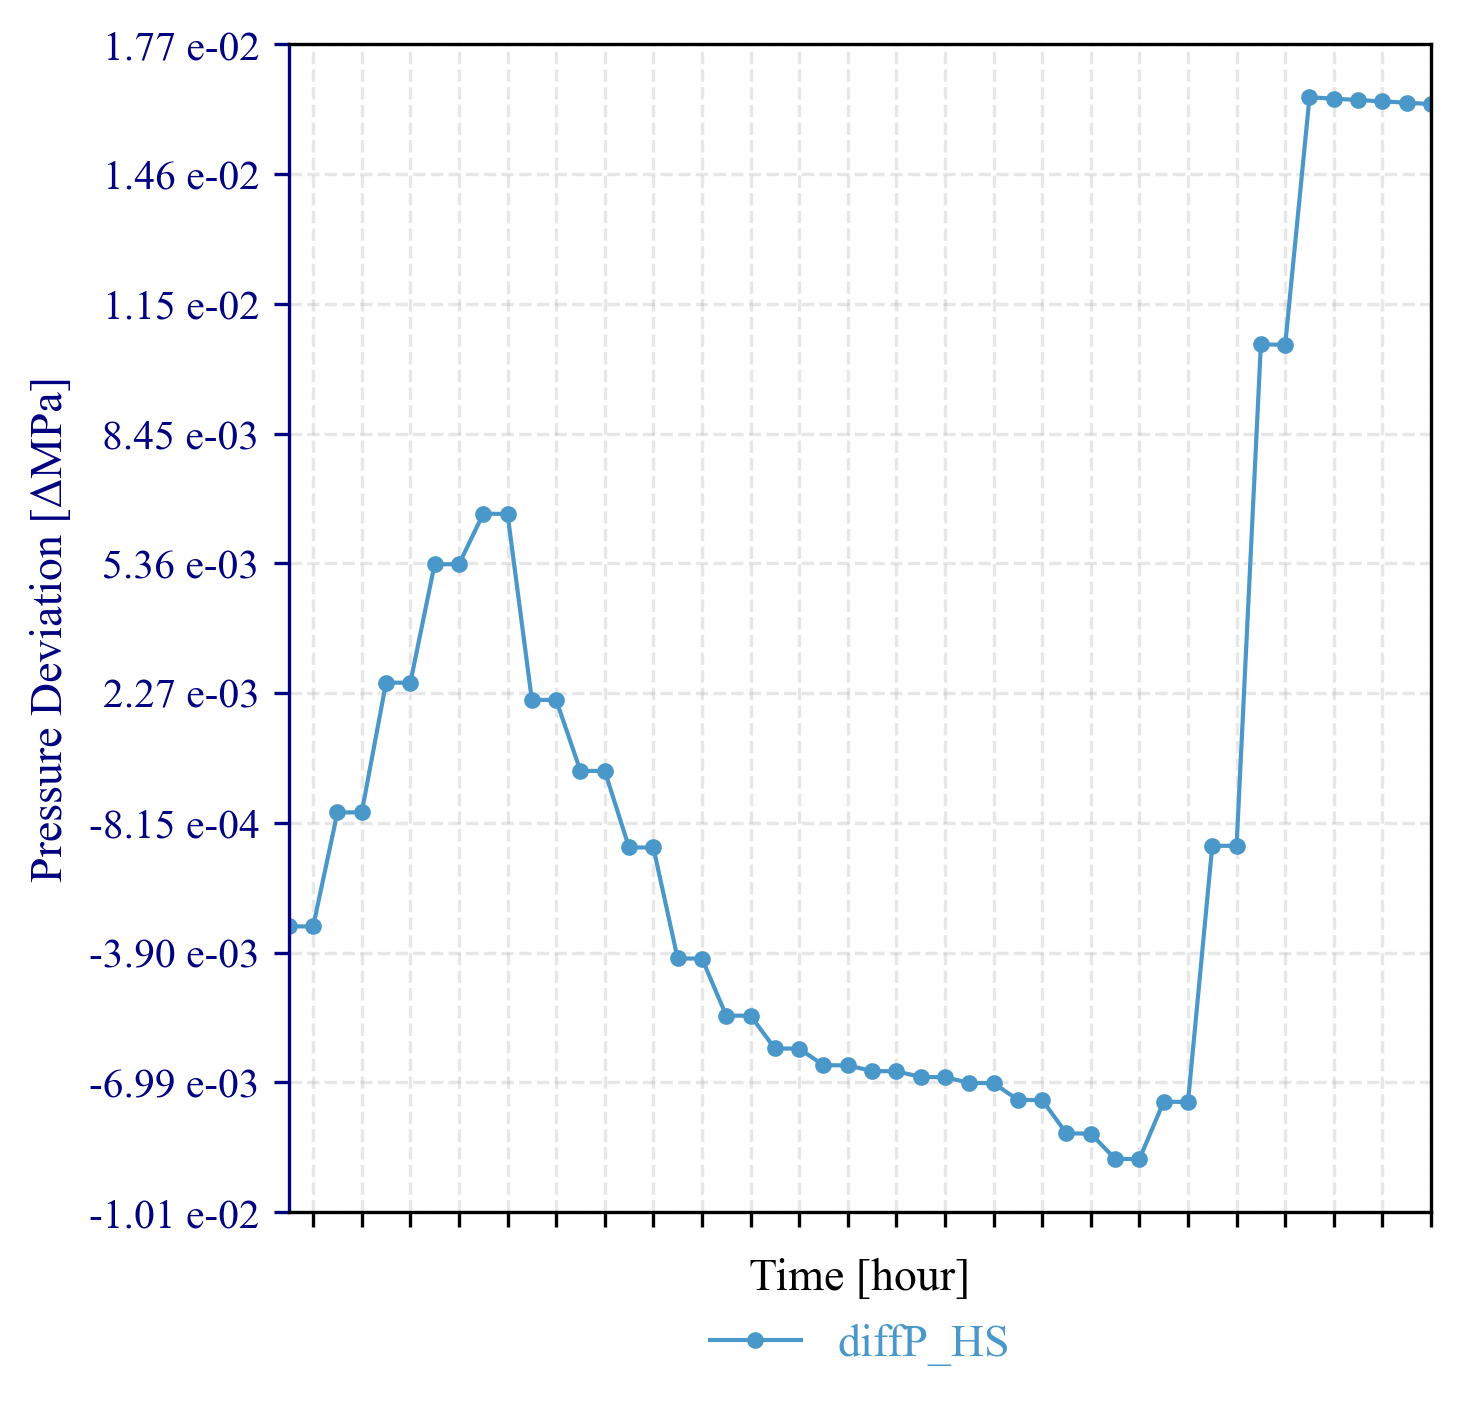

In [127]:
Figure_title = 'Consecutive Pressure Deviation'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['diffP_HS'],
    left_label= 'Pressure Deviation',
    left_units='[ΔMPa]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

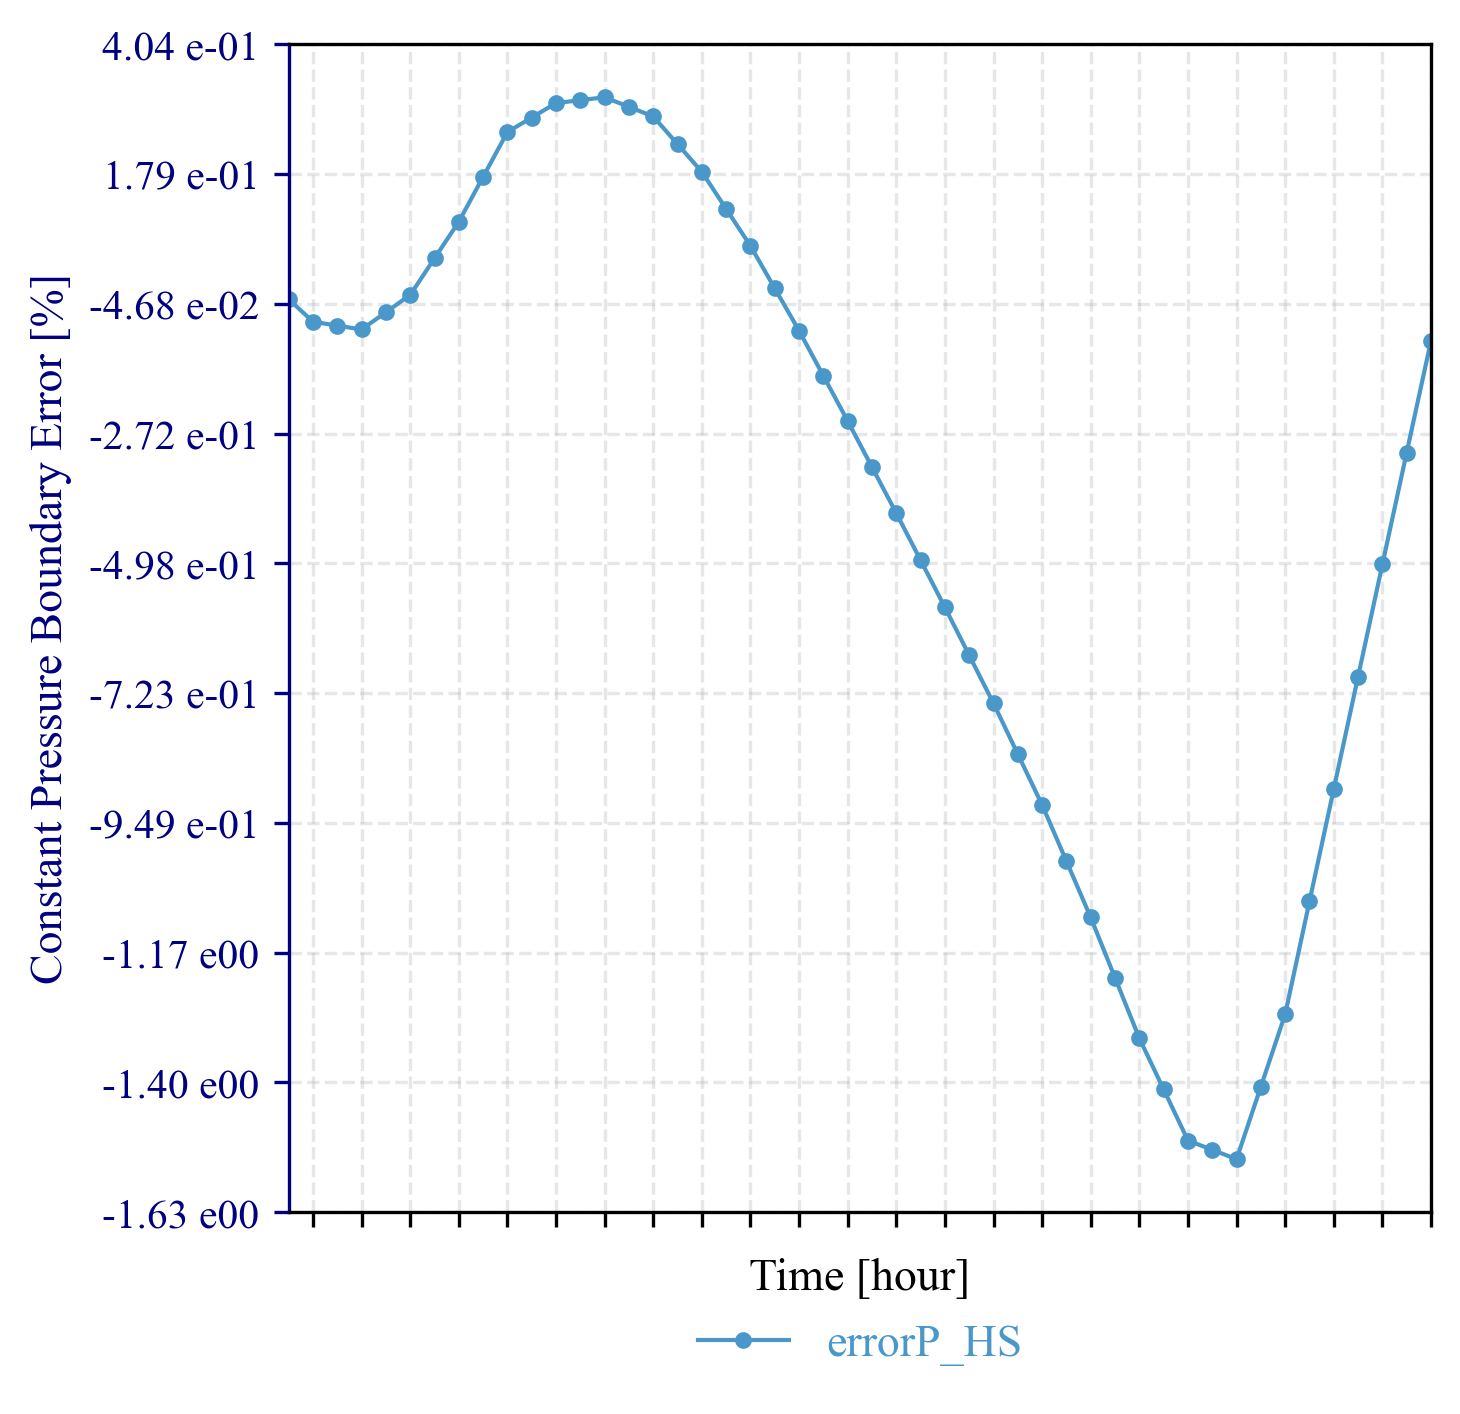

In [128]:
Figure_title = 'QSS Approximation Compliance'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['errorP_HS'],
    left_label= 'Constant Pressure Boundary Error',
    left_units='[%]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

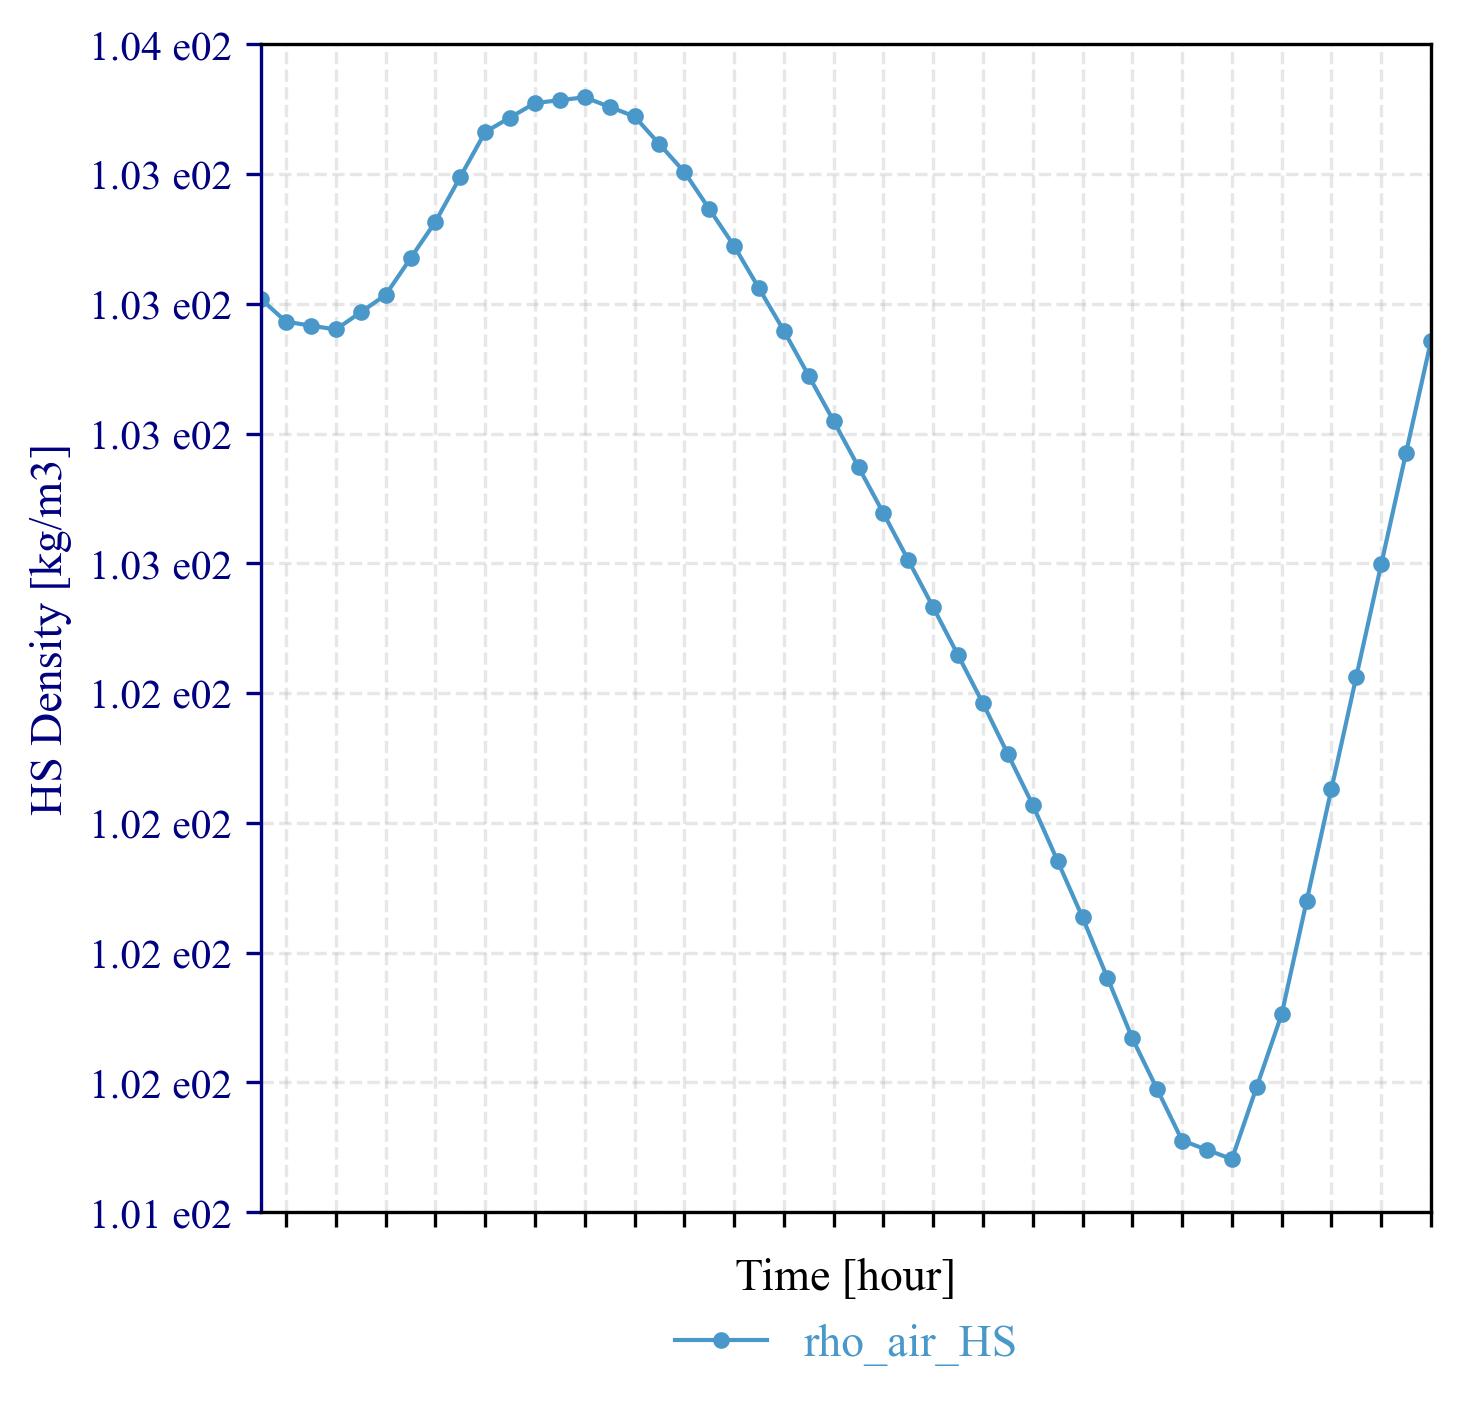

In [129]:
Figure_title = f'{Working_fluid} Density Evolution'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['rho_air_HS'],
    left_label= 'HS Density',
    left_units='[kg/m3]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

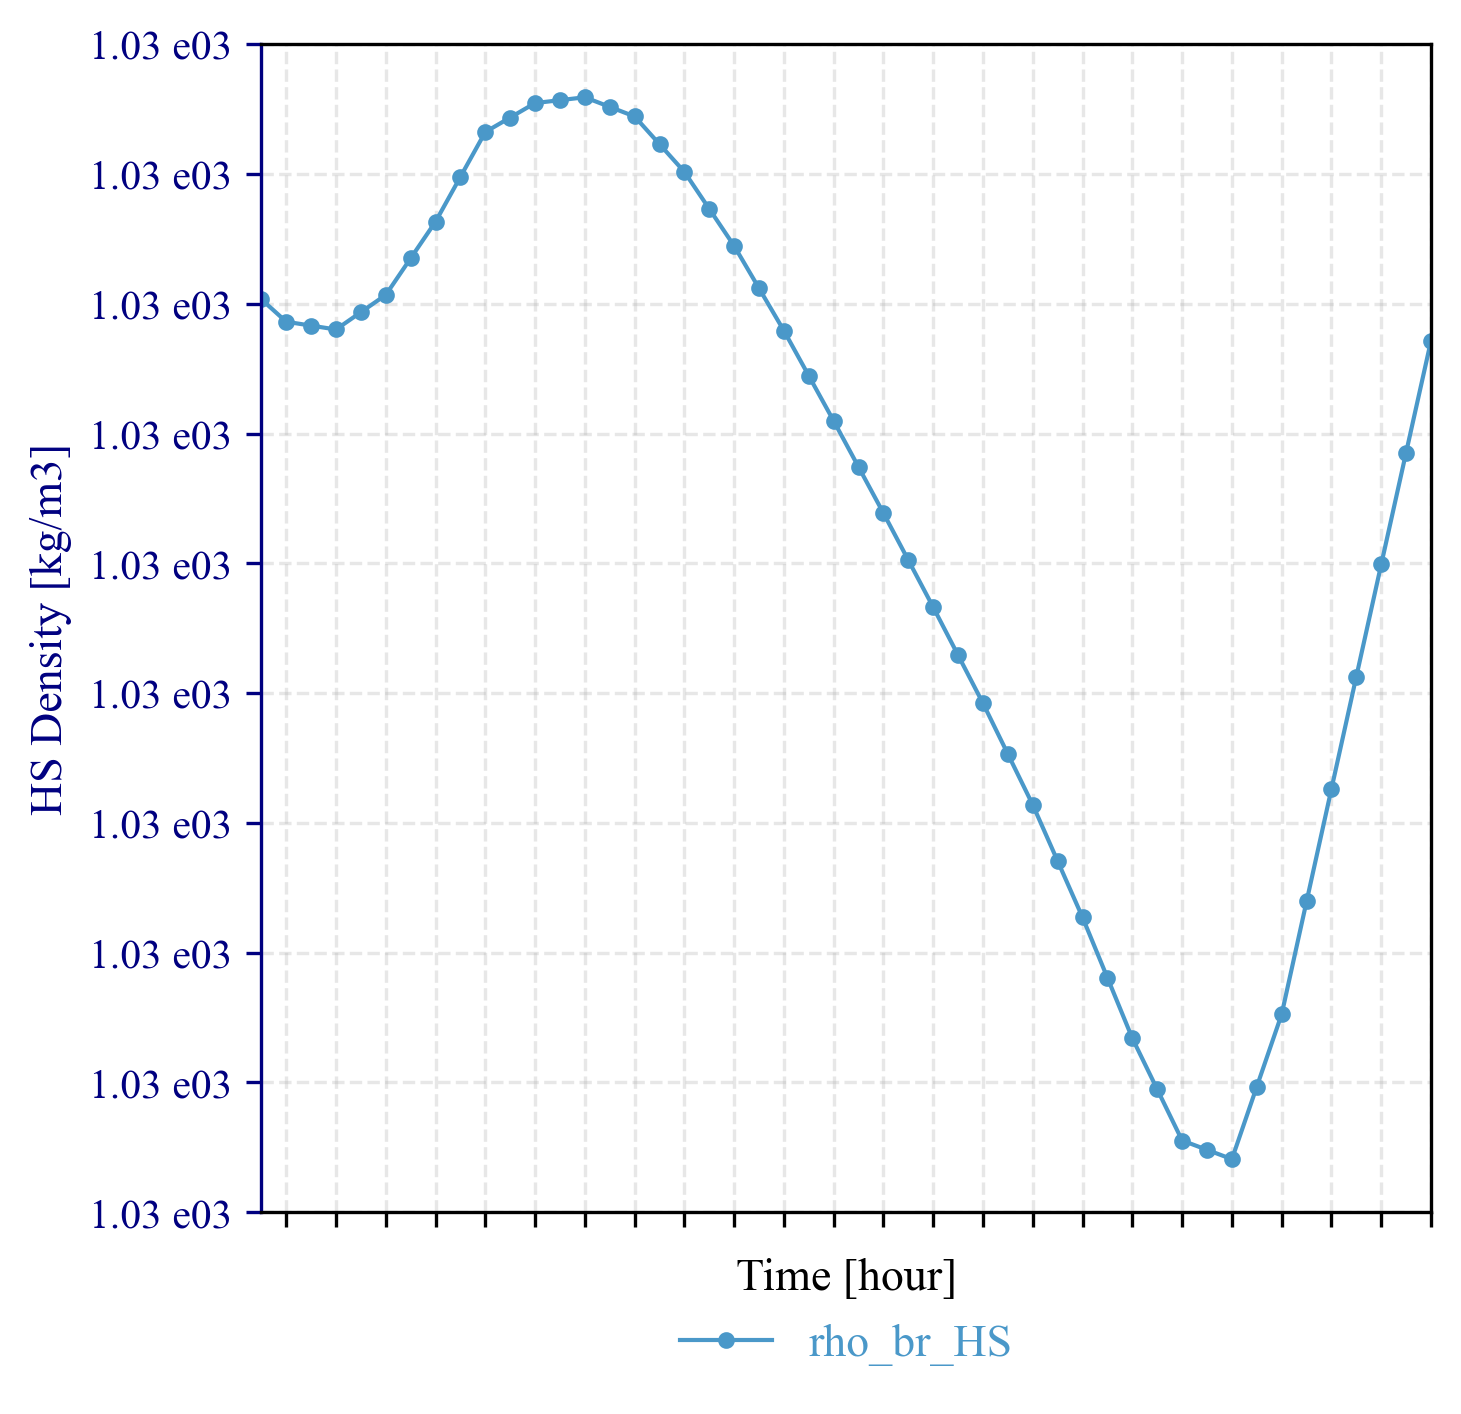

In [130]:
Figure_title = 'Brine Density Evolution'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['rho_br_HS'],
    left_label= 'HS Density',
    left_units='[kg/m3]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

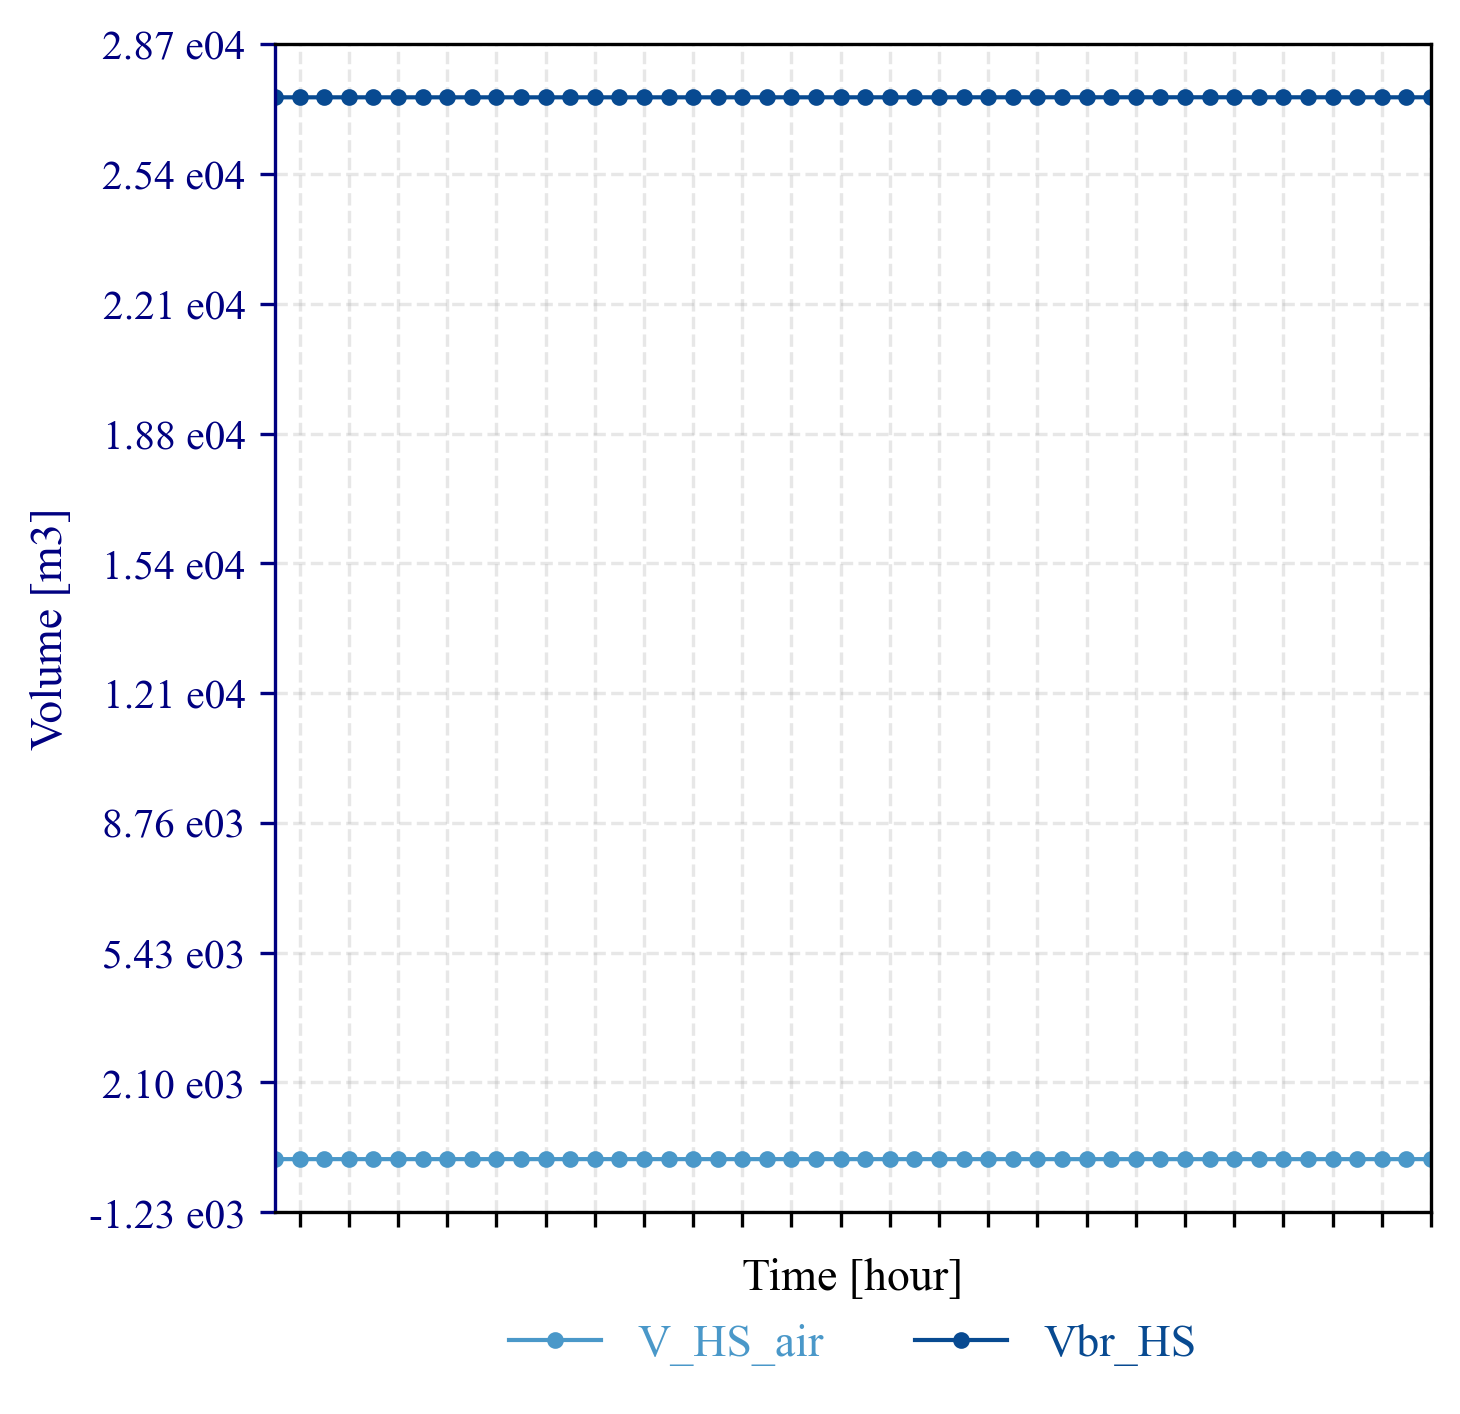

In [131]:
Figure_title = 'HS Volumetric Composition'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['V_HS_air', 'Vbr_HS'],
    left_label= 'Volume',
    left_units='[m3]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

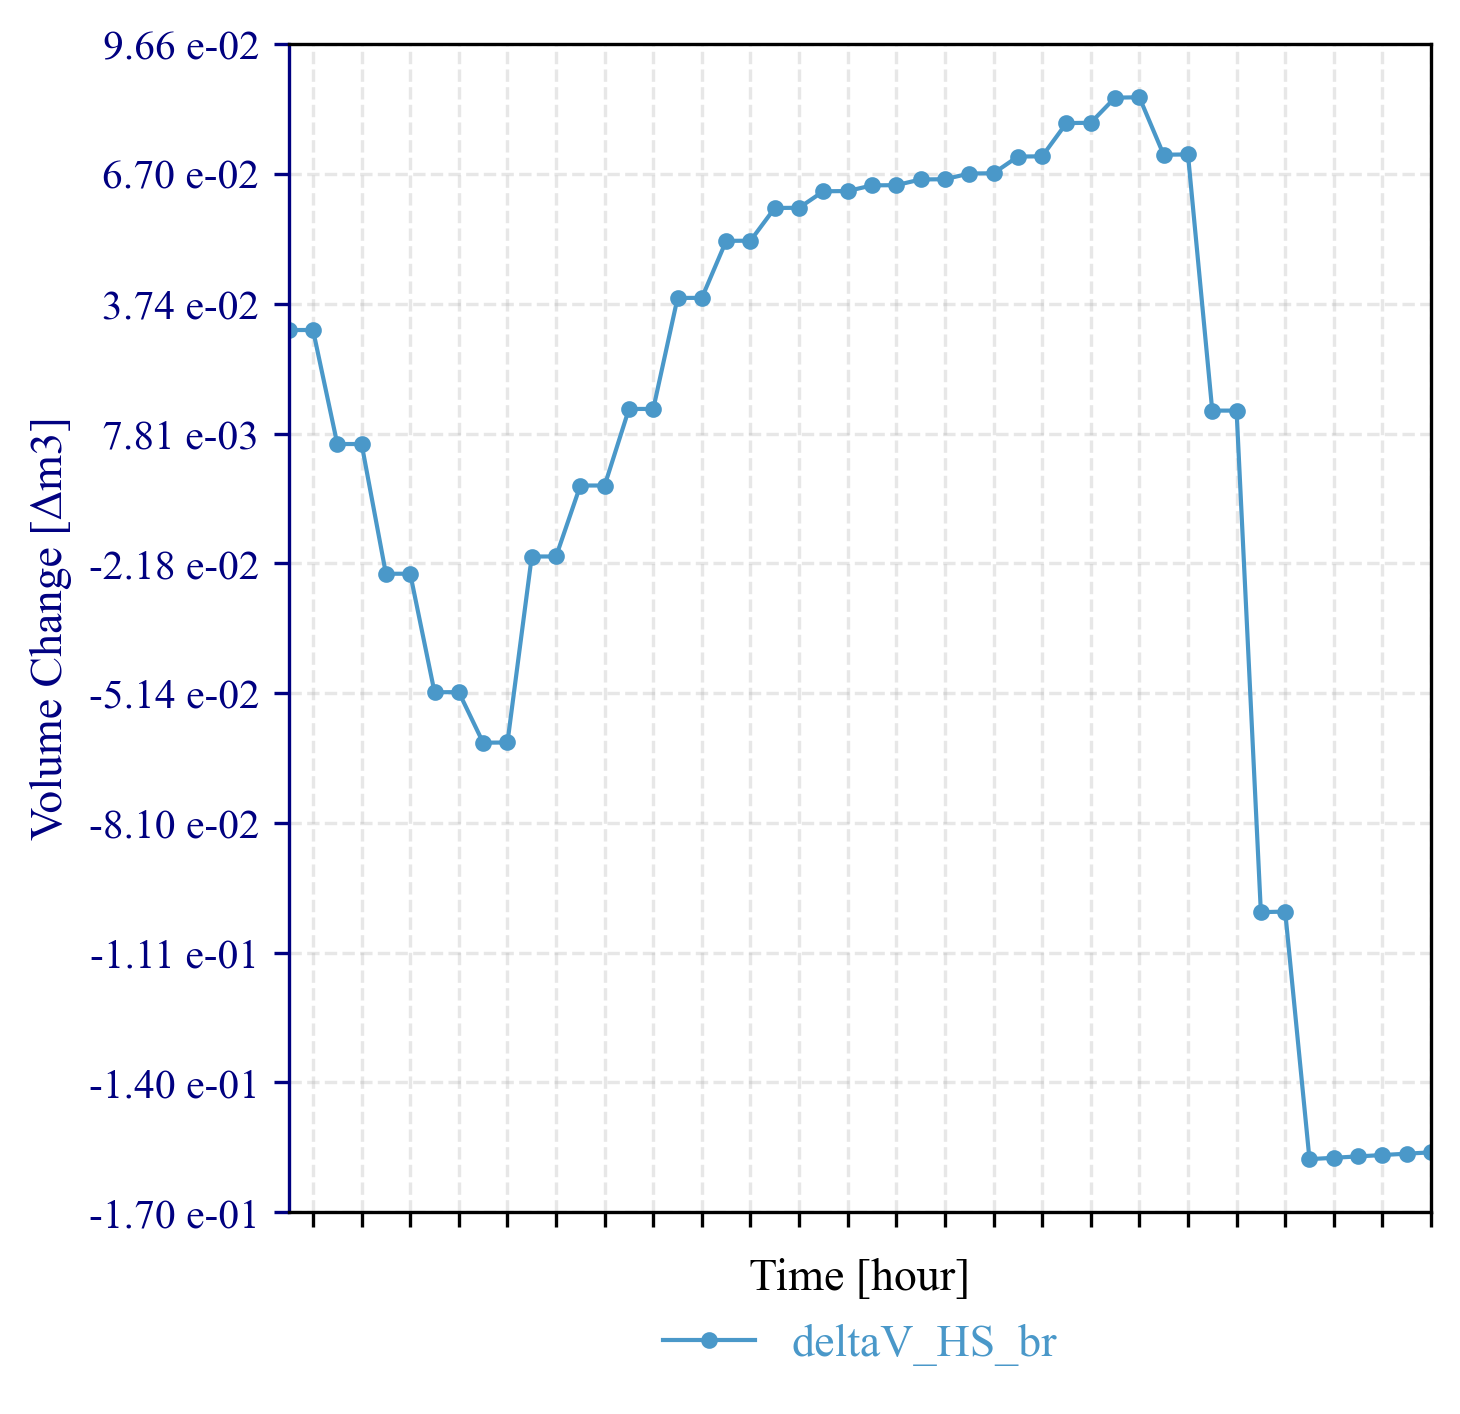

In [132]:
Figure_title = 'Brine Volume Adjustment'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['deltaV_HS_br'],
    left_label= 'Volume Change',
    left_units='[Δm3]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

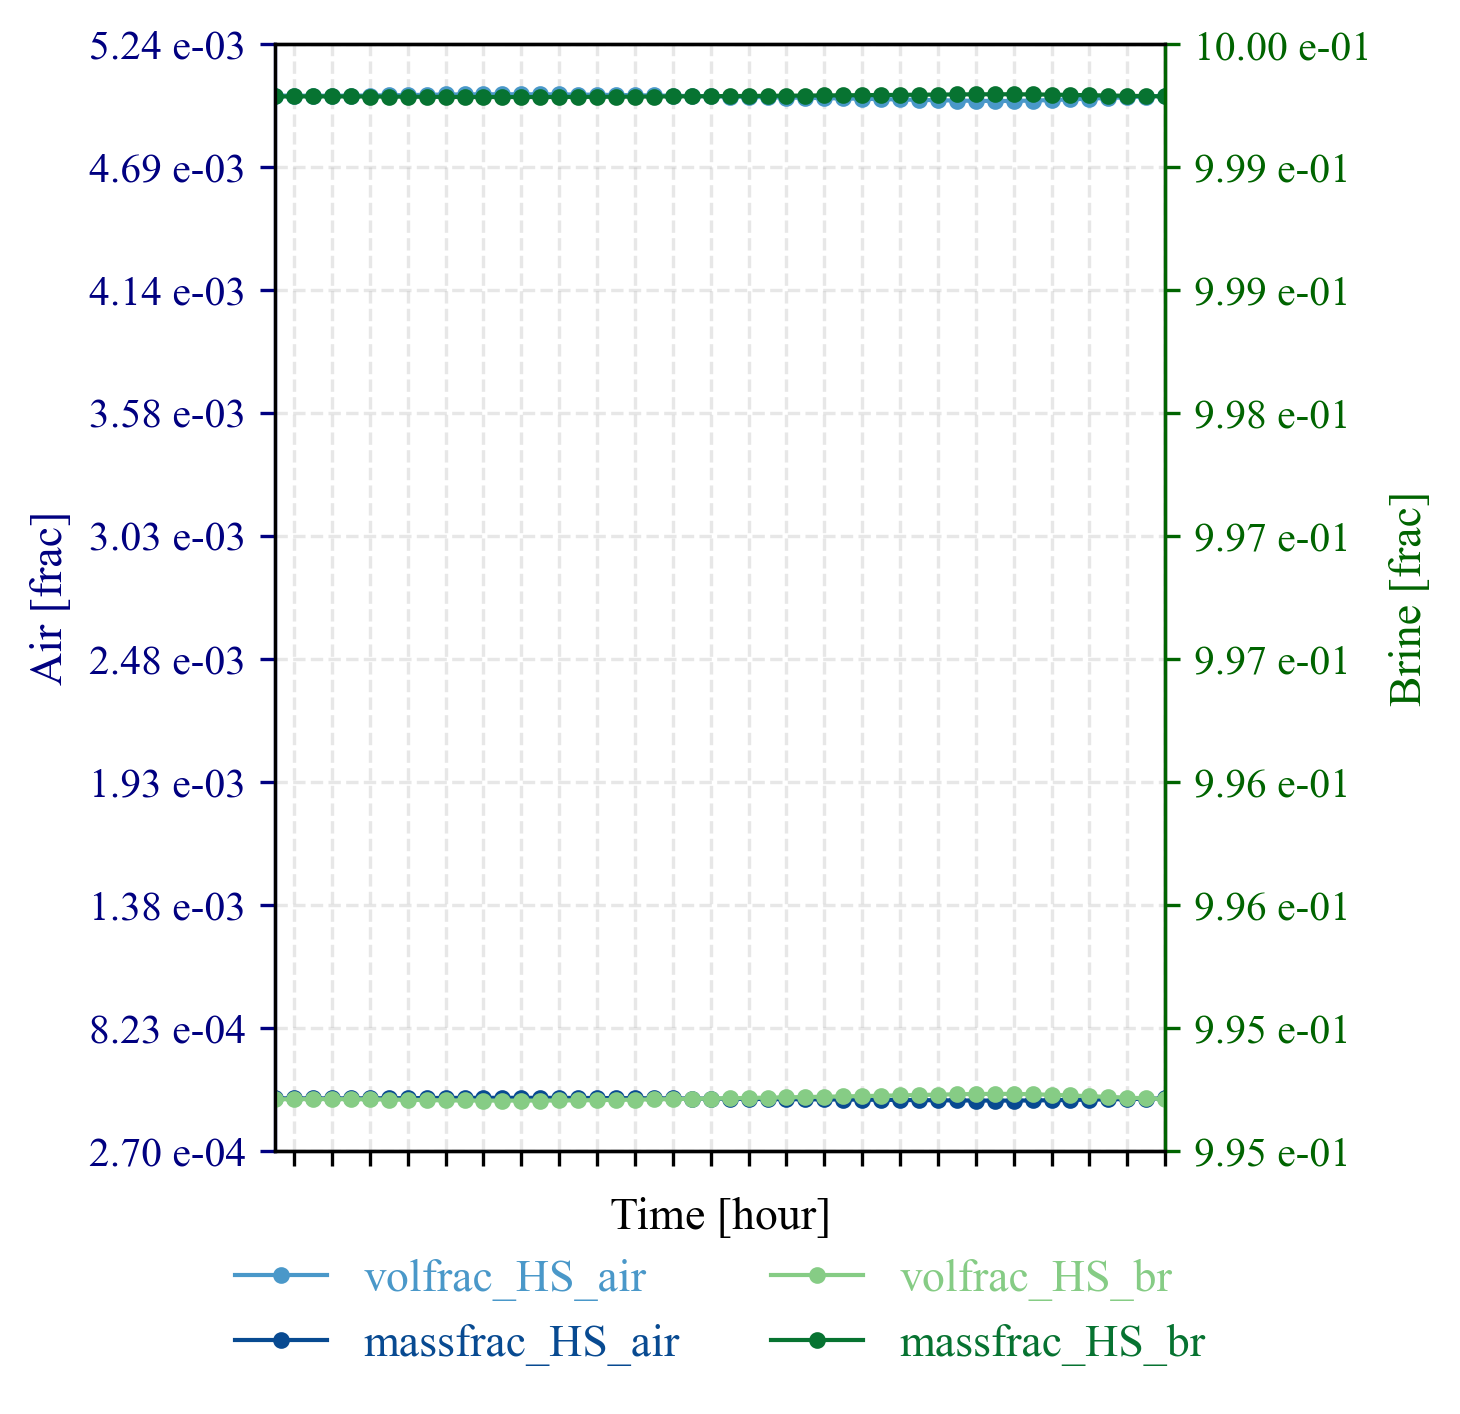

In [133]:
Figure_title = 'HS Binary Phase Composition'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['volfrac_HS_air','massfrac_HS_air'],
    left_label= 'Air',
    left_units='[frac]',
    series_right=['volfrac_HS_br','massfrac_HS_br'],
    right_label= 'Brine',
    right_units='[frac]')
                         

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

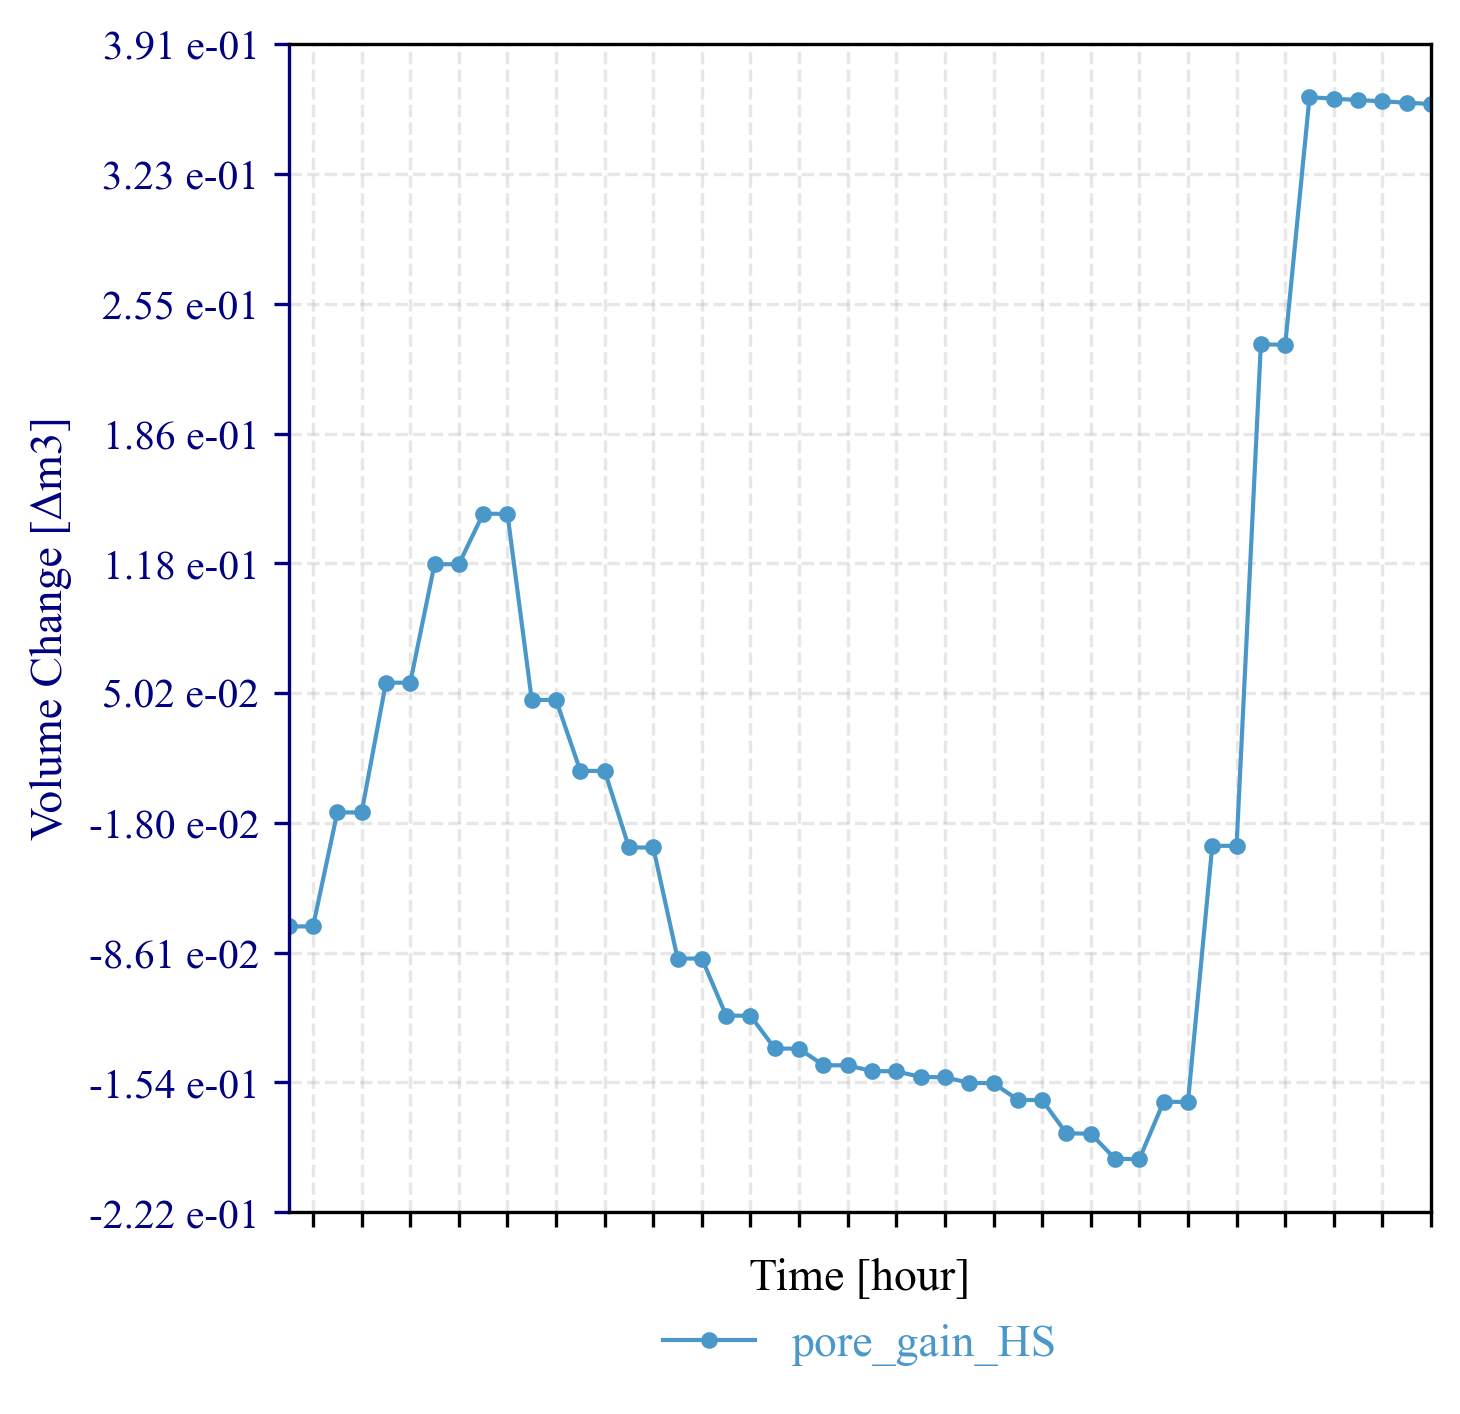

In [134]:
Figure_title = 'Pore Volume Gain'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['pore_gain_HS'],
    left_label= 'Volume Change',
    left_units='[Δm3]')
                         

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

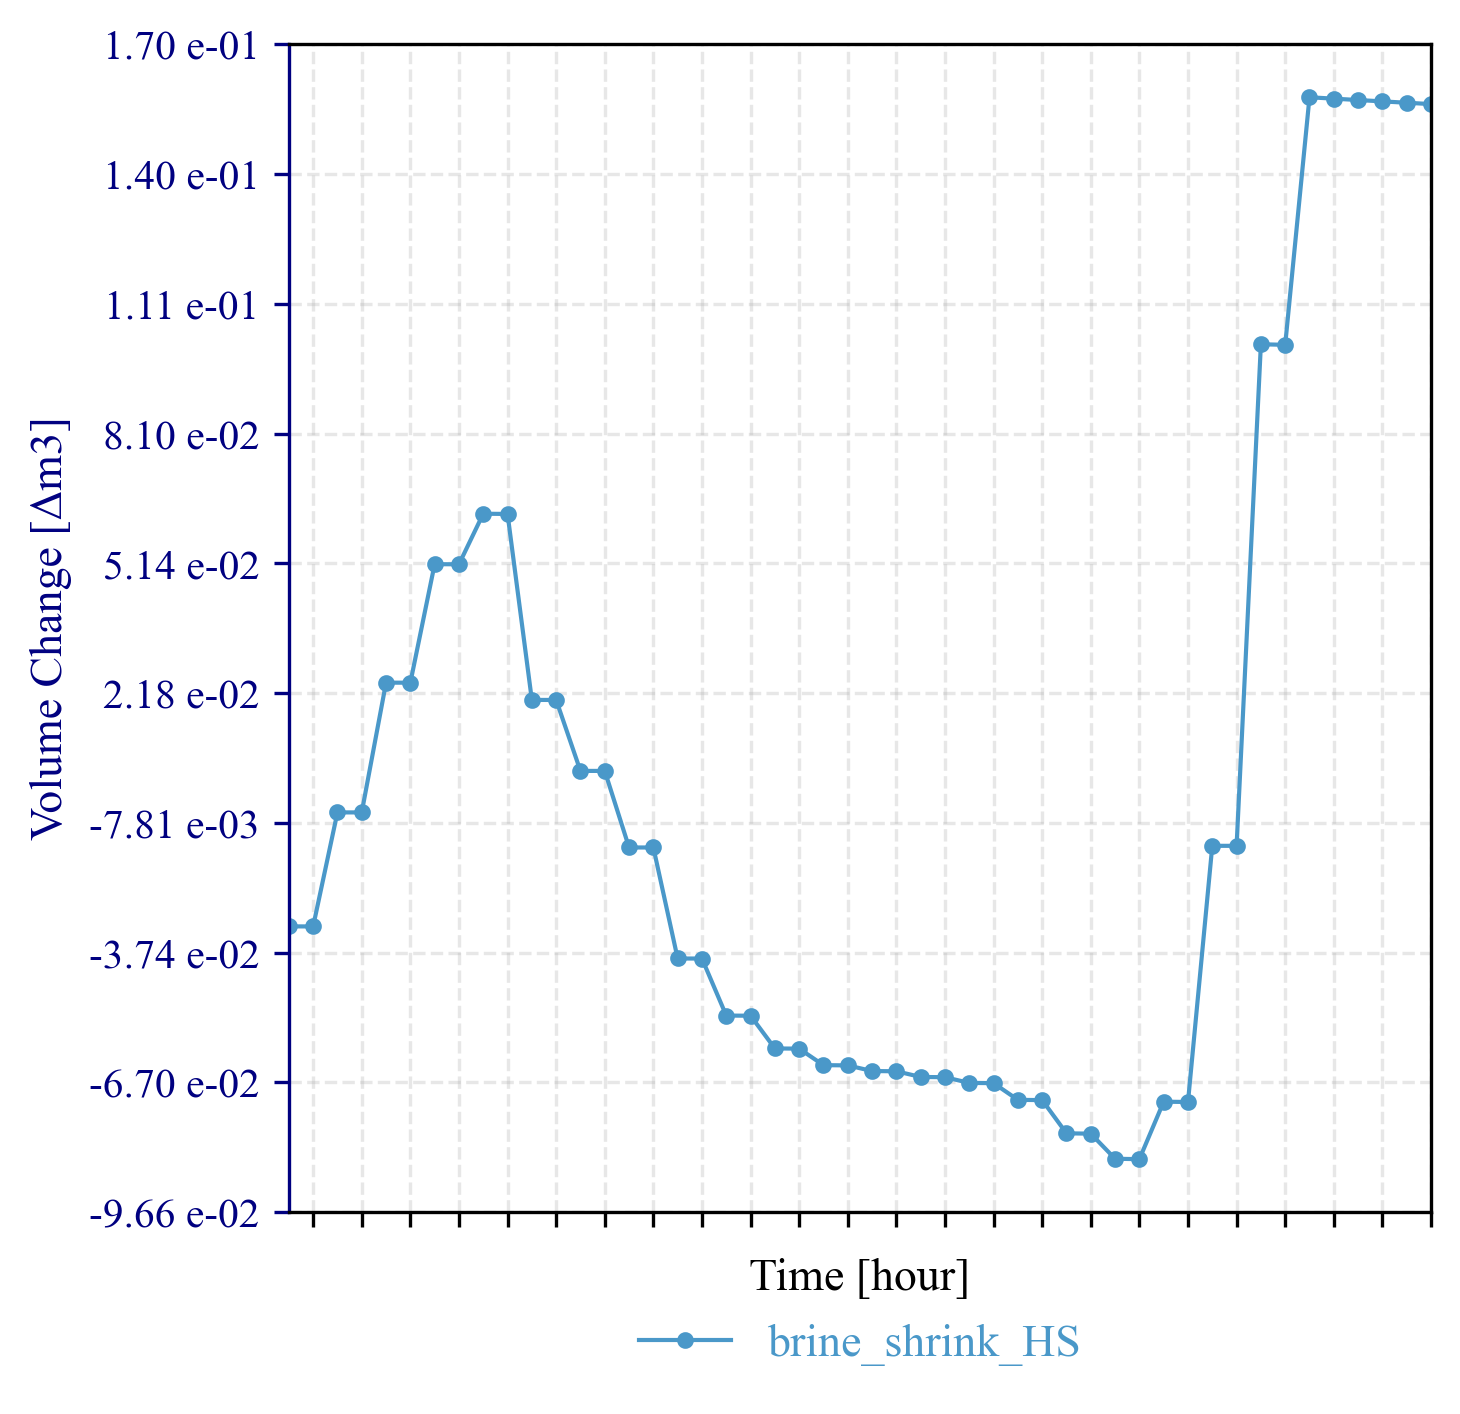

In [135]:
Figure_title = 'Brine Shrinkage'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['brine_shrink_HS'],
    left_label= 'Volume Change',
    left_units='[Δm3]')
                         

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

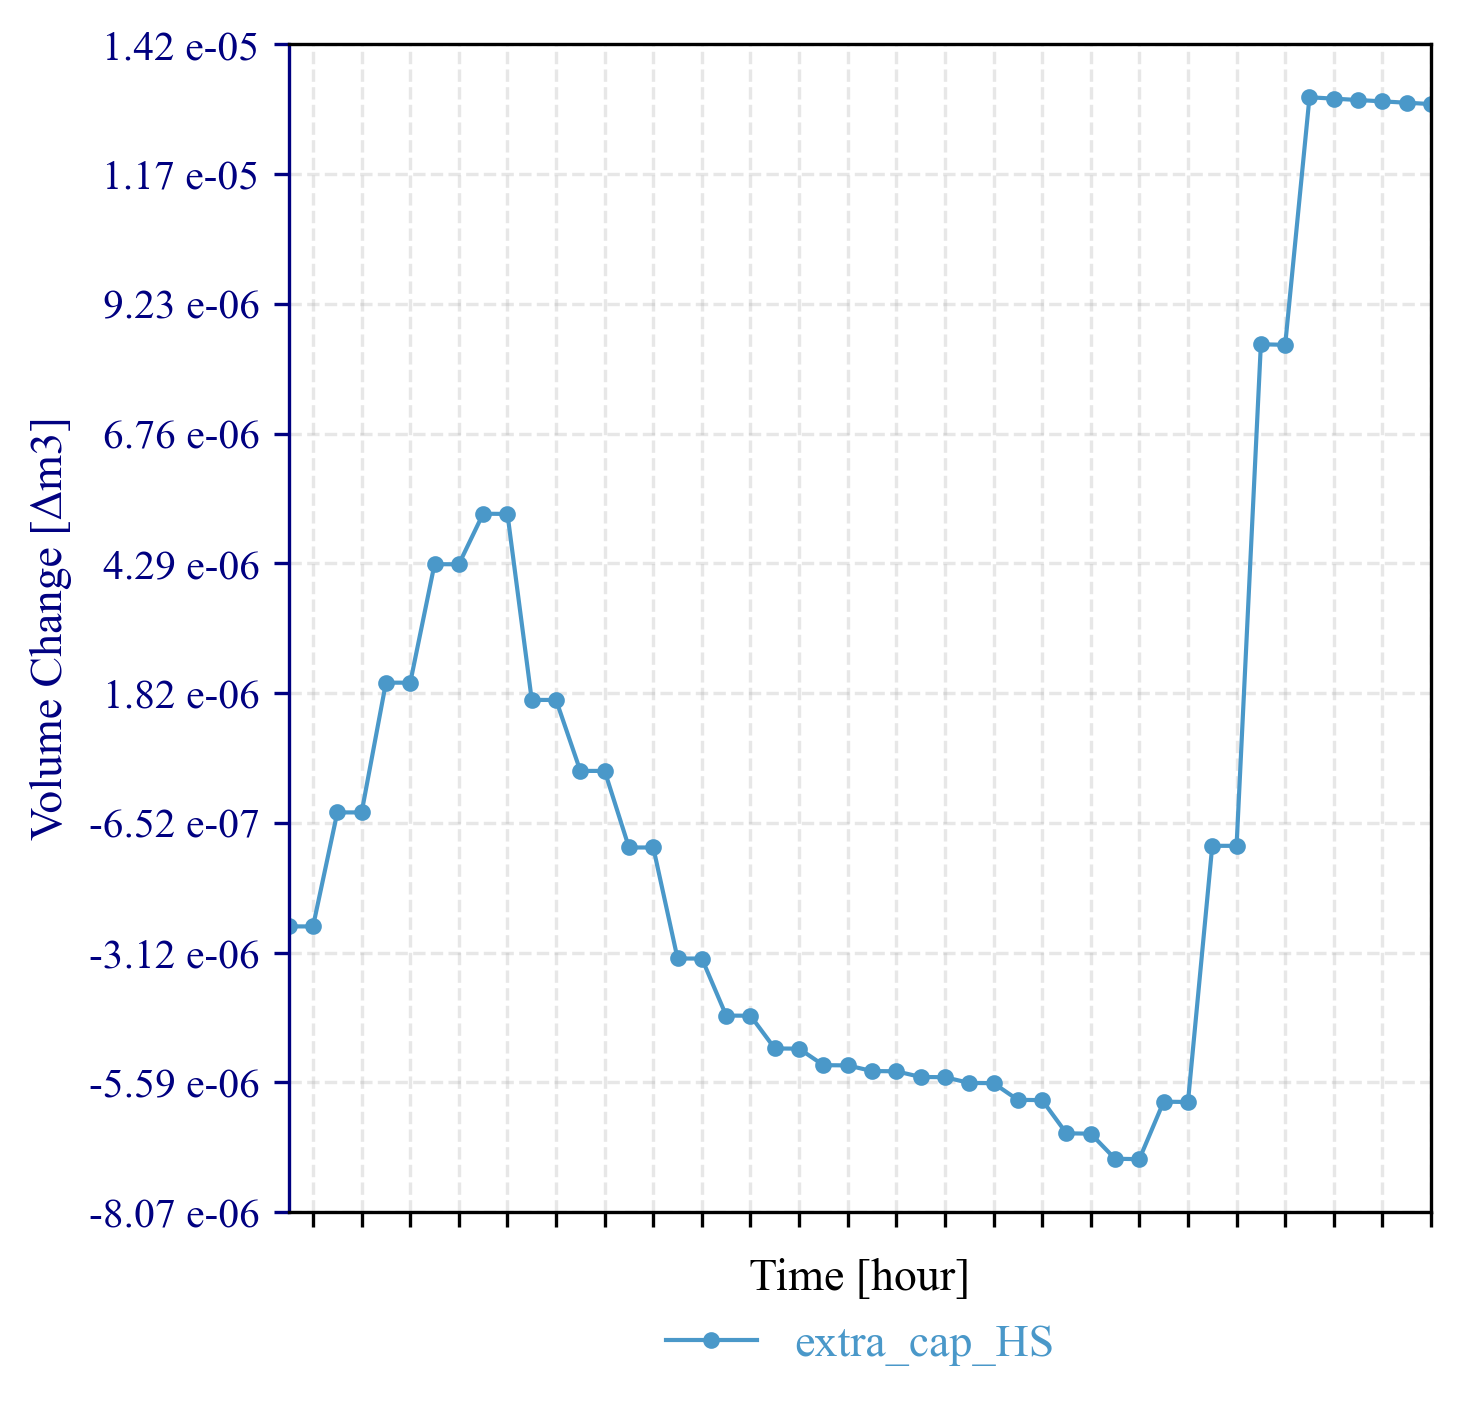

In [136]:
Figure_title = 'Extra Cap'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['extra_cap_HS'],
    left_label= 'Volume Change',
    left_units='[Δm3]')
                         

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

In [137]:
import time; from openpyxl import load_workbook
total_runtime = time.time() - _start_time; total_runtime_mins = total_runtime/60; print(f"Simulation total runtime: {total_runtime_mins:.2f} minutes")
KPI_file_path = data_dir / f"{simulation_name}_dfKPI.xlsx"; wb = load_workbook(KPI_file_path); ws = wb.active; ws.append(["Simulation_runtime_mins", total_runtime_mins]); wb.save(KPI_file_path)

Simulation total runtime: 1.95 minutes
